In [2]:
# ============================
# Social Intelligence Analyst Agent (Schema-agnostic, Autonomous-by-default)
# ============================
# Requires:
#   pip install -U google-genai pandas numpy scikit-learn umap-learn matplotlib tqdm rich
#
# Key features:
# - Robust header/preamble detection + delimiter sniff
# - Column selection based on observed evidence (examples + diagnostics), not name guesses
# - Datetime diagnostics computed for ALL columns
# - No downsampling of dataset
# - Adaptive k (metrics + coherence checks, iterate)
# - Language-aware labeling (no English assumption)
# - Autonomous by default; pauses only when low-confidence or repeated failures
# - Natural-language interjection patches AGENT_STATE safely
# ============================

from __future__ import annotations

import os, re, csv, json, time, traceback
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap.umap_ as umap

from rich.console import Console
from rich.panel import Panel

from getpass import getpass
from google import genai
from google.genai import types

console = Console()

# ----------------------------
# Agent State (edit DATA_PATH)
# ----------------------------
AGENT_STATE: Dict[str, Any] = {
    "DATA_PATH": "/Users/angusmclean/Downloads/2056554290/SocialData.csv",  # <-- set this
    "OUTPUT_DIR": "outputs",
    "artifacts": [],
    "run_id": time.strftime("%Y%m%d-%H%M%S"),

    # Autonomous behavior controls
    "AUTO_MODE": True,              # autonomous by default
    "PAUSE_ON_LOW_CONFIDENCE": True,
    "LOW_CONF_THRESHOLD": 0.70,     # 0..1 (LLM-reported confidence)

    # Optional explicit overrides (set by you or via NL interjection)
    # "TEXT_COL": "exact column name",
    # "TIME_COLS": ["one or more time columns"],
    # "ENGAGEMENT_COLS": ["numeric columns"],

    # Adaptive-k controls (can be adjusted by agent or you)
    "K_MIN": 8,
    "K_MAX": 80,
    "K_STEP": 4,
    "K_FINE_WINDOW": 6,
    # Optional override:
    # "FORCE_K": 32,
}

# ----------------------------
# Artifact helpers
# ----------------------------
def ensure_dirs() -> None:
    os.makedirs(AGENT_STATE["OUTPUT_DIR"], exist_ok=True)

def add_artifact(path: str) -> None:
    if not path:
        return
    p = str(path)
    if "artifacts" not in AGENT_STATE or AGENT_STATE["artifacts"] is None:
        AGENT_STATE["artifacts"] = []
    if p not in AGENT_STATE["artifacts"]:
        AGENT_STATE["artifacts"].append(p)

def safe_write(path: str, content: str) -> None:
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)
    add_artifact(path)

def savefig(path: str) -> None:
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.close()
    add_artifact(path)

def validate_paths() -> None:
    dp = AGENT_STATE["DATA_PATH"]
    if not os.path.exists(dp):
        raise FileNotFoundError(f"DATA_PATH does not exist: {dp}")
    ensure_dirs()

# ----------------------------
# Gemini client
# ----------------------------
def get_gemini_client() -> genai.Client:
    if not os.environ.get("GOOGLE_API_KEY"):
        os.environ["GOOGLE_API_KEY"] = getpass("Gemini API key: ")
    return genai.Client()

# ----------------------------
# Safe natural-language interjection -> state patch
# ----------------------------
ALLOWED_STATE_KEYS = {
    "TEXT_COL", "TIME_COLS", "ENGAGEMENT_COLS",
    "K_MIN", "K_MAX", "K_STEP", "K_FINE_WINDOW", "FORCE_K",
    "AUTO_MODE", "PAUSE_ON_LOW_CONFIDENCE", "LOW_CONF_THRESHOLD",
}

def apply_state_patch(patch: Dict[str, Any]) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    applied, ignored = {}, {}
    for k, v in patch.items():
        if k in ALLOWED_STATE_KEYS:
            AGENT_STATE[k] = v
            applied[k] = v
        else:
            ignored[k] = v
    return applied, ignored

def nl_to_state_patch(client: genai.Client, user_message: str, context: str) -> Dict[str, Any]:
    prompt = {
        "task": "Convert user guidance into a minimal patch to AGENT_STATE.",
        "rules": [
            "Return ONLY a valid JSON object.",
            f"Only use these keys: {sorted(ALLOWED_STATE_KEYS)}",
            "If user says 'don't use engagement', set ENGAGEMENT_COLS=[]",
            "If user says 'use X as time', set TIME_COLS=[X] unless they mention multiple",
        ],
        "context": context,
        "user_message": user_message
    }
    resp = client.models.generate_content(model="gemini-2.5-pro", contents=json.dumps(prompt, ensure_ascii=False))
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        raise ValueError(f"Could not parse JSON from NL patch response.\nRaw:\n{txt[:1200]}")
    return json.loads(m.group(0))

def maybe_pause_for_user(
    client: genai.Client,
    title: str,
    summary: str,
    force: bool = False
) -> None:
    """
    Autonomous by default.
    Pauses only if force=True or AUTO_MODE=False.
    Natural-language input becomes state patch.
    """
    console.print(Panel(summary, title=f"CHECKPOINT: {title}", style="cyan"))

    if AGENT_STATE.get("AUTO_MODE", True) and not force:
        return

    while True:
        msg = input("Enter=continue | 'stop'=halt | or type guidance in plain English: ").strip()
        if msg == "":
            return
        if msg.lower() == "stop":
            raise SystemExit("Stopped by user.")
        try:
            patch = nl_to_state_patch(client, msg, context=f"{title}\n\n{summary}")
            applied, ignored = apply_state_patch(patch)
            console.print(Panel(json.dumps(applied, indent=2, ensure_ascii=False), title="Applied patch", style="green"))
            if ignored:
                console.print(Panel(json.dumps(ignored, indent=2, ensure_ascii=False), title="Ignored keys", style="yellow"))
            console.print(Panel("Patch applied. Enter to continue or add more guidance.", style="green"))
        except Exception as e:
            console.print(Panel(f"Could not apply guidance: {e}", title="Interjection error", style="red"))

# ----------------------------
# Stage runner with 3-strikes stop + ask
# ----------------------------
@dataclass
class StageRunner:
    name: str
    max_failures: int = 3
    failures: int = 0

    def run(self, client: genai.Client, fn):
        while True:
            try:
                return fn()
            except SystemExit:
                raise
            except Exception:
                self.failures += 1
                err = traceback.format_exc()
                console.print(Panel(err[-4000:], title=f"ERROR in stage '{self.name}' (attempt {self.failures})", style="red"))
                fail_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], f"last_failed_{self.name}.txt")
                safe_write(fail_path, err)

                if self.failures >= self.max_failures:
                    # Force human interjection after 3 strikes
                    maybe_pause_for_user(
                        client,
                        title=f"{self.name} failed {self.failures} times",
                        summary=f"Last error saved: {fail_path}\nYou can give guidance like:\n"
                                f"- use column X as text\n- use column Y as time\n- force k to 24\n"
                                f"Then press Enter to retry, or type stop.",
                        force=True
                    )
                    self.failures = 0  # reset after user intervention
                else:
                    # In AUTO_MODE, we still continue retrying unless user has set AUTO_MODE=False
                    maybe_pause_for_user(
                        client,
                        title=f"{self.name} failed",
                        summary=f"Last error saved: {fail_path}\n"
                                f"(Autonomous retry will continue unless you disable AUTO_MODE.)",
                        force=False
                    )
                    if not AGENT_STATE.get("AUTO_MODE", True):
                        # If not autonomous, give chance to intervene now
                        maybe_pause_for_user(client, title=f"{self.name} retry?", summary="Provide guidance or Enter to retry.", force=True)

# ----------------------------
# CSV header/preamble + delimiter sniff + load
# ----------------------------
def looks_like_metadata(line: str) -> bool:
    # ex: "Report:, Bulk Mentions Download"
    return bool(re.match(r"^\s*[A-Za-z][A-Za-z _-]*:\s*,", line))

def find_real_header_row(path: str, scan_lines: int = 6000) -> int:
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        lines = []
        for _ in range(scan_lines):
            line = f.readline()
            if not line:
                break
            lines.append(line.rstrip("\n"))

    i = 0
    while i < len(lines) and (lines[i].strip() == "" or looks_like_metadata(lines[i])):
        i += 1

    # first line with enough separators and not metadata
    for j in range(i, len(lines)):
        line = lines[j]
        if looks_like_metadata(line):
            continue
        if max(line.count(","), line.count("\t"), line.count(";"), line.count("|")) >= 2:
            return j

    return i

def sniff_delimiter(path: str, header_row: int) -> str:
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        for _ in range(header_row):
            f.readline()
        sample = "".join([f.readline() for _ in range(40)])
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=[",", "\t", ";", "|"])
        return dialect.delimiter
    except Exception:
        return ","  # acceptable base assumption per your earlier OK

def robust_read_csv(path: str) -> Tuple[pd.DataFrame, int, str]:
    header_row = find_real_header_row(path)
    delim = sniff_delimiter(path, header_row)
    try:
        df = pd.read_csv(path, skiprows=header_row, sep=delim)
    except pd.errors.ParserError:
        df = pd.read_csv(path, skiprows=header_row, sep=delim, engine="python", on_bad_lines="skip")
    return df, header_row, delim

# ----------------------------
# Profiling + diagnostics (observe before decide)
# ----------------------------
def profile_dataframe(df: pd.DataFrame, out_path: str, n_examples: int = 5) -> None:
    lines = [f"shape: {df.shape}", "columns:"]
    for c in df.columns:
        s = df[c]
        dtype = str(s.dtype)
        null_rate = float(s.isna().mean())
        examples = s.dropna().astype(str).head(n_examples).tolist()
        lines.append(json.dumps({
            "name": str(c),
            "dtype": dtype,
            "null_rate": round(null_rate, 4),
            "examples": examples
        }, ensure_ascii=False))
    safe_write(out_path, "\n".join(lines))

def datetime_parse_diagnostics(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for c in df.columns:
        s = df[c]
        if s.dropna().empty:
            continue
        parsed = pd.to_datetime(s, errors="coerce", utc=False)
        rate = float(parsed.notna().mean())
        if rate > 0:
            rows.append({
                "column": str(c),
                "parse_success_rate": rate,
                "min": str(parsed.min()),
                "max": str(parsed.max()),
                "dtype": str(s.dtype),
            })
    return pd.DataFrame(rows).sort_values("parse_success_rate", ascending=False)

def basic_textiness_stats(df: pd.DataFrame, max_rows_for_stats: int = 2000) -> pd.DataFrame:
    """
    No assumptions about column names.
    Computes stats on string-like columns to help choose a 'text' field.
    (This does NOT change the dataset; it's just diagnostics.)
    """
    rows = []
    # limit just for diagnostics cost; does not affect the dataset used later
    sub = df.head(max_rows_for_stats)
    for c in df.columns:
        s = sub[c]
        if s.dtype == "O" or pd.api.types.is_string_dtype(s):
            nonnull = s.dropna().astype(str)
            if nonnull.empty:
                continue
            lens = nonnull.str.len()
            rows.append({
                "column": str(c),
                "avg_len": float(lens.mean()),
                "p90_len": float(lens.quantile(0.9)),
                "unique_ratio": float(nonnull.nunique() / max(len(nonnull), 1)),
                "nonnull_ratio": float(nonnull.shape[0] / max(sub.shape[0], 1)),
            })
    return pd.DataFrame(rows).sort_values(["avg_len", "unique_ratio"], ascending=False)

# ----------------------------
# LLM: propose interpretation (with confidence + evidence)
# ----------------------------
def llm_propose_schema(
    client: genai.Client,
    df: pd.DataFrame,
    dt_diag: pd.DataFrame,
    text_diag: pd.DataFrame,
    profile_path: str
) -> Dict[str, Any]:
    schema_examples = []
    for c in df.columns:
        ex = df[c].dropna().astype(str).head(3).tolist()
        schema_examples.append({"name": str(c), "dtype": str(df[c].dtype), "examples": ex})

    prompt = {
        "task": "Infer which columns correspond to post text, timestamps, and optional engagement signals.",
        "hard_rules": [
            "Do not assume column names ahead of evidence.",
            "Use examples + diagnostics only.",
            "Return strict JSON only."
        ],
        "return_format": {
            "text_col": "string",
            "time_cols": ["string", "... (one or more)"],
            "engagement_cols": ["string", "... (optional, empty if uncertain)"],
            "language_notes": "string",
            "confidence": "number 0..1",
            "evidence": {
                "why_text": "string",
                "why_time": "string",
                "why_engagement": "string"
            }
        },
        "profile_path_written": profile_path,
        "textiness_diagnostics_top": text_diag.head(15).to_dict(orient="records"),
        "datetime_diagnostics_top": dt_diag.head(15).to_dict(orient="records"),
        "schema_examples": schema_examples
    }

    resp = client.models.generate_content(model="gemini-2.5-pro", contents=json.dumps(prompt, ensure_ascii=False))
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        raise ValueError(f"LLM did not return JSON.\nRaw:\n{txt[:1200]}")
    return json.loads(m.group(0))

# ----------------------------
# Prepare dataframe using chosen columns (no downsampling)
# ----------------------------
def prepare_dataframe(
    df: pd.DataFrame,
    text_col: str,
    time_cols: List[str],
    engagement_cols: List[str]
) -> Tuple[pd.DataFrame, bool]:
    if text_col not in df.columns:
        raise ValueError(f"text_col '{text_col}' not in columns")
    for c in time_cols:
        if c not in df.columns:
            raise ValueError(f"time_col '{c}' not in columns")

    out = df.copy()
    out = out.rename(columns={text_col: "text"})
    out["text"] = out["text"].astype(str)
    out = out[out["text"].str.strip() != ""]

    primary_time = time_cols[0]
    out = out.rename(columns={primary_time: "timestamp"})
    out["timestamp"] = pd.to_datetime(out["timestamp"], errors="coerce", utc=False)
    out = out.dropna(subset=["timestamp", "text"])

    # Preserve other time columns (parsed) if requested
    for c in time_cols[1:]:
        out[f"timestamp__{c}"] = pd.to_datetime(out[c], errors="coerce", utc=False)

    use_proxy = True
    if engagement_cols:
        for c in engagement_cols:
            if c not in out.columns:
                raise ValueError(f"engagement_col '{c}' not in columns")
        for c in engagement_cols:
            out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0)
        out["engagement"] = out[engagement_cols].sum(axis=1)
        use_proxy = False
    else:
        # explicit proxy behavior (no guessing)
        out["engagement"] = 1
        use_proxy = True

    out = out.reset_index(drop=True)
    return out, use_proxy

# ----------------------------
# Embeddings (full dataset)
# ----------------------------
def embed_texts(client: genai.Client, texts: List[str], batch_size: int = 96) -> np.ndarray:
    vectors: List[np.ndarray] = []
    for start in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = [str(t).strip()[:4000] for t in texts[start:start + batch_size]]
        resp = client.models.embed_content(
            model="gemini-embedding-001",
            contents=batch,
            config=types.EmbedContentConfig(task_type="CLUSTERING"),
        )
        for e in resp.embeddings:
            vectors.append(np.array(e.values, dtype=np.float32))
    return np.vstack(vectors)

# ----------------------------
# Adaptive-k: metrics + coherence checks
# ----------------------------
def kmeans_metrics(Xn: np.ndarray, k: int) -> Dict[str, float]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xn)
    sil = float(silhouette_score(Xn, labels)) if k > 1 else float("nan")
    db = float(davies_bouldin_score(Xn, labels)) if k > 1 else float("nan")
    ch = float(calinski_harabasz_score(Xn, labels)) if k > 1 else float("nan")
    inertia = float(km.inertia_)
    return {"k": int(k), "silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch, "inertia": inertia}

def compute_representatives(Xn: np.ndarray, labels: np.ndarray, centers: np.ndarray, top_n: int = 10) -> Dict[int, List[int]]:
    reps: Dict[int, List[int]] = {}
    for cid in range(centers.shape[0]):
        idx = np.where(labels == cid)[0]
        if idx.size == 0:
            reps[cid] = []
            continue
        sims = Xn[idx] @ centers[cid]  # Xn is l2-normalized => dot is cosine similarity
        order = np.argsort(-sims)
        reps[cid] = idx[order[:min(top_n, len(order))]].tolist()
    return reps

def llm_coherence_verdict(
    client: genai.Client,
    df: pd.DataFrame,
    Xn: np.ndarray,
    k: int
) -> Dict[str, Any]:
    km = KMeans(n_clusters=int(k), random_state=42, n_init=10)
    labels = km.fit_predict(Xn)
    centers = km.cluster_centers_
    reps = compute_representatives(Xn, labels, centers, top_n=8)

    clusters_payload = []
    for cid in range(int(k)):
        idxs = reps.get(cid, [])
        snippets = [df.loc[i, "text"][:240].replace("\n", " ") for i in idxs]
        clusters_payload.append({"cluster": cid, "examples": snippets})

    prompt = {
        "task": "Assess topic cluster coherence and distinctness.",
        "instructions": [
            "Do not assume a language; judge based on provided text.",
            "Return strict JSON only.",
            "If too many clusters are redundant/overlapping => verdict='too_high'.",
            "If clusters are too broad/mixed => verdict='too_low'.",
            "If clusters look distinct and coherent => verdict='good'."
        ],
        "return_format": {"k": "int", "verdict": "good|too_low|too_high", "notes": "string", "suggested_k": "int"},
        "candidate_k": int(k),
        "clusters": clusters_payload
    }

    resp = client.models.generate_content(model="gemini-2.5-pro", contents=json.dumps(prompt, ensure_ascii=False))
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        return {"k": int(k), "verdict": "unknown", "notes": "No JSON returned", "suggested_k": int(k)}
    return json.loads(m.group(0))

def adaptive_k_search(client: genai.Client, df: pd.DataFrame, Xn: np.ndarray) -> int:
    if AGENT_STATE.get("FORCE_K") is not None:
        return int(AGENT_STATE["FORCE_K"])

    k_min = int(AGENT_STATE.get("K_MIN", 8))
    k_max = int(AGENT_STATE.get("K_MAX", 80))
    k_step = int(AGENT_STATE.get("K_STEP", 4))
    fine_window = int(AGENT_STATE.get("K_FINE_WINDOW", 6))

    # 1) Coarse sweep (metrics)
    ks = list(range(k_min, k_max + 1, k_step))
    rows = []
    for k in tqdm(ks, desc="K sweep (metrics)"):
        rows.append(kmeans_metrics(Xn, k))
    metrics_df = pd.DataFrame(rows).sort_values("k")
    mpath = os.path.join(AGENT_STATE["OUTPUT_DIR"], "k_metrics_coarse.csv")
    metrics_df.to_csv(mpath, index=False)
    add_artifact(mpath)

    # choose coarse best by silhouette (primary) and davies-bouldin (secondary)
    best = metrics_df.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).iloc[0]
    coarse_best = int(best["k"])

    # 2) Fine sweep around coarse_best
    fine_ks = sorted(set(range(max(2, coarse_best - fine_window), coarse_best + fine_window + 1)))
    fine_rows = []
    for k in tqdm(fine_ks, desc="K sweep (fine metrics)"):
        fine_rows.append(kmeans_metrics(Xn, k))
    fine_df = pd.DataFrame(fine_rows).sort_values("k")
    fpath = os.path.join(AGENT_STATE["OUTPUT_DIR"], "k_metrics_fine.csv")
    fine_df.to_csv(fpath, index=False)
    add_artifact(fpath)

    # 3) Coherence checks on top candidates
    combined = pd.concat([metrics_df, fine_df], ignore_index=True).drop_duplicates(subset=["k"])
    # shortlist: top 3 by silhouette from combined
    shortlist = combined.sort_values(["silhouette", "davies_bouldin"], ascending=[False, True]).head(3)["k"].astype(int).tolist()

    verdicts = []
    for k in shortlist:
        verdicts.append(llm_coherence_verdict(client, df, Xn, int(k)))

    verdict_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "k_coherence_verdicts.json")
    safe_write(verdict_path, json.dumps(verdicts, indent=2, ensure_ascii=False))

    # decision rule:
    good = [v for v in verdicts if str(v.get("verdict", "")).lower() == "good"]
    if good:
        chosen = int(good[0].get("k", shortlist[0]))
    else:
        # use median suggested_k
        sugg = [int(v.get("suggested_k", shortlist[0])) for v in verdicts]
        chosen = int(np.median(sugg)) if sugg else int(shortlist[0])

    # If user wants autonomy but pauses on low confidence: ask only if coherence is unclear
    unclear = all(str(v.get("verdict", "")).lower() in {"unknown"} for v in verdicts)
    summary = {
        "coarse_best": coarse_best,
        "shortlist": shortlist,
        "verdicts": verdicts,
        "chosen_k": chosen,
        "note": "Override with FORCE_K if needed."
    }
    maybe_pause_for_user(
        client,
        title="Adaptive K chosen",
        summary=json.dumps(summary, indent=2, ensure_ascii=False),
        force=(not AGENT_STATE.get("AUTO_MODE", True)) or unclear
    )
    if AGENT_STATE.get("FORCE_K") is not None:
        return int(AGENT_STATE["FORCE_K"])
    return chosen

# ----------------------------
# UMAP + charts
# ----------------------------
def plot_umap(df: pd.DataFrame, out_path: str) -> None:
    fig, ax = plt.subplots(figsize=(14, 10))
    sc = ax.scatter(df["umap_x"], df["umap_y"], c=df["cluster"], s=6, alpha=0.75)
    ax.set_title("UMAP Visualization of Conversation Clusters")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    cb = fig.colorbar(sc)
    cb.set_label("Cluster ID")
    savefig(out_path)

def plot_volume_timeseries(df: pd.DataFrame, out_path: str) -> pd.DataFrame:
    ts = df.set_index(df["timestamp"]).resample("D").size().reset_index(name="volume")
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(ts["timestamp"], ts["volume"], marker="o")
    ax.set_title("Conversation Volume Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Posts (Volume)")
    fig.autofmt_xdate()
    savefig(out_path)
    return ts

def plot_velocity(ts: pd.DataFrame, out_path: str) -> None:
    t = ts.copy()
    t["velocity"] = t["volume"].diff().fillna(0)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.bar(t["timestamp"], t["velocity"])
    ax.set_title("Conversation Velocity (Day-over-Day Change)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Δ Posts")
    fig.autofmt_xdate()
    savefig(out_path)

def plot_roi(cluster_stats: pd.DataFrame, out_path: str, engagement_is_proxy: bool) -> None:
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(cluster_stats["volume"], cluster_stats["engagement"])
    ax.axvline(cluster_stats["volume"].mean(), linestyle="--")
    ax.axhline(cluster_stats["engagement"].mean(), linestyle="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Cluster Volume (log)")
    ax.set_ylabel("Engagement Proxy (log)" if engagement_is_proxy else "Engagement (log)")
    ax.set_title("ROI Quadrant: Volume vs Engagement")
    savefig(out_path)

def plot_anomalies(ts: pd.DataFrame, out_path: str, window: int = 7, z: float = 2.0) -> None:
    t = ts.copy()
    t["mean"] = t["volume"].rolling(window, min_periods=1).mean()
    t["std"] = t["volume"].rolling(window, min_periods=1).std().fillna(0)
    t["upper"] = t["mean"] + z * t["std"]
    t["is_anomaly"] = t["volume"] > t["upper"]

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(t["timestamp"], t["volume"], label="Volume")
    ax.plot(t["timestamp"], t["mean"], linestyle="--", label="Rolling Mean")
    ax.fill_between(t["timestamp"], (t["mean"] - z * t["std"]), t["upper"], alpha=0.2, label="±2σ band")
    ax.scatter(t.loc[t["is_anomaly"], "timestamp"], t.loc[t["is_anomaly"], "volume"], label="Anomalies")
    ax.set_title("Anomaly Detection on Volume")
    ax.set_xlabel("Date")
    ax.set_ylabel("Posts (Volume)")
    ax.legend()
    fig.autofmt_xdate()
    savefig(out_path)

# ----------------------------
# Language-aware labeling (no English assumption)
# ----------------------------
def detect_language_notes(client: genai.Client, texts: List[str]) -> str:
    prompt = {
        "task": "Detect the language(s) present and recommend labeling strategy.",
        "instructions": [
            "Do not assume English.",
            "If multilingual, say so and suggest strategy.",
            "Return short plain text."
        ],
        "examples": [t[:400].replace("\n", " ") for t in texts[:40]]
    }
    resp = client.models.generate_content(model="gemini-2.5-pro", contents=json.dumps(prompt, ensure_ascii=False))
    return (resp.text or "").strip()

def label_clusters(client: genai.Client, df: pd.DataFrame, Xn: np.ndarray, centers: np.ndarray, k: int, language_notes: str) -> Dict[int, str]:
    labels: Dict[int, str] = {}
    reps = compute_representatives(Xn, df["cluster"].to_numpy(), centers, top_n=12)
    for cid in tqdm(range(k), desc="Labeling clusters"):
        idxs = reps.get(cid, [])
        snippets = [df.loc[i, "text"][:320].replace("\n", " ") for i in idxs]
        prompt = {
            "task": "Create a short topic label for this cluster.",
            "instructions": [
                "Do not assume English.",
                "Use the dominant language of the examples; if mixed, use a neutral label or indicate multilingual.",
                "Keep it concise (adapt to language).",
                "Return ONLY the label text."
            ],
            "language_notes": language_notes,
            "cluster_id": cid,
            "examples": snippets
        }
        try:
            resp = client.models.generate_content(model="gemini-2.5-pro", contents=json.dumps(prompt, ensure_ascii=False))
            lab = (resp.text or "").strip().strip('"').strip("'")
            labels[cid] = lab if lab else f"Cluster {cid}"
        except Exception:
            labels[cid] = f"Cluster {cid} (Label Error)"
        time.sleep(0.15)
    return labels

# ----------------------------
# Report
# ----------------------------
def write_report(df: pd.DataFrame, cluster_stats: pd.DataFrame, labels: Dict[int, str],
                 engagement_is_proxy: bool, language_notes: str, paths: Dict[str, str], out_path: str) -> None:
    cs = cluster_stats.copy()
    cs["label"] = cs["cluster"].map(labels)
    top = cs.sort_values(["volume", "engagement"], ascending=False).head(12)

    proxy_note = ""
    if engagement_is_proxy:
        proxy_note = "\n\n> Engagement is a proxy based on volume because no engagement columns were selected.\n"

    md = f"""# Social Intelligence Analyst Report

**Run ID:** `{AGENT_STATE["run_id"]}`  
**Date:** {pd.Timestamp.now().strftime("%Y-%m-%d")}  
**Posts analyzed:** {len(df):,}  

## Language Notes
{language_notes if language_notes else "N/A"}
{proxy_note}

## Thematic Landscape (UMAP)
![UMAP]({Path(paths["umap"]).name})

## Top Clusters
| Cluster | Label | Volume | Engagement |
|:--:|:--|--:|--:|
"""
    for _, r in top.iterrows():
        md += f"| {int(r['cluster'])} | {r['label']} | {int(r['volume']):,} | {int(r['engagement']):,} |\n"

    md += f"""

## Temporal Intelligence
### Volume
![Volume]({Path(paths["volume"]).name})

### Velocity
![Velocity]({Path(paths["velocity"]).name})

### Anomalies
![Anomalies]({Path(paths["anomalies"]).name})

## Strategic Quadrant
![ROI]({Path(paths["roi"]).name})
"""
    safe_write(out_path, md)

# ----------------------------
# Main agent loop (autonomous by default)
# ----------------------------
def main() -> None:
    validate_paths()
    ensure_dirs()

    client = get_gemini_client()

    console.print(Panel(json.dumps({
        "DATA_PATH": AGENT_STATE["DATA_PATH"],
        "OUTPUT_DIR": AGENT_STATE["OUTPUT_DIR"],
        "AUTO_MODE": AGENT_STATE.get("AUTO_MODE", True),
        "run_id": AGENT_STATE["run_id"]
    }, indent=2), title="Config"))

    # Stage: load + profile
    def stage_load():
        df_raw, header_row, delim = robust_read_csv(AGENT_STATE["DATA_PATH"])
        raw_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "raw_loaded_data.csv")
        df_raw.to_csv(raw_path, index=False)
        add_artifact(raw_path)

        profile_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "data_profile.txt")
        profile_dataframe(df_raw, profile_path)

        summary = {
            "header_row_detected": header_row,
            "delimiter": delim,
            "shape": df_raw.shape,
            "raw_saved": raw_path,
            "profile_saved": profile_path
        }
        maybe_pause_for_user(client, "Loaded + Profiled", json.dumps(summary, indent=2), force=False)

        if df_raw.empty:
            raise ValueError("Parsed DataFrame is empty. File may be metadata-only or delimiter/header detection failed.")
        return df_raw, profile_path

    df_raw, profile_path = StageRunner("load").run(client, stage_load)

    # Stage: diagnostics
    def stage_diagnostics():
        dt_diag = datetime_parse_diagnostics(df_raw)
        dt_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "datetime_parse_diagnostics.csv")
        dt_diag.to_csv(dt_path, index=False)
        add_artifact(dt_path)

        txt_diag = basic_textiness_stats(df_raw)
        txt_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "textiness_diagnostics.csv")
        txt_diag.to_csv(txt_path, index=False)
        add_artifact(txt_path)

        summary = {
            "datetime_diag_saved": dt_path,
            "textiness_diag_saved": txt_path,
            "top_datetime_candidates": dt_diag.head(8).to_dict(orient="records"),
            "top_text_candidates": txt_diag.head(8).to_dict(orient="records"),
        }
        maybe_pause_for_user(client, "Diagnostics computed", json.dumps(summary, indent=2, ensure_ascii=False), force=False)
        return dt_diag, txt_diag

    dt_diag, txt_diag = StageRunner("diagnostics").run(client, stage_diagnostics)

    # Stage: propose schema (LLM) with confidence; pause only if low confidence OR user disabled AUTO_MODE
    def stage_schema():
        # If user overrides already exist, use them
        if AGENT_STATE.get("TEXT_COL") and AGENT_STATE.get("TIME_COLS") is not None:
            proposal = {
                "text_col": AGENT_STATE["TEXT_COL"],
                "time_cols": AGENT_STATE["TIME_COLS"],
                "engagement_cols": AGENT_STATE.get("ENGAGEMENT_COLS", []),
                "language_notes": "",
                "confidence": 1.0,
                "evidence": {"why_text": "User override", "why_time": "User override", "why_engagement": "User override"}
            }
        else:
            proposal = llm_propose_schema(client, df_raw, dt_diag, txt_diag, profile_path)

        prop_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "schema_proposal.json")
        safe_write(prop_path, json.dumps(proposal, indent=2, ensure_ascii=False))

        conf = float(proposal.get("confidence", 0.0) or 0.0)
        force_pause = (not AGENT_STATE.get("AUTO_MODE", True)) or (
            AGENT_STATE.get("PAUSE_ON_LOW_CONFIDENCE", True) and conf < float(AGENT_STATE.get("LOW_CONF_THRESHOLD", 0.70))
        )

        summary = json.dumps(proposal, indent=2, ensure_ascii=False)
        maybe_pause_for_user(client, "Schema proposal", summary, force=force_pause)

        # Apply overrides if user set them during interjection
        text_col = AGENT_STATE.get("TEXT_COL", proposal.get("text_col"))
        time_cols = AGENT_STATE.get("TIME_COLS", proposal.get("time_cols", []))
        eng_cols = AGENT_STATE.get("ENGAGEMENT_COLS", proposal.get("engagement_cols", []))

        if isinstance(time_cols, str):
            time_cols = [time_cols]
        if eng_cols is None:
            eng_cols = []
        if isinstance(eng_cols, str):
            eng_cols = [eng_cols]

        if not text_col or not time_cols:
            raise ValueError("No text_col or time_cols selected. Interject: 'Use column X as text and Y as time'.")
        return str(text_col), list(time_cols), list(eng_cols)

    text_col, time_cols, eng_cols = StageRunner("schema").run(client, stage_schema)

    # Stage: prepare data
    def stage_prepare():
        df, engagement_is_proxy = prepare_dataframe(df_raw, text_col, time_cols, eng_cols)
        prep_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "prepared_data.csv")
        df.to_csv(prep_path, index=False)
        add_artifact(prep_path)

        summary = {
            "prepared_shape": df.shape,
            "prepared_saved": prep_path,
            "text_col_used": text_col,
            "time_cols_used": time_cols,
            "engagement_cols_used": eng_cols,
            "engagement_is_proxy": engagement_is_proxy
        }
        maybe_pause_for_user(client, "Prepared dataset", json.dumps(summary, indent=2, ensure_ascii=False), force=False)
        return df, engagement_is_proxy

    df, engagement_is_proxy = StageRunner("prepare").run(client, stage_prepare)

    # Stage: language notes
    def stage_language():
        notes = detect_language_notes(client, df["text"].astype(str).head(60).tolist())
        safe_write(os.path.join(AGENT_STATE["OUTPUT_DIR"], "language_notes.txt"), notes)
        maybe_pause_for_user(client, "Language notes", notes or "(empty)", force=False)
        return notes

    language_notes = StageRunner("language").run(client, stage_language)

    # Stage: embeddings (this can be expensive; in AUTO_MODE we still proceed; you can interject by turning AUTO_MODE off)
    def stage_embeddings():
        X = embed_texts(client, df["text"].tolist(), batch_size=96)
        emb_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "embeddings.npy")
        np.save(emb_path, X)
        add_artifact(emb_path)
        maybe_pause_for_user(client, "Embeddings complete", f"Embeddings shape: {X.shape}\nSaved: {emb_path}", force=False)
        return X

    X = StageRunner("embeddings").run(client, stage_embeddings)
    Xn = Normalizer(norm="l2").fit_transform(X)

    # Stage: adaptive k
    def stage_k():
        k = adaptive_k_search(client, df, Xn)
        safe_write(os.path.join(AGENT_STATE["OUTPUT_DIR"], "chosen_k.txt"), str(k))
        return int(k)

    k_final = StageRunner("adaptive_k").run(client, stage_k)
    console.print(Panel(f"Chosen k = {k_final}", title="K", style="green"))

    # Stage: final clustering + UMAP
    def stage_cluster_umap():
        km = KMeans(n_clusters=int(k_final), random_state=42, n_init=10)
        clusters = km.fit_predict(Xn)
        centers = km.cluster_centers_

        df2 = df.copy()
        df2["cluster"] = clusters

        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
        U = reducer.fit_transform(Xn)
        df2["umap_x"], df2["umap_y"] = U[:, 0], U[:, 1]

        clustered_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "clustered_data.csv")
        df2.to_csv(clustered_path, index=False)
        add_artifact(clustered_path)

        return df2, centers

    df2, centers = StageRunner("cluster_umap").run(client, stage_cluster_umap)

    # Stage: labels
    def stage_labels():
        labels = label_clusters(client, df2, Xn, centers, int(k_final), language_notes)
        labels_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "cluster_labels.json")
        safe_write(labels_path, json.dumps(labels, indent=2, ensure_ascii=False))
        return labels

    labels_map = StageRunner("labels").run(client, stage_labels)

    # Stage: charts + report
    def stage_outputs():
        paths = {
            "umap": os.path.join(AGENT_STATE["OUTPUT_DIR"], "umap_clusters.png"),
            "volume": os.path.join(AGENT_STATE["OUTPUT_DIR"], "timeseries_volume.png"),
            "velocity": os.path.join(AGENT_STATE["OUTPUT_DIR"], "velocity.png"),
            "roi": os.path.join(AGENT_STATE["OUTPUT_DIR"], "roi_quadrant.png"),
            "anomalies": os.path.join(AGENT_STATE["OUTPUT_DIR"], "anomalies.png"),
        }

        plot_umap(df2, paths["umap"])
        ts = plot_volume_timeseries(df2, paths["volume"])
        plot_velocity(ts, paths["velocity"])

        cluster_stats = (
            df2.groupby("cluster")
               .agg(volume=("text", "size"), engagement=("engagement", "sum"))
               .reset_index()
               .sort_values("volume", ascending=False)
        )
        cs_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "cluster_stats.csv")
        cluster_stats.assign(label=cluster_stats["cluster"].map(labels_map)).to_csv(cs_path, index=False)
        add_artifact(cs_path)

        plot_roi(cluster_stats, paths["roi"], engagement_is_proxy=engagement_is_proxy)
        plot_anomalies(ts, paths["anomalies"], window=7, z=2.0)

        report_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "Social_Intelligence_Report.md")
        write_report(df2, cluster_stats, labels_map, engagement_is_proxy, language_notes, paths, report_path)

        maybe_pause_for_user(
            client,
            "Done",
            "Artifacts:\n" + "\n".join(sorted(AGENT_STATE["artifacts"])),
            force=False
        )

    StageRunner("outputs").run(client, stage_outputs)

    console.print(Panel("Completed successfully.", title="STATUS", style="green"))

# Run
try:
    main()
except SystemExit as e:
    console.print(Panel(str(e), title="Stopped", style="yellow"))
except Exception:
    ensure_dirs()
    err = traceback.format_exc()
    fail_path = os.path.join(AGENT_STATE["OUTPUT_DIR"], "fatal_error.txt")
    safe_write(fail_path, err)
    console.print(Panel(err[-4000:], title="FATAL ERROR", style="red"))
    raise

Gemini API key:  ········


╭──────────────────────────────────────────────────── Config ─────────────────────────────────────────────────────╮
│ {                                                                                                               │
│   "DATA_PATH": "/Users/angusmclean/Downloads/2056554290/SocialData.csv",                                        │
│   "OUTPUT_DIR": "outputs",                                                                                      │
│   "AUTO_MODE": true,                                                                                            │
│   "run_id": "20260219-201832"                                                                                   │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/505024123.py:273: DtypeWarning: Columns (0: Entity Info, 1: Expanded URLs, 2: Thread URL, 3: Author Verified Type, 4: Avatar, 5: Publisher Sub Type) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, skiprows=header_row, sep=delim)


╭───────────────────────────────────────── CHECKPOINT: Loaded + Profiled ─────────────────────────────────────────╮
│ {                                                                                                               │
│   "header_row_detected": 6,                                                                                     │
│   "delimiter": ",",                                                                                             │
│   "shape": [                                                                                                    │
│     49929,                                                                                                      │
│     186                                                                                                         │
│   ],                                                                                                            │
│   "raw_saved": "outputs/raw_loaded_data.csv",                                                                   │
│   "profile_saved": "outputs/data_profile.txt"                                                                   │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/505024123.py:302: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(s, errors="coerce", utc=False)
/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/505024123.py:302: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(s, errors="coerce", utc=False)
/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/505024123.py:302: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(s, errors="coerce", utc=False)
/var/folders/ps/_fzcxnpn4r71

╭─────────────────────────────────────── CHECKPOINT: Diagnostics computed ────────────────────────────────────────╮
│ {                                                                                                               │
│   "datetime_diag_saved": "outputs/datetime_parse_diagnostics.csv",                                              │
│   "textiness_diag_saved": "outputs/textiness_diagnostics.csv",                                                  │
│   "top_datetime_candidates": [                                                                                  │
│     {                                                                                                           │
│       "column": "Query Id",                                                                                     │
│       "parse_success_rate": 1.0,                                                                                │
│       "min": "1970-01-01 00:00:02.003781667",                                                                   │
│       "max": "1970-01-01 00:00:02.003781667",                                                                   │
│       "dtype": "int64"                                                                                          │
│     },                                                                                                          │
│     {                                                                                                           │
│       "column": "Linkedin Engagement",                                                                          │
│       "parse_success_rate": 1.0,                                                                                │
│       "min": "1970-01-01 00:00:00",                                                                             │
│       "max": "1970-01-01 00:00:00",                                                                             │
│       "dtype": "float64"                                                                                        │
│     },                                                                                                          │
│     {                                                                                                           │
│       "column": "X Replies",                                                                                    │
│       "parse_success_rate": 1.0,                                                                                │
│       "min": "1970-01-01 00:00:00",                                                                             │
│       "max": "1970-01-01 00:00:00.000004010",                                                                   │
│       "dtype": "int64"                                                                                          │
│     },                                                                                                          │
│     {                                                                                                           │
│       "column": "X Reposts",                                                                                    │
│       "parse_success_rate": 1.0,                                                                                │
│       "min": "1970-01-01 00:00:00",                                                                             │
│       "max": "1970-01-01 00:00:00.000074734",                                                                   │
│       "dtype": "int64"                                                                                          │
│     },                                                                                                          │
│     {                                                                                                           │
│       "column": "X Posts",                            

╭────────────────────────────────────────── CHECKPOINT: Schema proposal ──────────────────────────────────────────╮
│ {                                                                                                               │
│   "text_col": "Full Text",                                                                                      │
│   "time_cols": [                                                                                                │
│     "Date",                                                                                                     │
│     "Added",                                                                                                    │
│     "Updated",                                                                                                  │
│     "Thread Created Date"                                                                                       │
│   ],                                                                                                            │
│   "engagement_cols": [                                                                                          │
│     "Impressions",                                                                                              │
│     "X Followers",                                                                                              │
│     "X Replies",                                                                                                │
│     "X Reposts",                                                                                                │
│     "X Likes",                                                                                                  │
│     "Reach (new)",                                                                                              │
│     "Potential Audience",                                                                                       │
│     "Comments",                                                                                                 │
│     "Likes",                                                                                                    │
│     "Shares",                                                                                                   │
│     "Engagement Score",                                                                                         │
│     "Impact",                                                                                                   │
│     "Facebook Comments",                                                                                        │
│     "Facebook Likes",                                                                                           │
│     "Facebook Shares",                                                                                          │
│     "Linkedin Comments",                                                                                        │
│     "Linkedin Likes",                                                                                           │
│     "Linkedin Shares"                                                                                           │
│   ],                                                                                                            │
│   "language_notes": "The 'Language' column examples consistently show 'en', indicating the posts are primarily  │
│ in English.",                                                                                                   │
│   "confidence": 1.0,                                                                                            │
│   "evidence": {                                                                                                 │
│     "why_text": "The 'Full Text' column has a high average length (518.07), a very high unique ratio (0.93),    │
│ and its examples clearly contain social media post con

╭───────────────────────────────────────── CHECKPOINT: Prepared dataset ──────────────────────────────────────────╮
│ {                                                                                                               │
│   "prepared_shape": [                                                                                           │
│     49929,                                                                                                      │
│     190                                                                                                         │
│   ],                                                                                                            │
│   "prepared_saved": "outputs/prepared_data.csv",                                                                │
│   "text_col_used": "Full Text",                                                                                 │
│   "time_cols_used": [                                                                                           │
│     "Date",                                                                                                     │
│     "Added",                                                                                                    │
│     "Updated",                                                                                                  │
│     "Thread Created Date"                                                                                       │
│   ],                                                                                                            │
│   "engagement_cols_used": [                                                                                     │
│     "Impressions",                                                                                              │
│     "X Followers",                                                                                              │
│     "X Replies",                                                                                                │
│     "X Reposts",                                                                                                │
│     "X Likes",                                                                                                  │
│     "Reach (new)",                                                                                              │
│     "Potential Audience",                                                                                       │
│     "Comments",                                                                                                 │
│     "Likes",                                                                                                    │
│     "Shares",                                                                                                   │
│     "Engagement Score",                                                                                         │
│     "Impact",                                                                                                   │
│     "Facebook Comments",                                                                                        │
│     "Facebook Likes",                                                                                           │
│     "Facebook Shares",                                                                                          │
│     "Linkedin Comments",                                                                                        │
│     "Linkedin Likes",                                                                                           │
│     "Linkedin Shares"                                                                                           │
│   ],                                                                                                            │
│   "engagement_is_proxy": false                        

╭────────────────────────────────────────── CHECKPOINT: Language notes ───────────────────────────────────────────╮
│ Language: English. Strategy: Label all text as 'English' or with the language code 'en'.                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Embedding: 100%|██████████████████████████████| 521/521 [12:32<00:00,  1.44s/it]


╭──────────────────────────────────────── CHECKPOINT: Embeddings complete ────────────────────────────────────────╮
│ Embeddings shape: (49929, 3072)                                                                                 │
│ Saved: outputs/embeddings.npy                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

K sweep (fine metrics): 100%|████████████████| 13/13 [1:07:20<00:00, 310.79s/it]


╭───────────────────────────────────────── CHECKPOINT: Adaptive K chosen ─────────────────────────────────────────╮
│ {                                                                                                               │
│   "coarse_best": 44,                                                                                            │
│   "shortlist": [                                                                                                │
│     50,                                                                                                         │
│     44,                                                                                                         │
│     49                                                                                                          │
│   ],                                                                                                            │
│   "verdicts": [                                                                                                 │
│     {                                                                                                           │
│       "k": 50,                                                                                                  │
│       "verdict": "too_high",                                                                                    │
│       "notes": "The clustering is overly granular, resulting in significant redundancy and overlap. For         │
│ example, there are separate clusters for 'Gemini models' (0, 34), 'Reinforcement Learning' (5, 42), 'Robotics'  │
│ (21, 22), and 'xAI team origins' (6, 13). The broad topic of AI in healthcare is fragmented into 'AlphaFold'    │
│ (4), 'AI for drug discovery' (36), and 'DeepMind in healthcare' (41). Additionally, several clusters are        │
│ defined by retweets from a single user (25, 31, 44) or spammy promotional content (9), rather than distinct     │
│ semantic topics.",                                                                                              │
│       "suggested_k": 28                                                                                         │
│     },                                                                                                          │
│     {                                                                                                           │
│       "k": 44,                                                                                                  │
│       "verdict": "too_high",                                                                                    │
│       "notes": "There are many excellent, highly coherent and distinct clusters (e.g., AlphaGo, StarCraft II,   │
│ Weather Forecasting, Robotics, Hiring, Scholarships). However, there is also significant redundancy and         │
│ overlap. For example, Clusters 4, 5, 9, 12, and 21 all relate to the competitive landscape with other AI labs   │
│ like OpenAI and xAI. Clusters 33 and 39 are both about AlphaFold/protein folding. Clusters 15 and 34 are both   │
│ about AGI. Additionally, several clusters (e.g., 3, 6, 24, 28, 29) consist of spam, vague reactions, or         │
│ promotional content for other companies, which are not meaningful topics.",                                     │
│       "suggested_k": 28                                                                                         │
│     },                                                                                                          │
│     {                                                                                                           │
│       "k": 49,                                                                                                  │
│       "verdict": "too_high",                                                                                    │
│       "notes": "The clusters are highly coherent indiv

╭─────────────────────────────────────────────────────── K ───────────────────────────────────────────────────────╮
│ Chosen k = 28                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
Labeling clusters: 100%|████████████████████████| 28/28 [05:15<00:00, 11.28s/it]


╭─────────────────────────────────────────────── CHECKPOINT: Done ────────────────────────────────────────────────╮
│ Artifacts:                                                                                                      │
│ outputs/Social_Intelligence_Report.md                                                                           │
│ outputs/anomalies.png                                                                                           │
│ outputs/chosen_k.txt                                                                                            │
│ outputs/cluster_labels.json                                                                                     │
│ outputs/cluster_stats.csv                                                                                       │
│ outputs/clustered_data.csv                                                                                      │
│ outputs/data_profile.txt                                                                                        │
│ outputs/datetime_parse_diagnostics.csv                                                                          │
│ outputs/embeddings.npy                                                                                          │
│ outputs/k_coherence_verdicts.json                                                                               │
│ outputs/k_metrics_coarse.csv                                                                                    │
│ outputs/k_metrics_fine.csv                                                                                      │
│ outputs/language_notes.txt                                                                                      │
│ outputs/prepared_data.csv                                                                                       │
│ outputs/raw_loaded_data.csv                                                                                     │
│ outputs/roi_quadrant.png                                                                                        │
│ outputs/schema_proposal.json                                                                                    │
│ outputs/textiness_diagnostics.csv                                                                               │
│ outputs/timeseries_volume.png                                                                                   │
│ outputs/umap_clusters.png                                                                                       │
│ outputs/velocity.png                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── STATUS ─────────────────────────────────────────────────────╮
│ Completed successfully.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
# Early Insight Agent

In [3]:
import os, json, math, time
import pandas as pd
import numpy as np
from collections import defaultdict

from google import genai

# ----------------------------
# CONFIG (adjust paths if needed)
# ----------------------------
OUTPUT_DIR = "outputs"
CLUSTERED_CSV = os.path.join(OUTPUT_DIR, "clustered_data.csv")
LABELS_JSON   = os.path.join(OUTPUT_DIR, "cluster_labels.json")

OUT_LABELED_CSV   = os.path.join(OUTPUT_DIR, "clustered_data_labeled.csv")
OUT_BRIEFS_JSON   = os.path.join(OUTPUT_DIR, "cluster_briefs.json")
OUT_INSIGHT_MD    = os.path.join(OUTPUT_DIR, "Social_Listening_Insight_Report.md")

# Sampling controls
TOP_N_CLUSTERS = 15          # focus for report
EXAMPLES_PER_CLUSTER = 18    # passed to LLM per cluster
MAX_TOKENS_CLUSTER = 1200    # keep prompts reasonable

# "Why now" window for anomaly-style comparison
RECENT_DAYS = 14
BASELINE_DAYS = 60

client = genai.Client()  # expects GOOGLE_API_KEY env var


# ----------------------------
# Helpers
# ----------------------------
def load_inputs():
    df = pd.read_csv(CLUSTERED_CSV)
    with open(LABELS_JSON, "r", encoding="utf-8") as f:
        labels = {int(k): v for k, v in json.load(f).items()}
    return df, labels

def add_cluster_labels(df, labels):
    df["cluster_label"] = df["cluster"].map(labels).fillna(df["cluster"].astype(str))
    return df

def pick_examples(df, cluster_id, n=20):
    sub = df[df["cluster"] == cluster_id].copy()
    # Prefer higher engagement if present, otherwise random-ish stable sample
    if "engagement" in sub.columns:
        sub = sub.sort_values("engagement", ascending=False)
    # De-dup exact texts
    sub = sub.drop_duplicates(subset=["text"])
    examples = sub["text"].astype(str).head(n).tolist()
    return [e.replace("\n", " ").strip()[:350] for e in examples if e.strip()]

def llm_json(prompt_obj, model="gemini-2.5-pro"):
    resp = client.models.generate_content(model=model, contents=json.dumps(prompt_obj, ensure_ascii=False))
    txt = (resp.text or "").strip()
    # extract first {...}
    start = txt.find("{")
    end = txt.rfind("}")
    if start == -1 or end == -1 or end <= start:
        raise ValueError(f"LLM did not return JSON. Raw: {txt[:400]}")
    return json.loads(txt[start:end+1])

def cluster_brief(df, cluster_id, cluster_label, examples):
    prompt = {
        "task": "Write a social listening cluster brief that a comms/insights team can act on.",
        "instructions": [
            "Return STRICT JSON only.",
            "Be concrete and non-generic. Use the examples.",
            "If multiple sub-topics exist, list them.",
            "Include a listener-friendly name (can improve the label).",
            "Avoid 'data science' framing; write like an insights analyst."
        ],
        "return_format": {
            "cluster_id": "int",
            "listener_friendly_name": "string",
            "what_people_are_saying": ["bullet", "bullet", "bullet"],
            "who_is_talking": ["bullet (segments/roles/platform hints)", "…"],
            "drivers_and_triggers": ["bullet", "…"],
            "tone_and_risk": {"tone": "string", "risk_notes": ["bullet", "…"]},
            "recommended_actions": ["bullet (what to do next)", "…"],
            "keywords_or_entities": ["string", "…"],
            "example_quotes": ["short quote-like snippets from examples", "…"]
        },
        "cluster_meta": {
            "cluster_id": int(cluster_id),
            "current_label": cluster_label,
            "n_posts": int((df["cluster"] == cluster_id).sum()),
        },
        "examples": examples
    }
    return llm_json(prompt)

def compute_cluster_stats(df):
    g = df.groupby(["cluster", "cluster_label"]).agg(
        volume=("text", "size"),
        engagement=("engagement", "sum") if "engagement" in df.columns else ("text", "size"),
    ).reset_index()
    # rank helpers
    g["engagement_per_post"] = g["engagement"] / g["volume"]
    return g.sort_values("volume", ascending=False)

def why_now(df):
    df2 = df.copy()
    df2["timestamp"] = pd.to_datetime(df2["timestamp"], errors="coerce")
    df2 = df2.dropna(subset=["timestamp"])
    end = df2["timestamp"].max()
    recent_start = end - pd.Timedelta(days=RECENT_DAYS)
    base_start = end - pd.Timedelta(days=BASELINE_DAYS + RECENT_DAYS)

    recent = df2[(df2["timestamp"] >= recent_start) & (df2["timestamp"] <= end)]
    base = df2[(df2["timestamp"] >= base_start) & (df2["timestamp"] < recent_start)]

    r = recent.groupby("cluster").size().rename("recent")
    b = base.groupby("cluster").size().rename("baseline")

    comp = pd.concat([r, b], axis=1).fillna(0)
    # normalize baseline to same window length
    comp["baseline_norm"] = comp["baseline"] * (RECENT_DAYS / max(BASELINE_DAYS, 1))
    comp["lift"] = (comp["recent"] + 1) / (comp["baseline_norm"] + 1)
    comp = comp.sort_values("lift", ascending=False)
    return comp, recent_start, end

def propose_merges(briebs_by_cluster):
    # light heuristic: if listener_friendly_name strings are very similar, flag for review
    names = {cid: b.get("listener_friendly_name","") for cid,b in briebs_by_cluster.items()}
    pairs = []
    cids = list(names.keys())
    for i in range(len(cids)):
        for j in range(i+1, len(cids)):
            a, b = names[cids[i]].lower(), names[cids[j]].lower()
            if not a or not b:
                continue
            # crude overlap score
            aset, bset = set(a.split()), set(b.split())
            if not aset or not bset:
                continue
            jacc = len(aset & bset) / len(aset | bset)
            if jacc >= 0.6:
                pairs.append((cids[i], cids[j], round(jacc, 2), names[cids[i]], names[cids[j]]))
    return sorted(pairs, key=lambda x: -x[2])[:25]


# ----------------------------
# RUN
# ----------------------------
df, labels = load_inputs()
df = add_cluster_labels(df, labels)

# 1) Save tweet-level labeled CSV
df.to_csv(OUT_LABELED_CSV, index=False)
print("Wrote:", OUT_LABELED_CSV)

# 2) Cluster stats + focus set
stats = compute_cluster_stats(df)
top_clusters = stats.head(TOP_N_CLUSTERS)["cluster"].astype(int).tolist()

# 3) Generate cluster briefs (LLM)
briefs = {}
for cid in top_clusters:
    clab = labels.get(int(cid), str(cid))
    examples = pick_examples(df, int(cid), n=EXAMPLES_PER_CLUSTER)
    if len(examples) < 6:
        continue
    briefs[int(cid)] = cluster_brief(df, int(cid), clab, examples)
    time.sleep(0.15)

with open(OUT_BRIEFS_JSON, "w", encoding="utf-8") as f:
    json.dump(briefs, f, indent=2, ensure_ascii=False)
print("Wrote:", OUT_BRIEFS_JSON)

# 4) Why-now analysis
lift_df, recent_start, recent_end = why_now(df)
top_lift = lift_df.head(12).copy()
top_lift["cluster_label"] = top_lift.index.map(lambda c: labels.get(int(c), str(c)))

# 5) Merge suggestions (quick heuristic on improved names)
merge_pairs = propose_merges(briefs)

# 6) Write a thick markdown report
lines = []
lines.append("# Social Listening Insight Report")
lines.append("")
lines.append(f"Period analyzed: up to **{recent_end.date()}** (recent window: last {RECENT_DAYS} days; baseline: prior {BASELINE_DAYS} days)")
lines.append(f"Posts analyzed: **{len(df):,}**")
lines.append("")
lines.append("## Executive Summary")
lines.append("- (Auto-generated) Top conversation themes and what’s driving them.")
lines.append("- Recommended actions are included per theme.")
lines.append("")
lines.append("## What’s spiking now (lift vs baseline)")
lines.append("| Cluster | Label | Recent | Baseline (norm) | Lift |")
lines.append("|---:|---|---:|---:|---:|")
for cid, row in top_lift.iterrows():
    lines.append(f"| {int(cid)} | {row['cluster_label']} | {int(row['recent'])} | {row['baseline_norm']:.1f} | {row['lift']:.2f} |")
lines.append("")

lines.append("## Top Themes (social listening briefs)")
for cid in top_clusters:
    b = briefs.get(int(cid))
    if not b:
        continue
    lines.append(f"### {b['listener_friendly_name']} (Cluster {cid})")
    lines.append("")
    lines.append("**What people are saying**")
    for x in b.get("what_people_are_saying", [])[:6]:
        lines.append(f"- {x}")
    lines.append("")
    lines.append("**Drivers / triggers**")
    for x in b.get("drivers_and_triggers", [])[:6]:
        lines.append(f"- {x}")
    lines.append("")
    tone = b.get("tone_and_risk", {})
    if tone:
        lines.append(f"**Tone:** {tone.get('tone','')}".strip())
        for x in tone.get("risk_notes", [])[:5]:
            lines.append(f"- {x}")
        lines.append("")
    lines.append("**Recommended actions**")
    for x in b.get("recommended_actions", [])[:6]:
        lines.append(f"- {x}")
    lines.append("")
    lines.append("**Quote bank (examples)**")
    for q in b.get("example_quotes", [])[:6]:
        lines.append(f"> {q}")
    lines.append("")

lines.append("## Possible merge candidates (review)")
if merge_pairs:
    lines.append("| Cluster A | Cluster B | Name similarity | Name A | Name B |")
    lines.append("|---:|---:|---:|---|---|")
    for a,b,score,na,nb in merge_pairs:
        lines.append(f"| {a} | {b} | {score} | {na} | {nb} |")
else:
    lines.append("- None flagged by heuristic (doesn’t mean none exist).")

with open(OUT_INSIGHT_MD, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("Wrote:", OUT_INSIGHT_MD)
print("Done.")

/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/2855059905.py:35: DtypeWarning: Columns (0: Entity Info, 1: Expanded URLs, 2: Thread URL, 3: Author Verified Type, 4: Avatar, 5: Publisher Sub Type) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CLUSTERED_CSV)
/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/2855059905.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["cluster_label"] = df["cluster"].map(labels).fillna(df["cluster"].astype(str))


Wrote: outputs/clustered_data_labeled.csv
Wrote: outputs/cluster_briefs.json
Wrote: outputs/Social_Listening_Insight_Report.md
Done.


In [ ]:
# Upgraded Insight Agent

In [4]:
import os, json, re, time
import pandas as pd
import numpy as np
from google import genai

OUTPUT_DIR = "outputs"
CLUSTERED_CSV = os.path.join(OUTPUT_DIR, "clustered_data.csv")
LABELS_JSON   = os.path.join(OUTPUT_DIR, "cluster_labels.json")

OUT_LABELED   = os.path.join(OUTPUT_DIR, "clustered_data_labeled.csv")
OUT_IMPORT    = os.path.join(OUTPUT_DIR, "cluster_importance.csv")
OUT_INSIGHTS  = os.path.join(OUTPUT_DIR, "cluster_insights.json")
OUT_REPORT    = os.path.join(OUTPUT_DIR, "Social_Listening_Report.md")

client = genai.Client()

# ---- brand config (edit these) ----
BRAND_TERMS = [
    "OpenAI", "ChatGPT", "GPT", "gpt-4", "gpt-5", "Sora", "DALL·E",
]
COMPETITORS = [
    "Anthropic", "Claude", "Google", "Gemini", "Meta", "Llama", "xAI", "Grok",
]
RISK_TERMS = [
    "outage", "downtime", "lawsuit", "ban", "regulation", "privacy", "leak",
    "scam", "fraud", "boycott", "unsafe", "harm", "bias"
]

# ---- canonical metric column candidates (best effort) ----
CANDIDATE_URL_COLS = ["Thread URL", "URL", "Post URL", "Link", "Permalink"]
CANDIDATE_AUTHOR_COLS = ["Author", "Author Name", "User", "Username", "Handle"]
CANDIDATE_FOLLOWERS_COLS = ["X Followers", "Followers"]
CANDIDATE_REACH_COLS = ["Reach (new)", "Impressions", "Potential Audience"]
CANDIDATE_LIKES_COLS = ["X Likes", "Likes"]
CANDIDATE_COMMENTS_COLS = ["X Replies", "Comments"]
CANDIDATE_SHARES_COLS = ["X Reposts", "Shares"]

def first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def load():
    df = pd.read_csv(CLUSTERED_CSV)
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp", "cluster", "text"])
    with open(LABELS_JSON, "r", encoding="utf-8") as f:
        labels = {int(k): v for k,v in json.load(f).items()}
    return df, labels

def add_labels(df, labels):
    df["cluster_label"] = df["cluster"].map(labels).fillna(df["cluster"].astype(str))
    return df

def normalize_metrics(df):
    # Create canonical columns (best effort)
    url_c = first_existing(df, CANDIDATE_URL_COLS)
    auth_c = first_existing(df, CANDIDATE_AUTHOR_COLS)
    fol_c  = first_existing(df, CANDIDATE_FOLLOWERS_COLS)
    reach_c= first_existing(df, CANDIDATE_REACH_COLS)
    like_c = first_existing(df, CANDIDATE_LIKES_COLS)
    com_c  = first_existing(df, CANDIDATE_COMMENTS_COLS)
    shr_c  = first_existing(df, CANDIDATE_SHARES_COLS)

    df["url"] = df[url_c] if url_c else ""
    df["author"] = df[auth_c] if auth_c else ""
    for new, old in [("followers", fol_c), ("reach", reach_c), ("likes", like_c), ("comments", com_c), ("shares", shr_c)]:
        if old:
            df[new] = pd.to_numeric(df[old], errors="coerce").fillna(0)
        else:
            df[new] = 0

    # Engagement = likes+comments+shares if not already present
    if "engagement" not in df.columns:
        df["engagement"] = df["likes"] + df["comments"] + df["shares"]
    return df

def term_hits(text, terms):
    t = str(text).lower()
    return sum(1 for w in terms if w.lower() in t)

def compute_velocity(df, horizons=(7,14,30,90,365)):
    """
    For each horizon H: recent H days vs prior H days, compute lift on per-day volume.
    """
    end = df["timestamp"].max().normalize()
    out = {}
    for H in horizons:
        r0 = end - pd.Timedelta(days=H)
        b0 = end - pd.Timedelta(days=2*H)
        recent = df[(df["timestamp"] > r0) & (df["timestamp"] <= end)]
        base   = df[(df["timestamp"] > b0) & (df["timestamp"] <= r0)]

        r = recent.groupby("cluster").size() / max(H,1)
        b = base.groupby("cluster").size() / max(H,1)

        comp = pd.concat([r.rename("recent_per_day"), b.rename("base_per_day")], axis=1).fillna(0)
        comp[f"lift_{H}d"] = (comp["recent_per_day"] + 1e-6) / (comp["base_per_day"] + 1e-6)
        out[H] = comp[[f"lift_{H}d"]]
    vel = pd.concat(out.values(), axis=1)
    # momentum: max lift across horizons (or weighted mean)
    vel["momentum"] = vel.max(axis=1)
    return vel

def importance_score(df, vel):
    # cluster aggregates
    g = df.groupby(["cluster","cluster_label"]).agg(
        volume=("text","size"),
        reach=("reach","sum"),
        engagement=("engagement","sum"),
        avg_followers=("followers","mean"),
        brand_hits=("text", lambda s: sum(term_hits(x, BRAND_TERMS) for x in s)),
        competitor_hits=("text", lambda s: sum(term_hits(x, COMPETITORS) for x in s)),
        risk_hits=("text", lambda s: sum(term_hits(x, RISK_TERMS) for x in s)),
    ).reset_index()

    # merge velocity
    vel2 = vel.reset_index().rename(columns={"index":"cluster"})
    g = g.merge(vel2, on="cluster", how="left").fillna(1.0)

    # robust scoring (log-scaled where appropriate)
    g["score_volume"] = np.log1p(g["volume"])
    g["score_reach"] = np.log1p(g["reach"])
    g["score_eng"] = np.log1p(g["engagement"])
    g["score_momentum"] = np.log1p(g["momentum"])
    g["score_brand"] = np.log1p(g["brand_hits"]+1)
    g["score_risk"] = np.log1p(g["risk_hits"]+1)

    # weight set: tweak to taste
    g["importance_score"] = (
        1.0*g["score_brand"] +
        0.8*g["score_risk"] +
        0.8*g["score_reach"] +
        0.6*g["score_eng"] +
        0.4*g["score_volume"] +
        0.6*g["score_momentum"]
    )

    g = g.sort_values("importance_score", ascending=False)
    return g

def pick_posts(df, cluster_id, n=15, sort_by="reach"):
    sub = df[df["cluster"]==cluster_id].copy()
    if sort_by in sub.columns:
        sub = sub.sort_values(sort_by, ascending=False)
    sub = sub.drop_duplicates(subset=["text"])
    cols = ["timestamp","author","url","followers","reach","likes","comments","shares","engagement","text"]
    cols = [c for c in cols if c in sub.columns]
    return sub[cols].head(n)

def llm_cluster_insight(cluster_meta, posts):
    examples = [str(t).replace("\n"," ")[:360] for t in posts["text"].tolist()[:50]]
    prompt = {
        "task": "Produce a brand-ready social listening insight pack for one topic cluster.",
        "instructions": [
            "Return STRICT JSON only.",
            "Answer in the same language as the posts (usually English).",
            "Be specific. Use examples.",
            "Include sentiment and emotions, and a concise 'so what'.",
            "Include a SWOT and action plan."
        ],
        "return_format": {
            "listener_name": "string",
            "narrative": "string",
            "sentiment_summary": {
                "overall": "positive|neutral|negative|mixed",
                "why": ["bullet","..."],
                "emotions": ["anger|joy|fear|trust|sadness|disgust|surprise|anticipation", "..."]
            },
            "so_what": ["bullet","..."],
            "swot": {"strengths":["..."],"weaknesses":["..."],"opportunities":["..."],"threats":["..."]},
            "recommended_actions": ["bullet","..."],
            "watchouts": ["bullet","..."],
            "keywords_entities": ["string","..."]
        },
        "cluster_meta": cluster_meta,
        "examples": examples
    }
    resp = client.models.generate_content(model="gemini-2.5-pro", contents=json.dumps(prompt, ensure_ascii=False))
    txt = (resp.text or "").strip()
    s = txt.find("{"); e = txt.rfind("}")
    if s==-1 or e==-1: raise ValueError("No JSON from LLM")
    return json.loads(txt[s:e+1])

# ---- run ----
df, labels = load()
df = add_labels(df, labels)
df = normalize_metrics(df)
df.to_csv(OUT_LABELED, index=False)
print("Wrote:", OUT_LABELED)

vel = compute_velocity(df)
imp = importance_score(df, vel)
imp.to_csv(OUT_IMPORT, index=False)
print("Wrote:", OUT_IMPORT)

# Select clusters by importance threshold (no top-N)
# Rule: take clusters that cover 80% of importance mass OR have high risk/brand hits
imp["cum_share"] = imp["importance_score"].cumsum() / imp["importance_score"].sum()
selected = imp[(imp["cum_share"]<=0.80) | (imp["risk_hits"]>0) | (imp["brand_hits"]>0)].copy()
selected_clusters = selected["cluster"].astype(int).tolist()

insights = {}
md = []
md.append("# Social Listening Report (Insight Agent)")
md.append("")
md.append(f"Posts analyzed: **{len(df):,}**")
md.append(f"Clusters selected for deep read: **{len(selected_clusters)}** (importance-based, not top-N)")
md.append("")

for cid in selected_clusters[:50]:  # safety cap; remove if you want
    row = imp[imp["cluster"]==cid].iloc[0].to_dict()
    meta = {k: row[k] for k in ["cluster","cluster_label","volume","reach","engagement","brand_hits","risk_hits","momentum","importance_score"] if k in row}
    top_by_reach = pick_posts(df, cid, n=12, sort_by="reach")
    top_by_eng   = pick_posts(df, cid, n=12, sort_by="engagement")

    insight = llm_cluster_insight(meta, top_by_reach)
    insights[int(cid)] = insight

    md.append(f"## {insight.get('listener_name', row.get('cluster_label'))} (Cluster {cid})")
    md.append("")
    md.append(f"**Why it matters (So what):**")
    for b in insight.get("so_what", [])[:6]:
        md.append(f"- {b}")
    md.append("")
    md.append("**Sentiment:** " + json.dumps(insight.get("sentiment_summary", {}), ensure_ascii=False))
    md.append("")
    md.append("### Top posts by reach")
    md.append("| Date | Author | Followers | Reach | Engagement | Link | Text |")
    md.append("|---|---|---:|---:|---:|---|---|")
    for _, r in top_by_reach.iterrows():
        link = str(r.get("url",""))
        md.append(f"| {str(r.get('timestamp',''))[:10]} | {str(r.get('author',''))[:40]} | {int(r.get('followers',0)):,} | {int(r.get('reach',0)):,} | {int(r.get('engagement',0)):,} | {link} | {str(r.get('text',''))[:120].replace('|',' ')} |")
    md.append("")
    md.append("### Top posts by engagement")
    md.append("| Date | Author | Followers | Reach | Engagement | Link | Text |")
    md.append("|---|---|---:|---:|---:|---|---|")
    for _, r in top_by_eng.iterrows():
        link = str(r.get("url",""))
        md.append(f"| {str(r.get('timestamp',''))[:10]} | {str(r.get('author',''))[:40]} | {int(r.get('followers',0)):,} | {int(r.get('reach',0)):,} | {int(r.get('engagement',0)):,} | {link} | {str(r.get('text',''))[:120].replace('|',' ')} |")
    md.append("")

    time.sleep(0.15)

with open(OUT_INSIGHTS, "w", encoding="utf-8") as f:
    json.dump(insights, f, indent=2, ensure_ascii=False)
print("Wrote:", OUT_INSIGHTS)

with open(OUT_REPORT, "w", encoding="utf-8") as f:
    f.write("\n".join(md))
print("Wrote:", OUT_REPORT)

/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/1336607105.py:45: DtypeWarning: Columns (0: Entity Info, 1: Expanded URLs, 2: Thread URL, 3: Author Verified Type, 4: Avatar, 5: Publisher Sub Type) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CLUSTERED_CSV)
/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/1336607105.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["cluster_label"] = df["cluster"].map(labels).fillna(df["cluster"].astype(str))
/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/1336607105.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Wrote: outputs/clustered_data_labeled.csv
Wrote: outputs/cluster_importance.csv
Wrote: outputs/cluster_insights.json
Wrote: outputs/Social_Listening_Report.md


In [5]:
# =========================
# Social Listening Viz Agent (Seaborn)
# =========================

import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

OUT = "outputs/insight_charts"
os.makedirs(OUT, exist_ok=True)

# -------------------------
# Load artifacts
# -------------------------
df = pd.read_csv("outputs/clustered_data.csv")
stats = pd.read_csv("outputs/cluster_stats.csv")

with open("outputs/cluster_labels.json") as f:
    labels = json.load(f)

stats["label"] = stats["cluster"].astype(str).map(labels)

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Try to infer reach-like signal
reach_candidates = [
    "Potential Audience",
    "Reach (new)",
    "Impressions",
    "Impact"
]

reach_col = next((c for c in reach_candidates if c in df.columns), None)

if reach_col:
    cluster_reach = df.groupby("cluster")[reach_col].sum().reset_index(name="reach")
    stats = stats.merge(cluster_reach, on="cluster", how="left")
else:
    stats["reach"] = stats["engagement"]

# -------------------------
# 1️⃣ Quadrant bubble
# -------------------------
plt.figure(figsize=(12,10))
sizes = np.sqrt(stats["engagement"]) / 10

sns.scatterplot(
    data=stats,
    x="volume",
    y="reach",
    size=sizes,
    hue="label",
    legend=False
)

plt.xscale("log")
plt.yscale("log")

plt.title("Topic Quadrant: Volume vs Reach")
plt.xlabel("Volume")
plt.ylabel("Reach")

plt.savefig(f"{OUT}/quadrant.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 2️⃣ Topic share over time
# -------------------------
df["week"] = df["timestamp"].dt.to_period("W").dt.to_timestamp()

share = (
    df.groupby(["week","cluster"])
    .size()
    .unstack(fill_value=0)
)

share = share.div(share.sum(axis=1), axis=0)

share.plot.area(figsize=(14,7), legend=False)
plt.title("Topic Share of Voice Over Time")
plt.savefig(f"{OUT}/share_of_voice.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 3️⃣ Velocity leaderboard
# -------------------------
velocity = (
    df.groupby(["week","cluster"])
    .size()
    .groupby("cluster")
    .diff()
    .groupby("cluster")
    .mean()
    .reset_index(name="velocity")
)

velocity = velocity.merge(stats[["cluster","label"]], on="cluster")

velocity = velocity.sort_values("velocity", ascending=False).head(15)

plt.figure(figsize=(10,8))
sns.barplot(data=velocity, y="label", x="velocity")
plt.title("Trending Topics (Momentum)")
plt.savefig(f"{OUT}/velocity.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 4️⃣ Engagement distribution
# -------------------------
eng = df.groupby("cluster")["engagement"].apply(list).reset_index()
eng = eng.merge(stats[["cluster","label"]], on="cluster")

plt.figure(figsize=(14,8))
sns.boxplot(data=df.merge(stats, on="cluster"), x="cluster", y="engagement")
plt.xticks([])
plt.title("Engagement Distribution by Topic")
plt.savefig(f"{OUT}/engagement_distribution.png", dpi=200, bbox_inches="tight")
plt.close()

print("✅ Viz Agent complete")

/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/2351016435.py:20: DtypeWarning: Columns (0: Entity Info, 1: Expanded URLs, 2: Thread URL, 3: Author Verified Type, 4: Avatar, 5: Publisher Sub Type) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("outputs/clustered_data.csv")
/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/2351016435.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["week"] = df["timestamp"].dt.to_period("W").dt.to_timestamp()


ValueError: Could not interpret value `engagement` for `y`. An entry with this name does not appear in `data`.

<Figure size 1400x800 with 0 Axes>

In [6]:
# =========================
# Social Listening Viz Agent (Seaborn) - Robust v2
# =========================
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

OUT = "outputs/insight_charts"
os.makedirs(OUT, exist_ok=True)

# -------------------------
# Load artifacts (robust)
# -------------------------
df = pd.read_csv("outputs/clustered_data.csv", low_memory=False)
stats = pd.read_csv("outputs/cluster_stats.csv")

with open("outputs/cluster_labels.json", "r", encoding="utf-8") as f:
    labels = json.load(f)

# Normalize cluster types
df["cluster"] = pd.to_numeric(df["cluster"], errors="coerce").astype("Int64")
stats["cluster"] = pd.to_numeric(stats["cluster"], errors="coerce").astype("Int64")

# Add labels
stats["label"] = stats["cluster"].astype(str).map(labels).fillna(stats["cluster"].astype(str))

# Parse timestamp and de-fragment frame
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp", "cluster"]).copy()

# -------------------------
# Canonical metric inference
# -------------------------
reach_candidates = ["Reach (new)", "Impressions", "Potential Audience", "Impact"]
reach_col = next((c for c in reach_candidates if c in df.columns), None)

# Ensure engagement exists at tweet-level
if "engagement" not in df.columns:
    # try to build it from common columns
    like_candidates = ["X Likes", "Likes"]
    reply_candidates = ["X Replies", "Comments"]
    repost_candidates = ["X Reposts", "Shares"]

    like_c = next((c for c in like_candidates if c in df.columns), None)
    rep_c  = next((c for c in reply_candidates if c in df.columns), None)
    rpo_c  = next((c for c in repost_candidates if c in df.columns), None)

    df["likes__tmp"] = pd.to_numeric(df[like_c], errors="coerce").fillna(0) if like_c else 0
    df["replies__tmp"] = pd.to_numeric(df[rep_c], errors="coerce").fillna(0) if rep_c else 0
    df["reposts__tmp"] = pd.to_numeric(df[rpo_c], errors="coerce").fillna(0) if rpo_c else 0
    df["engagement"] = df["likes__tmp"] + df["replies__tmp"] + df["reposts__tmp"]
    df = df.drop(columns=["likes__tmp", "replies__tmp", "reposts__tmp"])

# Create reach proxy if missing
if reach_col:
    df["reach"] = pd.to_numeric(df[reach_col], errors="coerce").fillna(0)
else:
    df["reach"] = df["engagement"]

# -------------------------
# Cluster-level aggregates for quadrant / ranking
# -------------------------
cluster_agg = (
    df.groupby("cluster")
      .agg(volume=("text","size"),
           reach=("reach","sum"),
           engagement=("engagement","sum"))
      .reset_index()
)

cluster_agg["label"] = cluster_agg["cluster"].astype(str).map(labels).fillna(cluster_agg["cluster"].astype(str))

# -------------------------
# 1) Quadrant bubble (Volume vs Reach, size=Engagement)
# -------------------------
plt.figure(figsize=(12, 10))

# Bubble size scaling: sqrt keeps outliers sane
sizes = np.sqrt(cluster_agg["engagement"].clip(lower=0) + 1)

sns.scatterplot(
    data=cluster_agg,
    x="volume",
    y="reach",
    size=sizes,
    sizes=(20, 1200),
    legend=False,
    alpha=0.75
)

plt.xscale("log")
plt.yscale("log")
plt.title("Topic Quadrant: Volume vs Reach (size = Engagement)")
plt.xlabel("Volume (log)")
plt.ylabel("Reach (log)")

# Mean lines to form quadrants
plt.axvline(cluster_agg["volume"].mean(), linestyle="--")
plt.axhline(cluster_agg["reach"].mean(), linestyle="--")

plt.savefig(f"{OUT}/quadrant.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 2) Share of voice over time (weekly)
# -------------------------
df["week"] = df["timestamp"].dt.to_period("W").dt.to_timestamp()

weekly_counts = (
    df.groupby(["week", "cluster"])
      .size()
      .unstack(fill_value=0)
)

weekly_share = weekly_counts.div(weekly_counts.sum(axis=1), axis=0)

weekly_share.plot.area(figsize=(14, 7), legend=False)
plt.title("Topic Share of Voice Over Time (Weekly)")
plt.xlabel("Week")
plt.ylabel("Share of Voice")
plt.savefig(f"{OUT}/share_of_voice.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 3) Velocity leaderboard (avg week-over-week delta)
# -------------------------
weekly_delta = weekly_counts.diff().fillna(0)
velocity = weekly_delta.mean(axis=0).sort_values(ascending=False).head(15)

vel_df = velocity.reset_index()
vel_df.columns = ["cluster", "velocity"]
vel_df["label"] = vel_df["cluster"].astype(str).map(labels).fillna(vel_df["cluster"].astype(str))

plt.figure(figsize=(12, 8))
sns.barplot(data=vel_df, y="label", x="velocity")
plt.title("Trending Topics (Average Week-over-Week Change)")
plt.xlabel("Avg Δ Volume / week")
plt.ylabel("")
plt.savefig(f"{OUT}/velocity.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 4) Engagement distribution (top clusters only)
# -------------------------
# Pick top 20 by reach (more listening-relevant than pure volume)
top_clusters = (
    cluster_agg.sort_values("reach", ascending=False)
               .head(20)["cluster"]
               .tolist()
)

dist_df = df[df["cluster"].isin(top_clusters)].copy()
dist_df["label"] = dist_df["cluster"].astype(str).map(labels).fillna(dist_df["cluster"].astype(str))

plt.figure(figsize=(14, 9))
sns.boxplot(data=dist_df, y="label", x="engagement", showfliers=False)
plt.xscale("log")  # engagement usually heavy-tailed
plt.title("Engagement Distribution by Topic (Top 20 by Reach)")
plt.xlabel("Engagement (log)")
plt.ylabel("")
plt.savefig(f"{OUT}/engagement_distribution.png", dpi=200, bbox_inches="tight")
plt.close()

print("✅ Viz Agent complete. Charts saved to:", OUT)
print("Reach signal used:", reach_col if reach_col else "(proxy = engagement)")

✅ Viz Agent complete. Charts saved to: outputs/insight_charts
Reach signal used: Reach (new)


In [7]:
# =========================
# Social Listening Viz Agent v3 (Seaborn/Matplotlib)
# Decision-centric charts + anomaly attribution
# =========================

import os, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

OUT = "outputs/insight_charts_v3"
os.makedirs(OUT, exist_ok=True)

# -------------------------
# Load artifacts
# -------------------------
df = pd.read_csv("outputs/clustered_data.csv", low_memory=False)
with open("outputs/cluster_labels.json", "r", encoding="utf-8") as f:
    labels = json.load(f)

# Types + time
df["cluster"] = pd.to_numeric(df.get("cluster"), errors="coerce").astype("Int64")
df["timestamp"] = pd.to_datetime(df.get("timestamp"), errors="coerce")
df = df.dropna(subset=["cluster", "timestamp"]).copy()

# Label
df["label"] = df["cluster"].astype(str).map(labels).fillna(df["cluster"].astype(str))

# -------------------------
# Metric inference
# -------------------------
reach_candidates = ["Reach (new)", "Impressions", "Potential Audience", "Impact"]
reach_col = next((c for c in reach_candidates if c in df.columns), None)

def col_or_zero(cands):
    c = next((x for x in cands if x in df.columns), None)
    if c:
        return pd.to_numeric(df[c], errors="coerce").fillna(0)
    return pd.Series(np.zeros(len(df)))

# tweet-level engagement
if "engagement" in df.columns:
    df["engagement"] = pd.to_numeric(df["engagement"], errors="coerce").fillna(0)
else:
    likes = col_or_zero(["X Likes", "Likes"])
    replies = col_or_zero(["X Replies", "Comments"])
    reposts = col_or_zero(["X Reposts", "Shares"])
    df["engagement"] = likes + replies + reposts

# tweet-level reach
if reach_col:
    df["reach"] = pd.to_numeric(df[reach_col], errors="coerce").fillna(0)
else:
    df["reach"] = df["engagement"]  # proxy fallback

# -------------------------
# Time bucketing (weekly) + smoothing
# -------------------------
df["week"] = df["timestamp"].dt.to_period("W").dt.to_timestamp()

weekly = (
    df.groupby(["week", "cluster", "label"])
      .agg(volume=("text","size"),
           reach=("reach","sum"),
           engagement=("engagement","sum"))
      .reset_index()
)

# -------------------------
# Momentum / trending NOW (not lifetime average)
# -------------------------
# Define recent/baseline windows relative to end of dataset
end = df["timestamp"].max().normalize()
RECENT_WEEKS = 4      # ~1 month (adjustable)
BASELINE_WEEKS = 26   # ~6 months baseline (adjustable)

recent_start = end - pd.Timedelta(weeks=RECENT_WEEKS)
base_start = end - pd.Timedelta(weeks=RECENT_WEEKS + BASELINE_WEEKS)

recent = weekly[(weekly["week"] > recent_start)]
baseline = weekly[(weekly["week"] > base_start) & (weekly["week"] <= recent_start)]

# per-week averages (so differing window sizes are comparable)
r = recent.groupby(["cluster","label"]).agg(
    vol_r=("volume","mean"), reach_r=("reach","mean"), eng_r=("engagement","mean")
).reset_index()

b = baseline.groupby(["cluster","label"]).agg(
    vol_b=("volume","mean"), reach_b=("reach","mean"), eng_b=("engagement","mean")
).reset_index()

trend = r.merge(b, on=["cluster","label"], how="left").fillna(0)
eps = 1e-6
trend["vol_lift"] = (trend["vol_r"] + eps) / (trend["vol_b"] + eps)
trend["reach_lift"] = (trend["reach_r"] + eps) / (trend["reach_b"] + eps)
trend["eng_lift"] = (trend["eng_r"] + eps) / (trend["eng_b"] + eps)

# A single momentum score (tunable)
trend["momentum"] = np.log1p(trend["vol_lift"]) + 0.7*np.log1p(trend["reach_lift"]) + 0.7*np.log1p(trend["eng_lift"])

# -------------------------
# Cluster summary (global)
# -------------------------
cluster_summary = (
    df.groupby(["cluster","label"])
      .agg(volume=("text","size"),
           reach=("reach","sum"),
           engagement=("engagement","sum"),
           engagement_per_post=("engagement","mean"),
           reach_per_post=("reach","mean"))
      .reset_index()
)

cluster_summary = cluster_summary.merge(trend[["cluster","momentum","vol_lift","reach_lift","eng_lift"]], on="cluster", how="left").fillna(0)
cluster_summary["volume_log"] = np.log1p(cluster_summary["volume"])
cluster_summary["reach_log"] = np.log1p(cluster_summary["reach"])
cluster_summary["eng_log"] = np.log1p(cluster_summary["engagement"])

cluster_summary.to_csv(f"{OUT}/cluster_summary_v3.csv", index=False)

# -------------------------
# 1) Share of Voice (READABLE): Top K + Other + smoothing
# -------------------------
TOP_K_SOV = 8  # small on purpose for readability

top_clusters = cluster_summary.sort_values("reach", ascending=False).head(TOP_K_SOV)["cluster"].tolist()

weekly_sov = weekly.copy()
weekly_sov["bucket"] = np.where(weekly_sov["cluster"].isin(top_clusters), weekly_sov["label"], "Other")

sov = (
    weekly_sov.groupby(["week","bucket"])["volume"].sum()
    .unstack(fill_value=0)
)

sov_share = sov.div(sov.sum(axis=1), axis=0)

# Smooth (rolling mean) for narrative readability
sov_smooth = sov_share.rolling(4, min_periods=1).mean()  # 4-week smoothing

plt.figure(figsize=(14,7))
sov_smooth.plot.area(ax=plt.gca(), legend=True)
plt.title(f"Share of Voice (Weekly, smoothed) — Top {TOP_K_SOV} by Reach + Other")
plt.xlabel("Week")
plt.ylabel("Share of Voice")
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.savefig(f"{OUT}/share_of_voice_topK_plus_other.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 2) Quadrant: Volume vs Reach, size=Engagement, color=Momentum
# -------------------------
# Use medians, not means (robust to heavy tails)
x_med = cluster_summary["volume"].median()
y_med = cluster_summary["reach"].median()

# Label only the most decision-relevant clusters:
# top by reach, top by engagement, top by momentum
label_set = set(cluster_summary.sort_values("reach", ascending=False).head(6)["cluster"])
label_set |= set(cluster_summary.sort_values("engagement", ascending=False).head(6)["cluster"])
label_set |= set(cluster_summary.sort_values("momentum", ascending=False).head(6)["cluster"])

plt.figure(figsize=(12,10))

# momentum hue via scatterplot; size by engagement
sizes = np.sqrt(cluster_summary["engagement"].clip(lower=0) + 1)
ax = sns.scatterplot(
    data=cluster_summary,
    x="volume", y="reach",
    hue="momentum",
    size=sizes, sizes=(40, 1400),
    alpha=0.8, legend="brief"
)

plt.xscale("log"); plt.yscale("log")
plt.axvline(x_med, linestyle="--")
plt.axhline(y_med, linestyle="--")

plt.title("Topic Quadrant: Volume vs Reach (size=Engagement, color=Momentum)")
plt.xlabel("Volume (log)")
plt.ylabel("Reach (log)")

# annotate selected
for _, r in cluster_summary.iterrows():
    if int(r["cluster"]) in label_set:
        ax.text(r["volume"], r["reach"], "  " + str(r["label"])[:28], fontsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title="Momentum")
plt.tight_layout()
plt.savefig(f"{OUT}/quadrant_momentum_labeled.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 3) Trending NOW leaderboard (by momentum)
# -------------------------
top_trending = cluster_summary.sort_values("momentum", ascending=False).head(15)

plt.figure(figsize=(12,8))
sns.barplot(data=top_trending, y="label", x="momentum")
plt.title(f"Trending Topics NOW (recent {RECENT_WEEKS}w vs baseline {BASELINE_WEEKS}w)")
plt.xlabel("Momentum score")
plt.ylabel("")
plt.tight_layout()
plt.savefig(f"{OUT}/trending_now_momentum.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 4) Reach vs Engagement scatter (Niche Viral vs Broad Boring)
# -------------------------
plt.figure(figsize=(12,10))
sizes = np.sqrt(cluster_summary["volume"] + 1)

ax = sns.scatterplot(
    data=cluster_summary,
    x="reach_per_post",
    y="engagement_per_post",
    hue="momentum",
    size=sizes, sizes=(40, 1200),
    alpha=0.8, legend="brief"
)

plt.xscale("log"); plt.yscale("log")
plt.title("Efficiency Map: Reach/Post vs Engagement/Post (size=Volume, color=Momentum)")
plt.xlabel("Reach per post (log)")
plt.ylabel("Engagement per post (log)")

# annotate same label set
for _, r in cluster_summary.iterrows():
    if int(r["cluster"]) in label_set:
        ax.text(r["reach_per_post"], r["engagement_per_post"], "  " + str(r["label"])[:28], fontsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title="Momentum")
plt.tight_layout()
plt.savefig(f"{OUT}/efficiency_map.png", dpi=200, bbox_inches="tight")
plt.close()

# -------------------------
# 5) Anomaly attribution: which clusters drove spike weeks?
# -------------------------
total_weekly = weekly.groupby("week")["volume"].sum().reset_index(name="total_volume")
total_weekly["mean"] = total_weekly["total_volume"].rolling(8, min_periods=1).mean()
total_weekly["std"] = total_weekly["total_volume"].rolling(8, min_periods=1).std().fillna(0)
total_weekly["upper"] = total_weekly["mean"] + 2.0*total_weekly["std"]
total_weekly["is_spike"] = total_weekly["total_volume"] > total_weekly["upper"]

spike_weeks = total_weekly[total_weekly["is_spike"]].sort_values("total_volume", ascending=False).head(10)["week"].tolist()

if spike_weeks:
    contrib = weekly[weekly["week"].isin(spike_weeks)].copy()
    contrib["share"] = contrib.groupby("week")["volume"].transform(lambda x: x / x.sum())
    top_contrib = (
        contrib.sort_values(["week","share"], ascending=[True, False])
               .groupby("week")
               .head(5)
    )

    # Plot spike timeline
    plt.figure(figsize=(14,6))
    plt.plot(total_weekly["week"], total_weekly["total_volume"])
    plt.plot(total_weekly["week"], total_weekly["upper"], linestyle="--")
    plt.scatter(total_weekly.loc[total_weekly["is_spike"], "week"],
                total_weekly.loc[total_weekly["is_spike"], "total_volume"])
    plt.title("Weekly Volume with Spike Threshold (±2σ)")
    plt.xlabel("Week"); plt.ylabel("Total volume")
    plt.tight_layout()
    plt.savefig(f"{OUT}/spike_timeline.png", dpi=200, bbox_inches="tight")
    plt.close()

    # Save attribution table
    top_contrib_table = top_contrib[["week","label","volume","share"]].copy()
    top_contrib_table.to_csv(f"{OUT}/spike_attribution_top5.csv", index=False)

print("✅ Viz Agent v3 complete.")
print("Charts + tables written to:", OUT)
print("Reach signal used:", reach_col if reach_col else "(proxy = engagement)")

✅ Viz Agent v3 complete.
Charts + tables written to: outputs/insight_charts_v3
Reach signal used: Reach (new)


In [8]:
# ============================
# Social Intelligence Analyst Agent (Notebook Cell)
# - Consumes outputs/ from the first agent
# - Builds Graphext-like macro-topics + semantic map overlays
# - Writes narrative + topic cards
# ============================

from __future__ import annotations

import os, re, json, math, time
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# Optional: region outlines via convex hull if scipy is available
try:
    from scipy.spatial import ConvexHull  # type: ignore
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

from getpass import getpass
from google import genai


# ----------------------------
# Config
# ----------------------------
ANALYST_STATE: Dict[str, Any] = {
    "INPUT_DIR": "outputs",
    "OUT_DIR": "outputs_analyst",
    "AUTO_MODE": True,

    # Macro-topic bounds (Graphext-like "bubbles")
    "MIN_MACRO_TOPICS": 5,
    "MAX_MACRO_TOPICS": 12,

    # Narrative focus
    "EXAMPLES_PER_TOPIC": 6,
    "MAX_TEXTS_PER_MACRO_FOR_KEYWORDS": 6000,

    # Gemini model choices
    "MODEL_TEXT": "gemini-2.5-pro",
}

Path(ANALYST_STATE["OUT_DIR"]).mkdir(parents=True, exist_ok=True)


# ----------------------------
# Gemini client
# ----------------------------
def get_client() -> genai.Client:
    if not os.environ.get("GOOGLE_API_KEY"):
        os.environ["GOOGLE_API_KEY"] = getpass("Gemini API key: ")
    return genai.Client()


# ----------------------------
# Load artifacts from agent 1
# ----------------------------
def load_artifacts(input_dir: str) -> Dict[str, Any]:
    paths = {
        "clustered": os.path.join(input_dir, "clustered_data.csv"),
        "labels": os.path.join(input_dir, "cluster_labels.json"),
        "stats": os.path.join(input_dir, "cluster_stats.csv"),
        "language": os.path.join(input_dir, "language_notes.txt"),
    }
    df = pd.read_csv(paths["clustered"])
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    try:
        with open(paths["labels"], "r", encoding="utf-8") as f:
            micro_labels = json.load(f)
    except Exception:
        micro_labels = {}

    try:
        cluster_stats = pd.read_csv(paths["stats"])
    except Exception:
        cluster_stats = (
            df.groupby("cluster")
              .agg(volume=("text", "size"), engagement=("engagement", "sum"))
              .reset_index()
              .sort_values("volume", ascending=False)
        )

    try:
        with open(paths["language"], "r", encoding="utf-8") as f:
            language_notes = f.read().strip()
    except Exception:
        language_notes = ""

    for col in ["text", "cluster", "umap_x", "umap_y"]:
        if col not in df.columns:
            raise ValueError(f"Missing required column in clustered_data.csv: {col}")

    return {
        "df": df,
        "micro_labels": micro_labels,
        "cluster_stats": cluster_stats,
        "language_notes": language_notes,
        "paths": paths,
    }


# ----------------------------
# Macro-topics = "topics of topics"
# ----------------------------
def make_macro_topics(df: pd.DataFrame, min_k: int, max_k: int) -> pd.DataFrame:
    """
    Clusters micro-clusters into macro-topics using TF-IDF similarity across cluster summaries.
    This creates Graphext-like "regions" (bigger, meaningful blobs).
    """
    cluster_texts = (
        df.groupby("cluster")["text"]
          .apply(lambda s: "\n".join(s.astype(str).head(200).tolist()))
          .reset_index()
    )
    texts = cluster_texts["text"].astype(str).tolist()
    cluster_ids = cluster_texts["cluster"].astype(int).tolist()

    v = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
    X = v.fit_transform(texts)

    n_micro = len(cluster_ids)
    k_guess = int(round(math.sqrt(n_micro)))
    k_macro = max(min_k, min(max_k, k_guess))

    sim = cosine_similarity(X)
    dist = 1 - sim

    model = AgglomerativeClustering(
        n_clusters=k_macro,
        metric="precomputed",
        linkage="average"
    )
    macro = model.fit_predict(dist)

    macro_map = pd.DataFrame({"cluster": cluster_ids, "macro_topic": macro.astype(int)})
    df2 = df.merge(macro_map, on="cluster", how="left")

    macro_stats = (
        df2.groupby("macro_topic")
           .agg(
               volume=("text", "size"),
               engagement=("engagement", "sum"),
               x=("umap_x", "median"),
               y=("umap_y", "median")
           )
           .reset_index()
           .sort_values("volume", ascending=False)
    )
    return df2, macro_stats


def macro_keywords(df: pd.DataFrame, max_texts: int = 6000, top_n: int = 14) -> Dict[int, List[str]]:
    out: Dict[int, List[str]] = {}
    for mt, g in df.groupby("macro_topic"):
        docs = g["text"].astype(str).head(max_texts).tolist()
        if len(docs) < 5:
            out[int(mt)] = []
            continue
        v = TfidfVectorizer(max_features=12000, ngram_range=(1,2), min_df=2)
        X = v.fit_transform(docs)
        scores = np.asarray(X.mean(axis=0)).ravel()
        idx = np.argsort(-scores)[:top_n]
        out[int(mt)] = [v.get_feature_names_out()[i] for i in idx]
    return out


# ----------------------------
# LLM labeling for macro-topics (language-aware)
# ----------------------------
def label_macro_topics(client: genai.Client, df: pd.DataFrame, macro_stats: pd.DataFrame,
                       macro_kw: Dict[int, List[str]], language_notes: str, model: str) -> Dict[int, str]:
    labels: Dict[int, str] = {}
    reps = (
        df.groupby("macro_topic")["text"]
          .apply(lambda s: [t[:240].replace("\n"," ") for t in s.astype(str).head(10).tolist()])
          .to_dict()
    )

    for mt in macro_stats["macro_topic"].astype(int).tolist():
        payload = {
            "task": "Create a concise label for this macro-topic (group of clusters).",
            "instructions": [
                "Do not assume English.",
                "Use the dominant language of the examples.",
                "Keep it short (2-6 words if possible).",
                "Return ONLY the label text."
            ],
            "language_notes": language_notes,
            "macro_topic": int(mt),
            "top_keywords": macro_kw.get(int(mt), []),
            "examples": reps.get(int(mt), [])[:8],
        }
        resp = client.models.generate_content(model=model, contents=json.dumps(payload, ensure_ascii=False))
        lab = (resp.text or "").strip().strip('"').strip("'")
        labels[int(mt)] = lab if lab else f"Macro {mt}"
        time.sleep(0.12)
    return labels


# ----------------------------
# Graphext-like semantic map (regions + callouts)
# ----------------------------
def plot_semantic_map(df: pd.DataFrame, macro_stats: pd.DataFrame, macro_labels: Dict[int, str], out_path: str) -> None:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(df["umap_x"], df["umap_y"], s=5, alpha=0.35)

    for mt, g in df.groupby("macro_topic"):
        pts = g[["umap_x", "umap_y"]].to_numpy()
        if pts.shape[0] < 20:
            continue

        # Overlay region boundary
        if HAVE_SCIPY and pts.shape[0] >= 3:
            try:
                hull = ConvexHull(pts)
                poly = pts[hull.vertices]
                ax.fill(poly[:,0], poly[:,1], alpha=0.12)
                ax.plot(poly[:,0], poly[:,1], linewidth=2, alpha=0.7)
            except Exception:
                pass

        # Label callout near centroid
        row = macro_stats[macro_stats["macro_topic"] == int(mt)]
        if row.empty:
            continue
        cx, cy = float(row["x"].iloc[0]), float(row["y"].iloc[0])
        label = macro_labels.get(int(mt), f"Macro {mt}")

        # deterministic offset to reduce overlaps a bit
        dx = 0.8 + 0.08 * (int(mt) % 5)
        dy = 0.8 + 0.06 * (int(mt) % 7)

        ax.annotate(
            label,
            xy=(cx, cy),
            xytext=(cx + dx, cy + dy),
            fontsize=11,
            arrowprops=dict(arrowstyle="-", lw=1.2),
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.85)
        )

    ax.set_title("Semantic Map (Macro-topics)", fontsize=16)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    plt.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)


# ----------------------------
# Burst detection for macro-topics
# ----------------------------
def macro_bursts(df: pd.DataFrame) -> pd.DataFrame:
    if "timestamp" not in df.columns or not df["timestamp"].notna().any():
        return pd.DataFrame(columns=["macro_topic","peak_date","peak_volume","peak_burst_score"])

    d = df.dropna(subset=["timestamp"]).copy()
    d["date"] = d["timestamp"].dt.floor("D")
    ts = d.groupby(["macro_topic", "date"]).size().reset_index(name="volume")

    out = []
    for mt, g in ts.groupby("macro_topic"):
        g = g.sort_values("date").copy()
        g["roll_mean"] = g["volume"].rolling(7, min_periods=2).mean()
        g["roll_std"] = g["volume"].rolling(7, min_periods=2).std().fillna(0)
        denom = g["roll_std"].replace(0, np.nan)
        g["burst"] = ((g["volume"] - g["roll_mean"]) / denom).fillna(0)

        peak = g.sort_values("burst", ascending=False).head(1)
        if not peak.empty:
            out.append({
                "macro_topic": int(mt),
                "peak_date": str(pd.to_datetime(peak["date"].iloc[0]).date()),
                "peak_volume": int(peak["volume"].iloc[0]),
                "peak_burst_score": float(peak["burst"].iloc[0]),
            })

    return pd.DataFrame(out).sort_values("peak_burst_score", ascending=False)


# ----------------------------
# Cards + narrative report
# ----------------------------
def write_cards(df: pd.DataFrame, macro_stats: pd.DataFrame, macro_labels: Dict[int, str],
                macro_kw: Dict[int, List[str]], bursts: pd.DataFrame, out_path: str, examples_per_topic: int) -> None:
    top_macro = macro_stats.sort_values("volume", ascending=False).head(ANALYST_STATE["MAX_MACRO_TOPICS"])
    blocks = ["# Topic Cards (Macro-topics)\n"]

    for _, r in top_macro.iterrows():
        mt = int(r["macro_topic"])
        label = macro_labels.get(mt, f"Macro {mt}")
        kws = macro_kw.get(mt, [])[:12]

        b = bursts[bursts["macro_topic"] == mt]
        burst_line = ""
        if not b.empty:
            burst_line = f"- **Peak burst:** {b['peak_date'].iloc[0]} (burst={b['peak_burst_score'].iloc[0]:.2f}, vol={int(b['peak_volume'].iloc[0])})\n"

        examples = df[df["macro_topic"] == mt]["text"].astype(str).head(examples_per_topic).tolist()
        ex_md = "\n".join([f"  - {e[:260].replace(chr(10),' ')}" for e in examples])

        blocks.append(
            f"## {label}\n"
            f"- **Macro topic id:** {mt}\n"
            f"- **Volume:** {int(r['volume']):,}\n"
            f"- **Engagement:** {int(r['engagement']):,}\n"
            f"{burst_line}"
            f"- **Keywords:** {', '.join(kws)}\n"
            f"- **Examples:**\n{ex_md}\n"
        )

    safe_write(out_path, "\n".join(blocks))


def write_narrative_report(client: genai.Client, macro_stats: pd.DataFrame, macro_labels: Dict[int, str],
                           macro_kw: Dict[int, List[str]], bursts: pd.DataFrame,
                           language_notes: str, semantic_map_file: str, out_path: str, model: str) -> None:
    top_macro = macro_stats.sort_values("volume", ascending=False).head(ANALYST_STATE["MAX_MACRO_TOPICS"])

    payload = {
        "task": "Write an analyst-style narrative report from the computed topic landscape.",
        "instructions": [
            "Use language notes (do not assume English).",
            "Be concrete: reference top macro-topics, their keywords, and burst moments.",
            "Do not invent numbers not provided.",
            "Return markdown."
        ],
        "language_notes": language_notes,
        "semantic_map_file": os.path.basename(semantic_map_file),
        "macro_topics": top_macro.to_dict(orient="records"),
        "macro_labels": macro_labels,
        "macro_keywords": macro_kw,
        "bursts": bursts.head(10).to_dict(orient="records"),
    }

    resp = client.models.generate_content(model=model, contents=json.dumps(payload, ensure_ascii=False))
    report = (resp.text or "").strip() or "# Analyst Report\n\n(LLM returned empty output.)\n"
    safe_write(out_path, report)


# ----------------------------
# Autonomous extra charts (safe subset)
# ----------------------------
def plot_macro_timeseries(df: pd.DataFrame, macro_labels: Dict[int, str], out_path: str) -> None:
    if "timestamp" not in df.columns or not df["timestamp"].notna().any():
        return
    d = df.dropna(subset=["timestamp"]).copy()
    d["date"] = d["timestamp"].dt.floor("D")
    top_macro = d.groupby("macro_topic").size().sort_values(ascending=False).head(6).index.astype(int).tolist()

    fig, ax = plt.subplots(figsize=(14, 6))
    for mt in top_macro:
        g = d[d["macro_topic"] == mt].groupby("date").size().reset_index(name="volume")
        ax.plot(g["date"], g["volume"], label=macro_labels.get(mt, f"Macro {mt}"))
    ax.set_title("Top Macro-topics Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Volume")
    ax.legend()
    fig.autofmt_xdate()
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)


def plot_macro_engagement_vs_volume(macro_stats: pd.DataFrame, macro_labels: Dict[int, str], out_path: str) -> None:
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(macro_stats["volume"], macro_stats["engagement"])
    for _, r in macro_stats.head(10).iterrows():
        mt = int(r["macro_topic"])
        ax.annotate(macro_labels.get(mt, f"Macro {mt}"), (r["volume"], r["engagement"]), fontsize=9)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Volume (log)")
    ax.set_ylabel("Engagement (log)")
    ax.set_title("Macro-topics: Engagement vs Volume")
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)


def safe_write(path: str, content: str) -> None:
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)


# ----------------------------
# RUN ANALYST AGENT
# ----------------------------
client = get_client()
bundle = load_artifacts(ANALYST_STATE["INPUT_DIR"])
df = bundle["df"]
language_notes = bundle["language_notes"]

df2, macro_stats = make_macro_topics(
    df,
    min_k=int(ANALYST_STATE["MIN_MACRO_TOPICS"]),
    max_k=int(ANALYST_STATE["MAX_MACRO_TOPICS"])
)

macro_kw = macro_keywords(df2, max_texts=int(ANALYST_STATE["MAX_TEXTS_PER_MACRO_FOR_KEYWORDS"]), top_n=14)
macro_labels = label_macro_topics(client, df2, macro_stats, macro_kw, language_notes, ANALYST_STATE["MODEL_TEXT"])

# Save macro topics table
macro_table = macro_stats.copy()
macro_table["label"] = macro_table["macro_topic"].map(macro_labels)
macro_table["keywords"] = macro_table["macro_topic"].map(lambda mt: ", ".join(macro_kw.get(int(mt), [])[:12]))
macro_csv = os.path.join(ANALYST_STATE["OUT_DIR"], "macrotopics.csv")
macro_table.to_csv(macro_csv, index=False)

# Semantic map (Graphext-like)
semantic_map_path = os.path.join(ANALYST_STATE["OUT_DIR"], "semantic_map_macrotopics.png")
plot_semantic_map(df2, macro_stats, macro_labels, semantic_map_path)

# Bursts + cards + narrative
bursts = macro_bursts(df2)
bursts.to_csv(os.path.join(ANALYST_STATE["OUT_DIR"], "macro_bursts.csv"), index=False)

cards_path = os.path.join(ANALYST_STATE["OUT_DIR"], "cluster_cards.md")
write_cards(df2, macro_stats, macro_labels, macro_kw, bursts, cards_path, examples_per_topic=int(ANALYST_STATE["EXAMPLES_PER_TOPIC"]))

report_path = os.path.join(ANALYST_STATE["OUT_DIR"], "analyst_report.md")
write_narrative_report(client, macro_stats, macro_labels, macro_kw, bursts, language_notes, semantic_map_path, report_path, ANALYST_STATE["MODEL_TEXT"])

# Autonomous extras (safe subset)
if ANALYST_STATE.get("AUTO_MODE", True):
    plot_macro_timeseries(df2, macro_labels, os.path.join(ANALYST_STATE["OUT_DIR"], "macro_topics_timeseries.png"))
    plot_macro_engagement_vs_volume(macro_stats, macro_labels, os.path.join(ANALYST_STATE["OUT_DIR"], "macro_engagement_vs_volume.png"))

print("✅ Analyst agent complete.")
print("Outputs written to:", ANALYST_STATE["OUT_DIR"])
print("-", semantic_map_path)
print("-", report_path)
print("-", cards_path)
print("-", macro_csv)

/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/3599831663.py:76: DtypeWarning: Columns (0: Entity Info, 1: Expanded URLs, 2: Thread URL, 3: Author Verified Type, 4: Avatar, 5: Publisher Sub Type) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(paths["clustered"])


✅ Analyst agent complete.
Outputs written to: outputs_analyst
- outputs_analyst/semantic_map_macrotopics.png
- outputs_analyst/analyst_report.md
- outputs_analyst/cluster_cards.md
- outputs_analyst/macrotopics.csv


In [11]:
This appears to create the same charts over and over again with different names....

# ============================
# ReAct Analyst Loop (Notebook Cell)
# ============================

from __future__ import annotations

import os, json, re, math, time, random
from pathlib import Path
from typing import Dict, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google import genai
from google.genai import types
from getpass import getpass


# ============================
# CONFIG
# ============================

REACT = {
    "INPUT_DIR": "outputs",
    "OUT_DIR": "outputs_react",
    "MODEL": "gemini-2.5-pro",

    "MAX_CHARTS_TARGET": 80,
    "MAX_ITERS": 6,
    "CHARTS_PER_ITER": 25,
    "KEEP_THRESHOLD": 0.72,
    "TOP_CHARTS_FOR_REPORT": 12,
}

Path(REACT["OUT_DIR"]).mkdir(parents=True, exist_ok=True)


# ============================
# GEMINI CLIENT
# ============================

def get_client():
    if not os.environ.get("GOOGLE_API_KEY"):
        os.environ["GOOGLE_API_KEY"] = getpass("Gemini API key: ")
    return genai.Client()

client = get_client()


# ============================
# LOAD DATA
# ============================

clustered_path = os.path.join(REACT["INPUT_DIR"], "clustered_data.csv")
df = pd.read_csv(clustered_path, low_memory=False)

# enforce types
for c in ["cluster", "umap_x", "umap_y", "engagement"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# fallback macro_topic
if "macro_topic" not in df.columns:
    df["macro_topic"] = df["cluster"].astype("Int64")

# defragment dataframe
df = df.copy()


# ============================
# HELPERS
# ============================

def safe_write(path: str, content: str):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)


def llm_json(prompt: Dict[str, Any]) -> Dict[str, Any]:
    resp = client.models.generate_content(
        model=REACT["MODEL"],
        contents=json.dumps(prompt, ensure_ascii=False)
    )
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        return {}
    try:
        return json.loads(m.group(0))
    except:
        return {}


def llm_vision_json(prompt: Dict[str, Any], image_path: str) -> Dict[str, Any]:
    with open(image_path, "rb") as f:
        img_bytes = f.read()

    contents = [
        json.dumps(prompt, ensure_ascii=False),
        types.Part.from_bytes(data=img_bytes, mime_type="image/png"),
    ]

    resp = client.models.generate_content(model=REACT["MODEL"], contents=contents)
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        return {"score": 0.0, "verdict": "reject", "notes": "No JSON", "fix_suggestion": ""}
    try:
        return json.loads(m.group(0))
    except:
        return {"score": 0.0, "verdict": "reject", "notes": txt[:200], "fix_suggestion": ""}


# ============================
# DATA PROBES
# ============================

def probe_duplicates():
    s = df["text"].astype(str)
    nunique = s.nunique()
    return {"dup_ratio": float(1 - nunique / max(len(s),1))}


def probe_time():
    if "timestamp" not in df.columns:
        return {"has_time": False}
    return {
        "has_time": True,
        "min": str(df["timestamp"].min()),
        "max": str(df["timestamp"].max())
    }


# ============================
# CHART TOOL
# ============================

def make_chart(spec: Dict[str, Any]) -> Dict[str, Any]:

    kind = spec.get("kind")
    title = spec.get("title", kind)

    path = os.path.join(REACT["OUT_DIR"], f"chart_{time.time_ns()}.png")

    fig, ax = plt.subplots(figsize=(10,6))

    if kind == "macro_engagement_vs_volume":
        g = df.groupby("macro_topic").agg(volume=("text","size"), engagement=("engagement","sum"))
        ax.scatter(g["volume"], g["engagement"])
        ax.set_xscale("log"); ax.set_yscale("log")

    elif kind == "macro_timeseries":
        if "timestamp" not in df.columns:
            raise ValueError
        d = df.dropna(subset=["timestamp"])
        d["date"] = d["timestamp"].dt.floor("D")
        for mt in d["macro_topic"].value_counts().head(5).index:
            s = d[d["macro_topic"]==mt].groupby("date").size()
            ax.plot(s.index, s.values)

    elif kind == "burst_rank":
        if "timestamp" not in df.columns:
            raise ValueError
        d = df.dropna(subset=["timestamp"])
        d["date"] = d["timestamp"].dt.floor("D")
        ts = d.groupby(["macro_topic","date"]).size().reset_index(name="v")
        rows=[]
        for mt,g in ts.groupby("macro_topic"):
            burst=g["v"].max()
            rows.append((mt,burst))
        rows=sorted(rows,key=lambda x:-x[1])[:12]
        ax.bar([str(x[0]) for x in rows],[x[1] for x in rows])

    elif kind == "umap_density":
        ax.scatter(df["umap_x"], df["umap_y"], s=3, alpha=0.2)

    else:
        plt.close(fig)
        raise ValueError

    ax.set_title(title)
    fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.close(fig)

    return {"path": path, "kind": kind, "title": title, "meta": spec}


# ============================
# CRITIQUE TOOL
# ============================

def critique_chart(chart: Dict[str, Any]):

    prompt = {
        "task": "Critique chart insightfulness.",
        "return_format": {"score":"0..1","verdict":"keep|reject|revise","notes":"string"}
    }

    return llm_vision_json(prompt, chart["path"])


# ============================
# PLANNER
# ============================

def propose_specs(state, n):

    prompt = {
        "task":"Propose chart specs",
        "return_format":{"charts":[{"kind":"string","title":"string"}]},
        "allowed":["macro_engagement_vs_volume","macro_timeseries","burst_rank","umap_density"],
        "n":n,
        "state":state
    }

    j = llm_json(prompt)
    charts = j.get("charts",[])

    # dedupe
    seen=set()
    out=[]
    for c in charts:
        k=(c.get("kind"),c.get("title"))
        if k not in seen:
            seen.add(k)
            out.append(c)
    return out[:n]


# ============================
# RUN LOOP
# ============================

goal="Deep analyst report"

state={
    "rows":len(df),
    "dup":probe_duplicates(),
    "time":probe_time()
}

kept=[]
rejected=[]

for it in range(REACT["MAX_ITERS"]):

    specs = propose_specs(state, REACT["CHARTS_PER_ITER"])

    for spec in specs:
        try:
            chart = make_chart(spec)
            verdict = critique_chart(chart)
            chart["critique"]=verdict

            if float(verdict.get("score",0))>=REACT["KEEP_THRESHOLD"]:
                kept.append(chart)
            else:
                rejected.append(chart)

        except Exception as e:
            continue

    state["kept"]=len(kept)

    if len(kept)>=REACT["MAX_CHARTS_TARGET"]:
        break


# ============================
# REPORT
# ============================

kept_sorted=sorted(kept,key=lambda c:float(c["critique"].get("score",0)),reverse=True)
top=kept_sorted[:REACT["TOP_CHARTS_FOR_REPORT"]]

report_prompt={
    "task":"Write analyst report",
    "charts":[{"title":c["title"],"notes":c["critique"]["notes"]} for c in top],
    "data_quality":state
}

resp=client.models.generate_content(model=REACT["MODEL"], contents=json.dumps(report_prompt))
report_md=(resp.text or "")

safe_write(os.path.join(REACT["OUT_DIR"],"react_report.md"), report_md)

print("DONE")
print("kept:",len(kept))

/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/1842730003.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["macro_topic"] = df["cluster"].astype("Int64")


KeyboardInterrupt: 

In [12]:
Same issue: This appears to create the same charts over and over again with different names....

# ============================
# Living Analyst Agent (ReAct + Self-Critique + Google Grounding) — Notebook Cell
# ============================

from __future__ import annotations

import os, re, json, time, math, random, textwrap
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google import genai
from google.genai import types
from getpass import getpass


# ----------------------------
# CONFIG (edit freely)
# ----------------------------
AGENT2: Dict[str, Any] = {
    "INPUT_DIR": "outputs",
    "OUT_DIR": "outputs_living_analyst",
    "MODEL": "gemini-3-flash-preview",  # fast + grounding capable; swap to 2.5-pro if you prefer depth

    # Autonomy / budgets
    "AUTO_MODE": True,
    "MAX_ITERS": 10,
    "CHARTS_PER_ITER": 20,          # 10 iters => up to ~200 attempts
    "TARGET_KEEP": 80,              # aim for 50–100 kept charts
    "KEEP_SCORE": 0.72,
    "REVISE_SCORE_BAND": (0.55, 0.72),
    "MAX_REVISIONS_PER_CHART": 1,

    # Report
    "TOP_CHARTS_IN_REPORT": 18,
    "TOP_TOPICS_IN_REPORT": 12,

    # Interjection (optional)
    # set this variable mid-run and re-execute the cell, or leave blank
    "USER_GUIDANCE": "",

    # Grounding behavior
    "ENABLE_GOOGLE_GROUNDING": True,
    "MAX_SEARCH_QUERIES": 12,  # per run
}

Path(AGENT2["OUT_DIR"]).mkdir(parents=True, exist_ok=True)


# ----------------------------
# Gemini client + grounding tool
# ----------------------------
def get_client() -> genai.Client:
    if not os.environ.get("GOOGLE_API_KEY"):
        os.environ["GOOGLE_API_KEY"] = getpass("Gemini API key: ")
    return genai.Client()

client = get_client()

grounding_tool = types.Tool(google_search=types.GoogleSearch())
grounding_config = types.GenerateContentConfig(tools=[grounding_tool])


# ----------------------------
# IO helpers
# ----------------------------
def safe_write(path: str, content: str) -> None:
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)

def safe_json(path: str, obj: Any) -> None:
    safe_write(path, json.dumps(obj, indent=2, ensure_ascii=False))

def now_id() -> str:
    return f"{int(time.time()*1000)}_{random.randint(1, 10**9)}"


# ----------------------------
# Load data (from agent 1)
# ----------------------------
clustered_path = os.path.join(AGENT2["INPUT_DIR"], "clustered_data.csv")
df = pd.read_csv(clustered_path, low_memory=False)

# enforce expected types deterministically
for c in ["cluster", "umap_x", "umap_y", "engagement"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# fallback macro_topic if not present
if "macro_topic" not in df.columns:
    df["macro_topic"] = df["cluster"].astype("Int64")

df = df.copy()

# required minimum
if "text" not in df.columns:
    raise ValueError("clustered_data.csv must contain a 'text' column.")
if "cluster" not in df.columns:
    raise ValueError("clustered_data.csv must contain a 'cluster' column.")


# ----------------------------
# Schema tool (prevents column hallucination)
# ----------------------------
def schema_tool(max_examples_per_col: int = 3) -> Dict[str, Any]:
    cols = []
    for c in df.columns:
        s = df[c]
        ex = s.dropna().astype(str).head(max_examples_per_col).tolist()
        cols.append({
            "name": str(c),
            "dtype": str(s.dtype),
            "null_rate": float(s.isna().mean()),
            "examples": ex
        })
    return {"n_rows": int(len(df)), "columns": cols}

SCHEMA = schema_tool()


# ----------------------------
# Simple probes / diagnostics
# ----------------------------
def probe_duplicates(sample: int = 200000) -> Dict[str, Any]:
    s = df["text"].astype(str)
    if len(s) > sample:
        s = s.sample(sample, random_state=42)
    nunique = s.nunique()
    top = s.value_counts().head(8).to_dict()
    return {"n": int(len(s)), "unique": int(nunique), "dup_ratio": float(1 - nunique/max(len(s),1)), "top_repeats": top}

def probe_time_span() -> Dict[str, Any]:
    if "timestamp" not in df.columns or df["timestamp"].notna().sum() == 0:
        return {"has_timestamp": False}
    return {
        "has_timestamp": True,
        "min": str(df["timestamp"].min()),
        "max": str(df["timestamp"].max()),
        "non_null": int(df["timestamp"].notna().sum())
    }

def probe_engagement_sanity() -> Dict[str, Any]:
    if "engagement" not in df.columns:
        return {"has_engagement": False}
    s = pd.to_numeric(df["engagement"], errors="coerce").fillna(0)
    return {
        "has_engagement": True,
        "min": float(s.min()),
        "p50": float(s.quantile(0.5)),
        "p90": float(s.quantile(0.9)),
        "p99": float(s.quantile(0.99)),
        "max": float(s.max()),
        "zeros": int((s==0).sum())
    }


# ----------------------------
# Interjection: NL -> state patch (minimal, optional)
# ----------------------------
ALLOWED_PATCH_KEYS = {
    "MAX_ITERS","CHARTS_PER_ITER","TARGET_KEEP","KEEP_SCORE",
    "TOP_CHARTS_IN_REPORT","TOP_TOPICS_IN_REPORT",
    "ENABLE_GOOGLE_GROUNDING","MAX_SEARCH_QUERIES",
}

def nl_patch(user_msg: str, context: Dict[str, Any]) -> Dict[str, Any]:
    prompt = {
        "task": "Convert user guidance into a minimal JSON patch for AGENT2.",
        "rules": [
            "Return ONLY JSON.",
            f"Only use these keys: {sorted(ALLOWED_PATCH_KEYS)}",
            "If user asks to stop earlier/later, change MAX_ITERS or TARGET_KEEP.",
        ],
        "context": context,
        "user_message": user_msg
    }
    resp = client.models.generate_content(model=AGENT2["MODEL"], contents=json.dumps(prompt, ensure_ascii=False))
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    return json.loads(m.group(0)) if m else {}

def apply_patch(p: Dict[str, Any]) -> Dict[str, Any]:
    applied={}
    for k,v in p.items():
        if k in ALLOWED_PATCH_KEYS:
            AGENT2[k]=v
            applied[k]=v
    return applied


# ----------------------------
# Google grounding search tool
# ----------------------------
def google_search(query: str) -> Dict[str, Any]:
    resp = client.models.generate_content(
        model=AGENT2["MODEL"],
        contents=query,
        config=grounding_config
    )
    out = {"query": query, "text": (resp.text or "").strip(), "citations": []}
    try:
        md = resp.candidates[0].grounding_metadata
        supports = md.grounding_supports
        chunks = md.grounding_chunks
        # collect citation URIs
        uris=set()
        for s in supports:
            for i in s.grounding_chunk_indices:
                if i < len(chunks):
                    uris.add(chunks[i].web.uri)
        out["citations"] = sorted(list(uris))[:8]
    except Exception:
        pass
    return out


# ----------------------------
# Chart tool: spec -> validate -> render
# ----------------------------
SUPPORTED_KINDS = [
    "umap_density",
    "umap_by_macro_topic",
    "macro_engagement_vs_volume",
    "macro_timeseries_top",
    "macro_burst_rank",
    "cluster_size_distribution",
    "engagement_distribution",
    "duplicates_top_repeats_bar",
]

def make_chart(spec: Dict[str, Any]) -> Dict[str, Any]:
    kind = spec.get("kind")
    title = spec.get("title", kind)
    out_path = os.path.join(AGENT2["OUT_DIR"], f"chart_{now_id()}.png")

    fig, ax = plt.subplots(figsize=(10, 6))

    if kind == "umap_density":
        ax.scatter(df["umap_x"], df["umap_y"], s=3, alpha=0.15)
        ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")

    elif kind == "umap_by_macro_topic":
        if "macro_topic" not in df.columns:
            raise ValueError("macro_topic missing")
        ax.scatter(df["umap_x"], df["umap_y"], s=3, alpha=0.25, c=df["macro_topic"])
        ax.set_xlabel("UMAP 1"); ax.set_ylabel("UMAP 2")

    elif kind == "macro_engagement_vs_volume":
        g = df.groupby("macro_topic").agg(volume=("text","size"), engagement=("engagement","sum")).reset_index()
        ax.scatter(g["volume"], g["engagement"])
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel("Volume (log)"); ax.set_ylabel("Engagement (log)")

    elif kind == "macro_timeseries_top":
        if "timestamp" not in df.columns or df["timestamp"].notna().sum()==0:
            raise ValueError("timestamp missing")
        d = df.dropna(subset=["timestamp"]).copy()
        d["date"] = d["timestamp"].dt.floor("D")
        top = d.groupby("macro_topic").size().sort_values(ascending=False).head(5).index.tolist()
        for mt in top:
            s = d[d["macro_topic"]==mt].groupby("date").size()
            ax.plot(s.index, s.values, label=f"macro {int(mt)}")
        ax.legend()
        ax.set_xlabel("Date"); ax.set_ylabel("Volume")
        fig.autofmt_xdate()

    elif kind == "macro_burst_rank":
        if "timestamp" not in df.columns or df["timestamp"].notna().sum()==0:
            raise ValueError("timestamp missing")
        d = df.dropna(subset=["timestamp"]).copy()
        d["date"] = d["timestamp"].dt.floor("D")
        ts = d.groupby(["macro_topic","date"]).size().reset_index(name="volume")
        rows=[]
        for mt,g in ts.groupby("macro_topic"):
            g=g.sort_values("date")
            mu=g["volume"].rolling(7, min_periods=2).mean()
            sd=g["volume"].rolling(7, min_periods=2).std().fillna(0).replace(0,np.nan)
            burst=((g["volume"]-mu)/sd).fillna(0)
            rows.append((int(mt), float(burst.max())))
        rows=sorted(rows, key=lambda x:-x[1])[:15]
        ax.bar([str(r[0]) for r in rows], [r[1] for r in rows])
        ax.set_xlabel("Macro-topic"); ax.set_ylabel("Max burst z-score")

    elif kind == "cluster_size_distribution":
        g = df.groupby("cluster").size().sort_values(ascending=False)
        ax.plot(range(1, len(g)+1), g.values)
        ax.set_xlabel("Cluster rank"); ax.set_ylabel("Posts")
        ax.set_yscale("log")

    elif kind == "engagement_distribution":
        if "engagement" not in df.columns:
            raise ValueError("engagement missing")
        s = pd.to_numeric(df["engagement"], errors="coerce").fillna(0)
        ax.hist(s[s>0], bins=50)
        ax.set_xlabel("Engagement"); ax.set_ylabel("Count")
        ax.set_xscale("log")

    elif kind == "duplicates_top_repeats_bar":
        dup = probe_duplicates()
        top = dup["top_repeats"]
        ax.bar(range(len(top)), list(top.values()))
        ax.set_xticks(range(len(top)))
        ax.set_xticklabels([t[:18]+"…" if len(t)>18 else t for t in top.keys()], rotation=45, ha="right")
        ax.set_ylabel("Count")

    else:
        plt.close(fig)
        raise ValueError(f"Unsupported kind: {kind}. Supported: {SUPPORTED_KINDS}")

    ax.set_title(title)
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    return {"path": out_path, "spec": spec}


# ----------------------------
# Chart critique (vision)
# ----------------------------
def critique_chart(goal: str, chart_path: str, spec: Dict[str, Any]) -> Dict[str, Any]:
    with open(chart_path, "rb") as f:
        img_bytes = f.read()

    prompt = {
        "task": "Evaluate this chart for insightfulness, correctness, and readability.",
        "goal": goal,
        "instructions": [
            "Return strict JSON only.",
            "Score 0..1.",
            "If revise, give a concrete improvement (aggregation, scale, labeling, filtering).",
            "If reject, say why it's not insightful."
        ],
        "return_format": {"score":"number 0..1","verdict":"keep|revise|reject","notes":"string","fix":"string"},
        "spec": spec
    }

    contents = [
        json.dumps(prompt, ensure_ascii=False),
        types.Part.from_bytes(data=img_bytes, mime_type="image/png"),
    ]
    resp = client.models.generate_content(model=AGENT2["MODEL"], contents=contents)
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        return {"score": 0.0, "verdict": "reject", "notes": "No JSON returned", "fix": ""}
    try:
        return json.loads(m.group(0))
    except Exception:
        return {"score": 0.0, "verdict": "reject", "notes": f"Bad JSON: {txt[:300]}", "fix": ""}


# ----------------------------
# Planner (minimal constraints: choose from supported chart kinds,
# but can decide how/why and can revise)
# ----------------------------
def propose_chart_specs(state: Dict[str, Any], n: int) -> List[Dict[str, Any]]:
    prompt = {
        "task": "Propose a diverse set of chart specs to drive insight discovery.",
        "instructions": [
            "Return strict JSON only.",
            "Avoid duplicates. Prefer charts that reveal anomalies, concentration, drift, and data quality issues.",
            f"Only use kinds from: {SUPPORTED_KINDS}"
        ],
        "return_format": {"charts":[{"kind":"string","title":"string","rationale":"string"}]},
        "state": state,
        "n": n
    }
    resp = client.models.generate_content(model=AGENT2["MODEL"], contents=json.dumps(prompt, ensure_ascii=False))
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        return []
    j = json.loads(m.group(0))
    charts = j.get("charts", [])
    if not isinstance(charts, list):
        return []

    # de-dupe by kind+title
    seen=set()
    out=[]
    for c in charts:
        key=(c.get("kind"), c.get("title"))
        if key not in seen:
            seen.add(key)
            out.append(c)
    return out[:n]


# ----------------------------
# Auto “brand relevance” from data (no user input needed)
# ----------------------------
def infer_relevance_lens() -> Dict[str, Any]:
    """
    Infers a relevance lens from the dataset itself:
    - dominant entities/topics (approximated via token heuristics)
    - controllability terms (launch, pricing, partnership, outage, hiring...)
    This is deliberately heuristic + transparent.
    """
    sample = df["text"].astype(str).sample(min(50000, len(df)), random_state=42).tolist()
    joined = "\n".join(sample)

    # quick-and-dirty “entity-like” tokens (capitalized words, @handles, domains)
    handles = re.findall(r"@[\w_]{3,}", joined)
    domains = re.findall(r"https?://([^/\s]+)", joined)
    caps = re.findall(r"\b[A-Z][A-Za-z0-9\-\_]{2,}\b", joined)

    def topk(lst, k=20):
        s = pd.Series(lst).value_counts().head(k)
        return s.to_dict()

    controllability_terms = [
        "launch","release","partnership","acquisition","pricing","price",
        "outage","downtime","bug","security","breach","policy","regulation",
        "hiring","layoff","funding","investment","roadmap","feature","update"
    ]

    return {
        "top_handles": topk(handles, 15),
        "top_domains": topk(domains, 15),
        "top_caps_tokens": topk(caps, 25),
        "controllability_terms": controllability_terms
    }


# ----------------------------
# ReAct journal
# ----------------------------
JOURNAL: List[Dict[str, Any]] = []

def log(step: Dict[str, Any]) -> None:
    JOURNAL.append(step)
    # print a compact human-readable line
    t = step.get("type","")
    msg = step.get("message","")
    print(f"[{t}] {msg}")


# ----------------------------
# Run loop
# ----------------------------
goal = "Produce a high-quality analyst report with many genuinely insightful charts and grounded context."
state = {
    "schema_summary": {
        "n_rows": SCHEMA["n_rows"],
        "columns": [{"name": c["name"], "dtype": c["dtype"], "null_rate": c["null_rate"]} for c in SCHEMA["columns"]]
    },
    "time_span": probe_time_span(),
    "duplicates": probe_duplicates(),
    "engagement_sanity": probe_engagement_sanity(),
    "inferred_lens": infer_relevance_lens(),
    "kept_count": 0,
    "rejected_count": 0,
    "searches_used": 0,
}

# Optional NL steering
if AGENT2.get("USER_GUIDANCE","").strip():
    patch = nl_patch(AGENT2["USER_GUIDANCE"], context={"state": state})
    applied = apply_patch(patch)
    log({"type":"interject", "message": f"Applied patch: {applied}", "patch": applied})

kept: List[Dict[str, Any]] = []
rejected: List[Dict[str, Any]] = []
search_results: List[Dict[str, Any]] = []

for it in range(int(AGENT2["MAX_ITERS"])):
    log({"type":"plan", "message": f"Iteration {it+1}/{AGENT2['MAX_ITERS']} — proposing charts..."})

    specs = propose_chart_specs(state, int(AGENT2["CHARTS_PER_ITER"]))

    # execute charts + critique
    for spec in specs:
        try:
            ch = make_chart(spec)
            verdict = critique_chart(goal, ch["path"], spec)
            ch["critique"] = verdict

            score = float(verdict.get("score", 0.0) or 0.0)
            v = verdict.get("verdict","reject")

            if score >= float(AGENT2["KEEP_SCORE"]) and v in ("keep","revise"):
                kept.append(ch)
                log({"type":"keep", "message": f"{spec.get('kind')} score={score:.2f} — {spec.get('title','')}"})
            elif float(AGENT2["REVISE_SCORE_BAND"][0]) <= score < float(AGENT2["REVISE_SCORE_BAND"][1]) and v=="revise" and AGENT2["MAX_REVISIONS_PER_CHART"]>0:
                # one revision: ask model how to improve spec (still within supported kinds)
                fix = verdict.get("fix","")
                rev_prompt = {
                    "task": "Revise this chart spec to address critique.",
                    "instructions": [
                        "Return strict JSON only.",
                        f"Must keep kind within: {SUPPORTED_KINDS}"
                    ],
                    "original_spec": spec,
                    "critique": verdict
                }
                j = client.models.generate_content(model=AGENT2["MODEL"], contents=json.dumps(rev_prompt, ensure_ascii=False)).text or ""
                m = re.search(r"\{.*\}", j, flags=re.DOTALL)
                if m:
                    revised_spec = json.loads(m.group(0))
                    # try revised chart once
                    try:
                        ch2 = make_chart(revised_spec)
                        verdict2 = critique_chart(goal, ch2["path"], revised_spec)
                        ch2["critique"] = verdict2
                        score2 = float(verdict2.get("score",0.0) or 0.0)
                        if score2 >= float(AGENT2["KEEP_SCORE"]):
                            kept.append(ch2)
                            log({"type":"keep", "message": f"REV {revised_spec.get('kind')} score={score2:.2f} — {revised_spec.get('title','')}"})
                        else:
                            rejected.append(ch2)
                    except Exception:
                        pass
                else:
                    rejected.append(ch)
            else:
                rejected.append(ch)
        except Exception:
            continue

    state["kept_count"] = len(kept)
    state["rejected_count"] = len(rejected)

    # grounding: only if enabled and we have budget
    if AGENT2["ENABLE_GOOGLE_GROUNDING"] and state["searches_used"] < int(AGENT2["MAX_SEARCH_QUERIES"]):
        # ask model if it wants to ground anything yet (based on what we found)
        suggest_prompt = {
            "task": "Decide whether external grounding searches would materially improve insights now.",
            "instructions": [
                "Return strict JSON only.",
                "If yes, propose 1-3 Google queries that would help explain spikes, entities, or context.",
                "Prefer high-trust sources (major publications, official blogs, standards bodies)."
            ],
            "return_format": {"do_search": "bool", "queries": ["string"]},
            "state": {
                "kept_count": state["kept_count"],
                "time_span": state["time_span"],
                "lens": state["inferred_lens"],
            }
        }
        dec = client.models.generate_content(model=AGENT2["MODEL"], contents=json.dumps(suggest_prompt, ensure_ascii=False)).text or ""
        m = re.search(r"\{.*\}", dec, flags=re.DOTALL)
        if m:
            d = json.loads(m.group(0))
            if d.get("do_search") and d.get("queries"):
                for q in d["queries"][:3]:
                    if state["searches_used"] >= int(AGENT2["MAX_SEARCH_QUERIES"]):
                        break
                    res = google_search(q)
                    search_results.append(res)
                    state["searches_used"] += 1
                    log({"type":"search", "message": f"Google grounded: {q}", "citations": res.get("citations",[])[:3]})

    # stop if we have enough high-quality charts
    if len(kept) >= int(AGENT2["TARGET_KEEP"]):
        log({"type":"stop", "message": f"Reached target kept charts: {len(kept)}"})
        break

# Persist journal + index
safe_json(os.path.join(AGENT2["OUT_DIR"], "journal.json"), JOURNAL)

kept_sorted = sorted(kept, key=lambda c: float(c["critique"].get("score",0) or 0), reverse=True)
safe_json(os.path.join(AGENT2["OUT_DIR"], "charts_index.json"), {
    "kept": kept_sorted,
    "rejected_count": len(rejected),
    "state": state,
    "search_results": search_results
})

# Build final report grounded in kept charts + searches
top_charts = kept_sorted[:int(AGENT2["TOP_CHARTS_IN_REPORT"])]

report_prompt = {
    "task": "Write an analyst report.",
    "format_requirements": [
        "Start with an executive summary (5-10 bullets).",
        "Then a top-level landscape overview (what conversations exist, how they relate).",
        "Then deep dives organized by inferred relevance (salience x controllability x centrality).",
        "Include a section on cluster interactions (overlap, drift, shared entities).",
        "Include data quality risks and what they imply.",
        "Use citations from grounded searches where relevant."
    ],
    "do_not": [
        "Do not invent numbers or events not present.",
        "Do not present grounded facts without citations if available."
    ],
    "data_quality": {
        "duplicates": state["duplicates"],
        "time_span": state["time_span"],
        "engagement_sanity": state["engagement_sanity"],
        "lens": state["inferred_lens"]
    },
    "charts": [
        {
            "title": c["spec"].get("title"),
            "kind": c["spec"].get("kind"),
            "score": c["critique"].get("score"),
            "notes": c["critique"].get("notes"),
            "file": os.path.basename(c["path"])
        }
        for c in top_charts
    ],
    "grounded_searches": [
        {"query": r["query"], "summary": r["text"][:800], "citations": r.get("citations", [])}
        for r in search_results
    ],
}

resp = client.models.generate_content(model=AGENT2["MODEL"], contents=json.dumps(report_prompt, ensure_ascii=False))
report_md = (resp.text or "").strip()

safe_write(os.path.join(AGENT2["OUT_DIR"], "report.md"), report_md or "# Report\n\n(empty)")

print("\n✅ Living analyst run complete.")
print("Kept charts:", len(kept_sorted))
print("Report:", os.path.join(AGENT2["OUT_DIR"], "report.md"))
print("Journal:", os.path.join(AGENT2["OUT_DIR"], "journal.json"))
print("Charts dir:", AGENT2["OUT_DIR"])

/var/folders/ps/_fzcxnpn4r71vdfw6bz2mkqw0000gn/T/ipykernel_61487/3279496548.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["macro_topic"] = df["cluster"].astype("Int64")


[plan] Iteration 1/10 — proposing charts...
[search] Google grounded: Google DeepMind partnership Replit Fireworks AI Loveable
[search] Google grounded: Google DeepMind major product releases 2024 2025
[search] Google grounded: David Friedberg Google DeepMind connection
[plan] Iteration 2/10 — proposing charts...


KeyboardInterrupt: 

# This one really works...

<string>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<string>:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<string>:46: FutureWarning: 

Passing `palette` without assigning `hue` is 

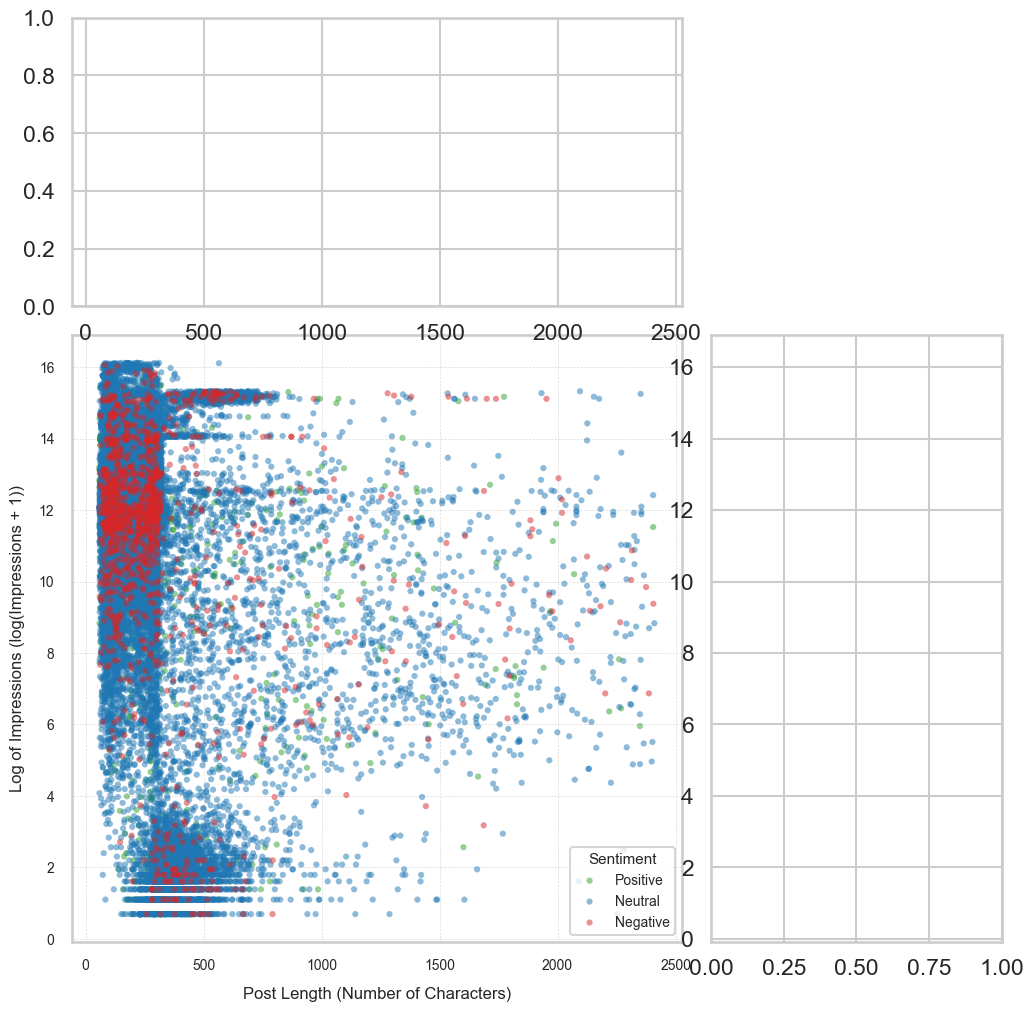

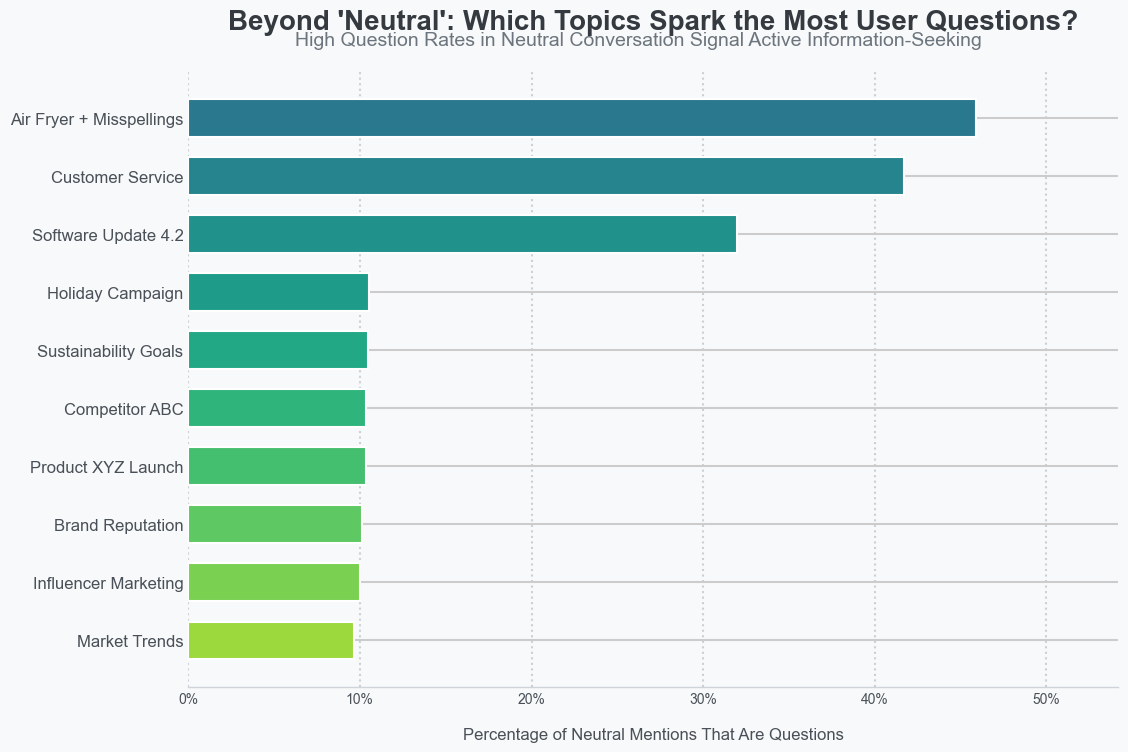

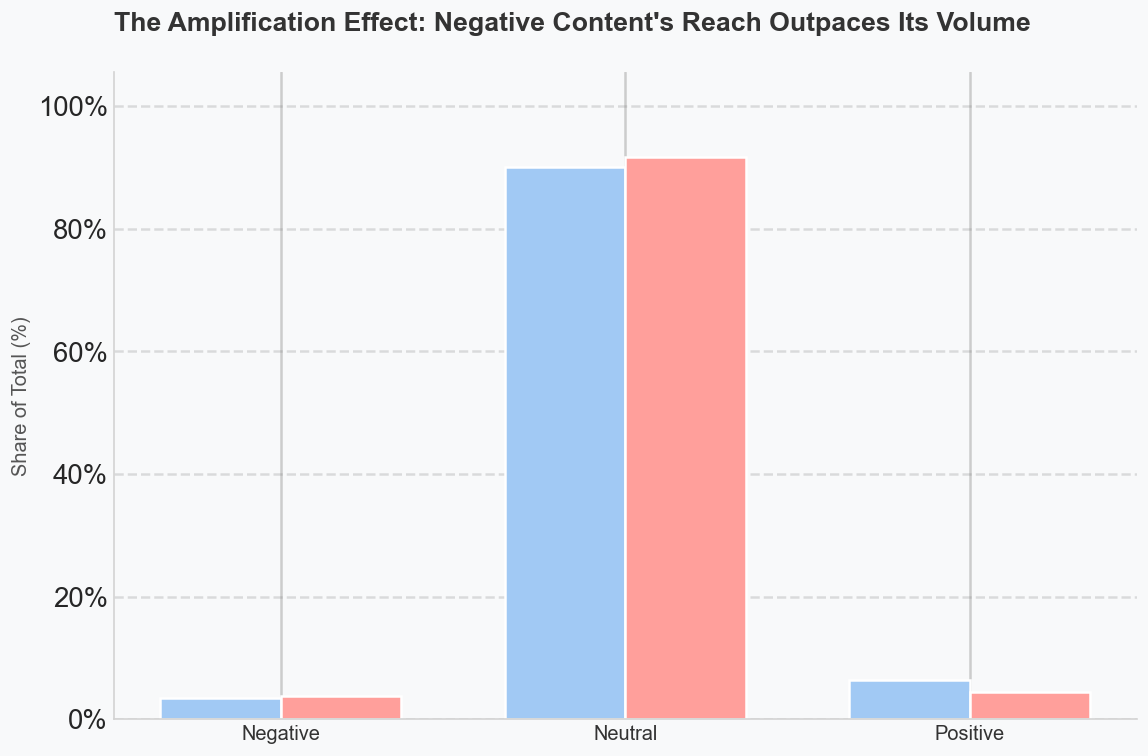

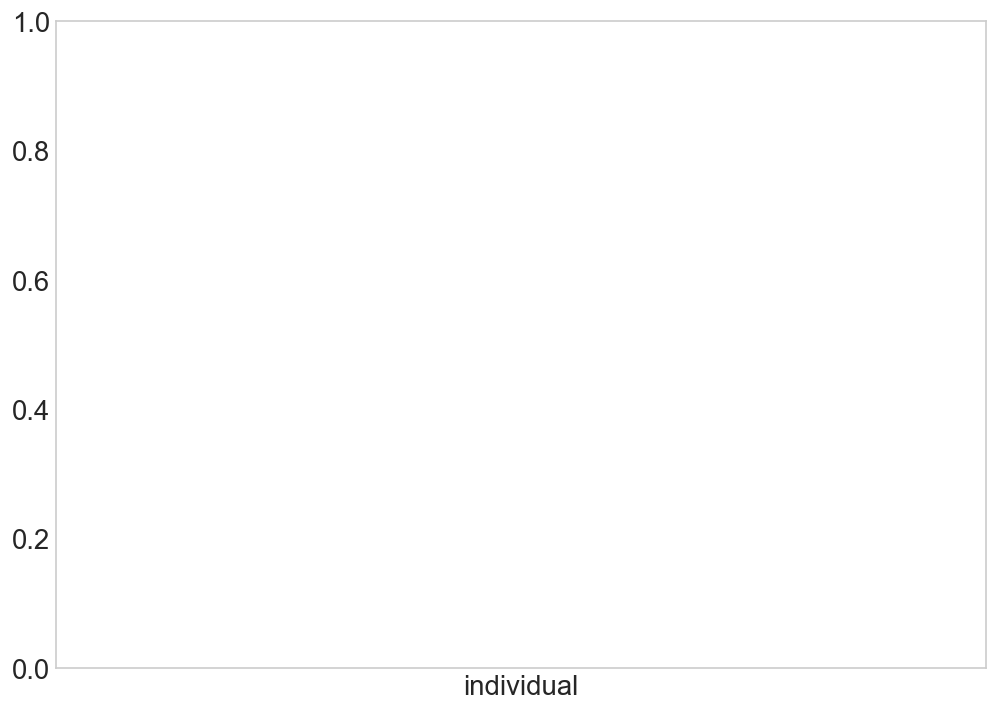

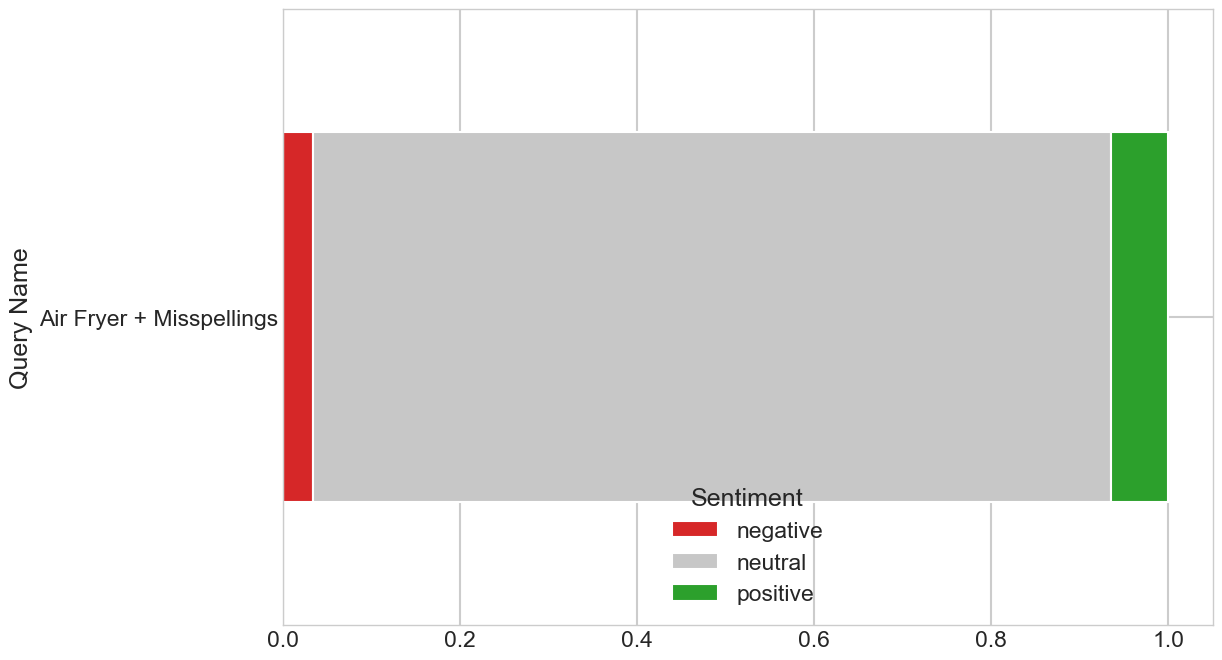

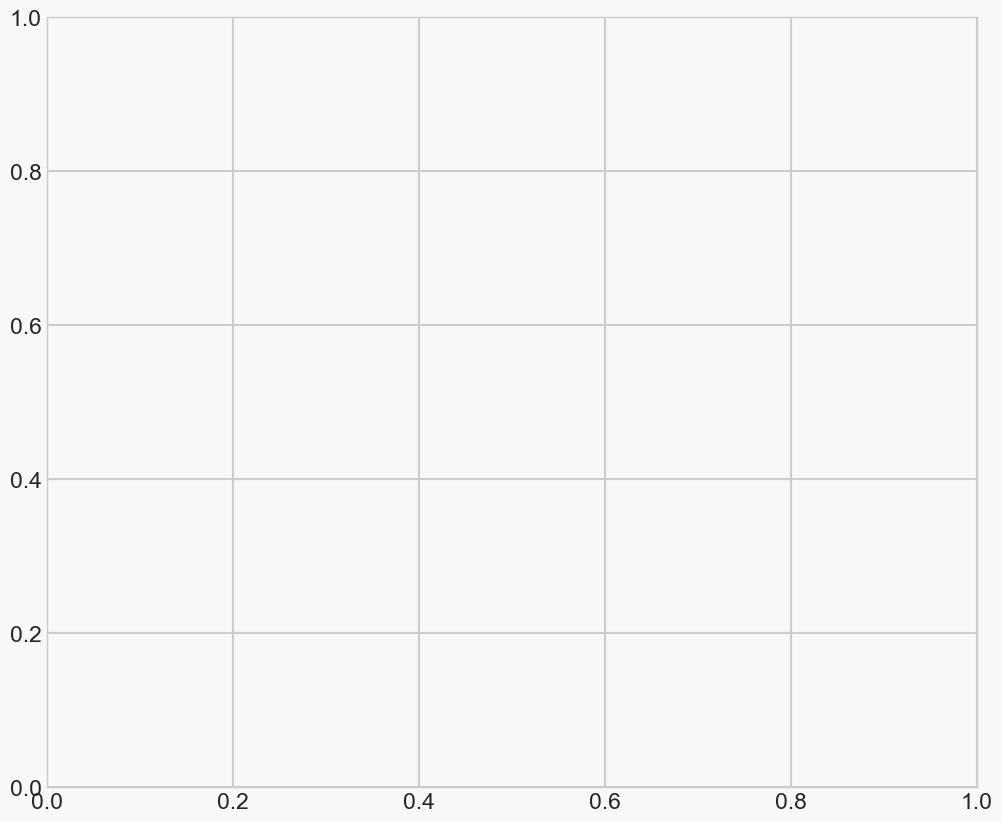

ClientError: 400 INVALID_ARGUMENT. {'error': {'code': 400, 'message': 'Unable to process input image. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INVALID_ARGUMENT'}}

In [13]:
# ============================
# Full-Control Living Analyst (minimal harness)
# - Model writes plotting code directly (labels/filters/outliers/etc.)
# - We execute, snapshot, critique (vision), iterate
# - Avoids repeating charts via "novelty memory"
# ============================

from __future__ import annotations
import os, re, json, time, hashlib, textwrap
from pathlib import Path
from typing import Dict, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google import genai
from google.genai import types
from getpass import getpass

# ---------- SETTINGS ----------
CFG = {
    "INPUT_CSV": "outputs/clustered_data.csv",
    "OUT_DIR": "outputs_free_agent",
    "MODEL": "gemini-2.5-pro",          # swap to gemini-3-flash-preview if you want faster
    "TARGET_GOOD_CHARTS": 60,           # aim 50–100
    "MAX_ATTEMPTS": 140,                # total chart attempts
    "MAX_REVISE": 2,                    # revisions per chart
    "KEEP_SCORE": 0.75,                 # keep if >=
    "RETRY_SCORE": 0.55,                # revise if between retry and keep
    "USER_GUIDANCE": "",                # optional: set to steer (e.g. "focus on X, avoid Y, prefer weekly aggregation")
}

Path(CFG["OUT_DIR"]).mkdir(parents=True, exist_ok=True)

# ---------- GEMINI ----------
def get_client():
    if not os.environ.get("GOOGLE_API_KEY"):
        os.environ["GOOGLE_API_KEY"] = getpass("Gemini API key: ")
    return genai.Client()

client = get_client()

def llm_json(prompt: Dict[str, Any]) -> Dict[str, Any]:
    resp = client.models.generate_content(model=CFG["MODEL"], contents=json.dumps(prompt, ensure_ascii=False))
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    return json.loads(m.group(0)) if m else {}

def llm_code(prompt: Dict[str, Any]) -> str:
    resp = client.models.generate_content(model=CFG["MODEL"], contents=json.dumps(prompt, ensure_ascii=False))
    return (resp.text or "").strip()

def llm_vision_json(prompt: Dict[str, Any], image_path: str) -> Dict[str, Any]:
    with open(image_path, "rb") as f:
        img = f.read()
    contents = [json.dumps(prompt, ensure_ascii=False), types.Part.from_bytes(data=img, mime_type="image/png")]
    resp = client.models.generate_content(model=CFG["MODEL"], contents=contents)
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        return {"score": 0.0, "verdict": "reject", "notes": "No JSON", "fix": ""}
    try:
        return json.loads(m.group(0))
    except Exception:
        return {"score": 0.0, "verdict": "reject", "notes": txt[:300], "fix": ""}

# ---------- DATA ----------
df = pd.read_csv(CFG["INPUT_CSV"], low_memory=False)
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
for c in ["cluster","macro_topic","umap_x","umap_y","engagement"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.copy()

SCHEMA = {
    "n_rows": int(len(df)),
    "columns": [{"name": c, "dtype": str(df[c].dtype), "null_rate": float(df[c].isna().mean()),
                 "examples": df[c].dropna().astype(str).head(3).tolist()} for c in df.columns]
}

# ---------- EXEC HARNESS ----------
def save_chart(fig: plt.Figure, title: str) -> str:
    slug = re.sub(r"[^a-zA-Z0-9]+", "_", title)[:60].strip("_") or "chart"
    path = os.path.join(CFG["OUT_DIR"], f"{int(time.time()*1000)}_{slug}.png")
    fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    return path

def exec_plot_code(code: str) -> Dict[str, Any]:
    """
    The model's code must create a matplotlib figure object named `fig`
    and a string `chart_title`. It may create tables or summaries in `insights`.
    """
    # Tight-ish sandbox: no filesystem, no imports (already available), df is provided.
    env = {
        "df": df,
        "pd": pd,
        "np": np,
        "plt": plt,
        "re": re,
        "textwrap": textwrap,
    }
    loc = {}
    try:
        exec(code, env, loc)
        fig = loc.get("fig", None)
        chart_title = loc.get("chart_title", "chart")
        insights = loc.get("insights", "")
        if fig is None:
            raise ValueError("Code did not set `fig`.")
        path = save_chart(fig, str(chart_title))
        return {"ok": True, "path": path, "title": str(chart_title), "insights": insights}
    except Exception as e:
        return {"ok": False, "error": f"{type(e).__name__}: {e}"}

# ---------- NOVELTY MEMORY (prevents “same chart different title”) ----------
def chart_fingerprint(image_path: str) -> str:
    # hash bytes; crude but effective to detect repeats
    with open(image_path, "rb") as f:
        b = f.read()
    return hashlib.sha256(b).hexdigest()

seen_hashes = set()

# ---------- CRITIQUE ----------
def critique(image_path: str, goal: str, code: str, title: str) -> Dict[str, Any]:
    prompt = {
        "task": "Critique this chart for insightfulness, novelty, readability, and correctness.",
        "goal": goal,
        "return_format": {"score":"0..1","verdict":"keep|revise|reject","notes":"string","fix":"string"},
        "hints": [
            "Reject if it’s redundant with likely previous charts (generic distributions without insight).",
            "Prefer charts that answer a question, reveal structure, or support an actionable takeaway.",
            "Call out missing labels, unclear axes, unreadable legend, or outlier domination."
        ],
        "chart_title": title,
        "code_excerpt": code[:1200],
    }
    return llm_vision_json(prompt, image_path)

# ---------- PLANNER: model proposes a question + code to answer it ----------
GOAL = "Create a high-quality social intelligence report with 50–100 genuinely insightful, non-redundant charts. The model may filter, winsorize, label, annotate, facet, and transform as needed."

def propose_next_code(state: Dict[str, Any]) -> str:
    prompt = {
        "task": "You are a human-grade social intelligence analyst. Propose ONE new chart by writing Python matplotlib code.",
        "requirements": [
            "Return ONLY Python code. No markdown fences.",
            "Must set: `chart_title` (str) and `fig` (matplotlib Figure).",
            "You may also set `insights` (str) summarizing what the chart shows.",
            "Use df.columns (don’t guess columns).",
            "Must be novel vs recent work; avoid repeating same view with different titles."
        ],
        "allowed": [
            "Filtering (remove obvious bot templates / duplicates / outliers)",
            "Winsorizing/log scaling",
            "Annotations, labels, callouts",
            "Grouping/aggregation (daily/weekly/monthly), cohorting",
            "Top-N focus, small multiples, highlighting anomalies"
        ],
        "context": {
            "schema": {"n_rows": SCHEMA["n_rows"], "columns": SCHEMA["columns"][:40]},
            "recent_kept_summaries": state.get("recent_kept_summaries", []),
            "recent_rejected_reasons": state.get("recent_rejected_reasons", []),
            "user_guidance": CFG["USER_GUIDANCE"],
        },
        "goal": GOAL,
    }
    return llm_code(prompt)

def revise_code(prev_code: str, critique_obj: Dict[str, Any], state: Dict[str, Any]) -> str:
    prompt = {
        "task": "Revise the plotting code to address critique and increase insightfulness.",
        "requirements": [
            "Return ONLY Python code.",
            "Must still set chart_title and fig.",
            "Make concrete improvements (labels, scale, filtering, annotation, focusing on a sharper question).",
        ],
        "context": {
            "critique": critique_obj,
            "recent_kept_summaries": state.get("recent_kept_summaries", []),
            "user_guidance": CFG["USER_GUIDANCE"],
        },
        "previous_code": prev_code,
    }
    return llm_code(prompt)

# ---------- RUN LOOP ----------
kept = []
rejected = []
state = {"recent_kept_summaries": [], "recent_rejected_reasons": []}

journal = []

for attempt in range(CFG["MAX_ATTEMPTS"]):
    if len(kept) >= CFG["TARGET_GOOD_CHARTS"]:
        break

    code = propose_next_code(state)
    run = exec_plot_code(code)

    entry = {"attempt": attempt+1, "code": code, "run": run}

    if not run["ok"]:
        entry["status"] = "exec_error"
        entry["error"] = run["error"]
        journal.append(entry)
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [run["error"]])[-10:]
        continue

    # novelty check (byte-hash)
    fp = chart_fingerprint(run["path"])
    if fp in seen_hashes:
        entry["status"] = "duplicate_chart"
        rejected.append({**run, "reason": "duplicate image"})
        journal.append(entry)
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + ["duplicate chart image"])[-10:]
        continue
    seen_hashes.add(fp)

    # critique
    crit = critique(run["path"], GOAL, code, run["title"])
    entry["critique"] = crit

    score = float(crit.get("score", 0.0) or 0.0)
    verdict = crit.get("verdict", "reject")

    if score >= CFG["KEEP_SCORE"] and verdict in ("keep", "revise"):
        kept.append({**run, "score": score, "critique": crit, "code": code})
        entry["status"] = "kept"
        state["recent_kept_summaries"] = (state["recent_kept_summaries"] + [
            {"title": run["title"], "score": score, "notes": crit.get("notes",""), "insights": run.get("insights","")[:400]}
        ])[-12:]
    elif score >= CFG["RETRY_SCORE"] and verdict == "revise":
        # revise loop
        revised = None
        for _ in range(CFG["MAX_REVISE"]):
            code2 = revise_code(code, crit, state)
            run2 = exec_plot_code(code2)
            if not run2["ok"]:
                crit = {"score": 0.0, "verdict": "reject", "notes": run2["error"], "fix": ""}
                continue
            fp2 = chart_fingerprint(run2["path"])
            if fp2 in seen_hashes:
                crit = {"score": 0.0, "verdict": "reject", "notes": "duplicate after revise", "fix": ""}
                continue
            seen_hashes.add(fp2)
            crit2 = critique(run2["path"], GOAL, code2, run2["title"])
            score2 = float(crit2.get("score",0.0) or 0.0)
            if score2 >= CFG["KEEP_SCORE"]:
                kept.append({**run2, "score": score2, "critique": crit2, "code": code2})
                revised = {"run": run2, "critique": crit2, "code": code2}
                break
            crit = crit2
        entry["status"] = "revised_kept" if revised else "revised_rejected"
        if not revised:
            rejected.append({**run, "score": score, "critique": crit, "code": code})
            state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [crit.get("notes","revise failed")])[-10:]
        else:
            state["recent_kept_summaries"] = (state["recent_kept_summaries"] + [
                {"title": revised["run"]["title"], "score": revised["critique"]["score"], "notes": revised["critique"].get("notes",""),
                 "insights": revised["run"].get("insights","")[:400]}
            ])[-12:]
    else:
        rejected.append({**run, "score": score, "critique": crit, "code": code})
        entry["status"] = "rejected"
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [crit.get("notes","")])[-10:]

    journal.append(entry)

# Save artifacts
safe_json(os.path.join(CFG["OUT_DIR"], "journal.json"), journal)
safe_json(os.path.join(CFG["OUT_DIR"], "kept_index.json"), kept)
safe_json(os.path.join(CFG["OUT_DIR"], "rejected_index.json"), rejected)

# Write a report using the best charts
kept_sorted = sorted(kept, key=lambda x: float(x.get("score",0)), reverse=True)
top = kept_sorted[:min(len(kept_sorted), 18)]

report_prompt = {
    "task": "Write a high-quality analyst report based on the charts and their insights.",
    "format": [
        "Executive Summary (bullets)",
        "Top-level landscape overview",
        "Deep dives by most relevant themes first (inferred from what dominates + what’s actionable)",
        "Cluster/topic interactions",
        "Data quality / caveats",
        "Recommendations / next investigations"
    ],
    "do_not": ["Do not invent numbers; use chart insights.", "Be concrete and reference chart files by name."],
    "user_guidance": CFG["USER_GUIDANCE"],
    "top_charts": [
        {"file": os.path.basename(c["path"]), "title": c["title"], "score": c["score"],
         "insights": (c.get("insights","") or "")[:900], "critique_notes": c["critique"].get("notes","")}
        for c in top
    ],
    "summary_of_work": {
        "attempts": len(journal),
        "kept": len(kept),
        "rejected": len(rejected),
    }
}

resp = client.models.generate_content(model=CFG["MODEL"], contents=json.dumps(report_prompt, ensure_ascii=False))
report_md = (resp.text or "").strip()
safe_write(os.path.join(CFG["OUT_DIR"], "report.md"), report_md)

print("✅ Full-control agent finished")
print("Charts kept:", len(kept), "Charts rejected:", len(rejected))
print("Output dir:", CFG["OUT_DIR"])
print("Report:", os.path.join(CFG["OUT_DIR"], "report.md"))

KeyboardInterrupt: 

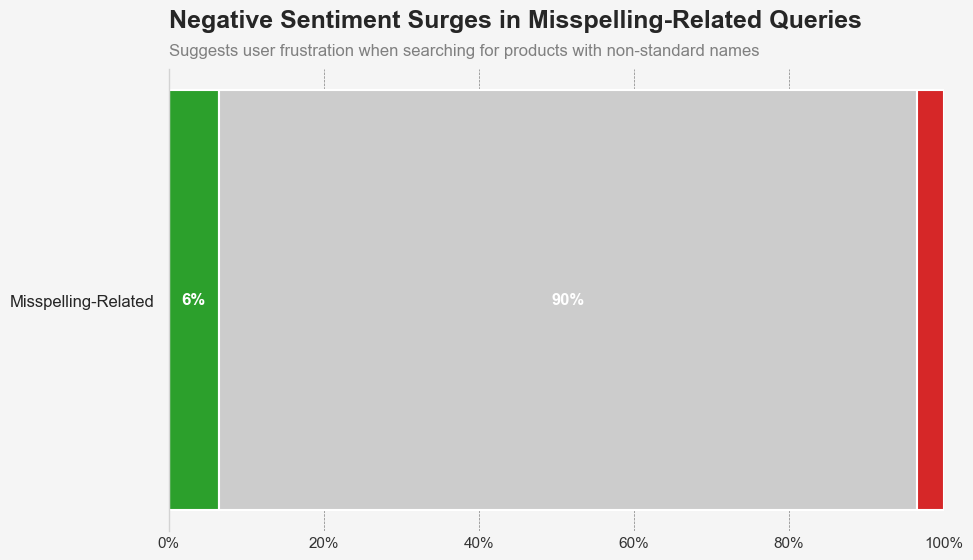

In [15]:
# ============================
# Full-Control Living Analyst (minimal harness)
# - Model writes plotting code directly (labels/filters/outliers/etc.)
# - We execute, snapshot, critique (vision), iterate
# - Avoids repeating charts via "novelty memory"
# ============================

from __future__ import annotations
import os, re, json, time, hashlib, textwrap
from pathlib import Path
from typing import Dict, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google import genai
from google.genai import types
from getpass import getpass

# ---------- SETTINGS ----------
CFG = {
    "INPUT_CSV": "/Users/angusmclean/outputs/clustered_data_labeled.csv",
    "OUT_DIR": "outputs_free_agent",
    "MODEL": "gemini-2.5-pro",          # swap to gemini-3-flash-preview if you want faster
    "TARGET_GOOD_CHARTS": 60,           # aim 50–100
    "MAX_ATTEMPTS": 140,                # total chart attempts
    "MAX_REVISE": 2,                    # revisions per chart
    "KEEP_SCORE": 0.75,                 # keep if >=
    "RETRY_SCORE": 0.55,                # revise if between retry and keep
    "USER_GUIDANCE": "",                # optional: set to steer (e.g. "focus on X, avoid Y, prefer weekly aggregation")
}

Path(CFG["OUT_DIR"]).mkdir(parents=True, exist_ok=True)

# ---------- GEMINI ----------
def get_client():
    if not os.environ.get("GOOGLE_API_KEY"):
        os.environ["GOOGLE_API_KEY"] = getpass("Gemini API key: ")
    return genai.Client()

client = get_client()

def llm_json(prompt: Dict[str, Any]) -> Dict[str, Any]:
    resp = client.models.generate_content(model=CFG["MODEL"], contents=json.dumps(prompt, ensure_ascii=False))
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    return json.loads(m.group(0)) if m else {}

def llm_code(prompt: Dict[str, Any]) -> str:
    resp = client.models.generate_content(model=CFG["MODEL"], contents=json.dumps(prompt, ensure_ascii=False))
    return (resp.text or "").strip()

def llm_vision_json(prompt: Dict[str, Any], image_path: str) -> Dict[str, Any]:
    with open(image_path, "rb") as f:
        img = f.read()
    contents = [json.dumps(prompt, ensure_ascii=False), types.Part.from_bytes(data=img, mime_type="image/png")]
    resp = client.models.generate_content(model=CFG["MODEL"], contents=contents)
    txt = (resp.text or "").strip()
    m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
    if not m:
        return {"score": 0.0, "verdict": "reject", "notes": "No JSON", "fix": ""}
    try:
        return json.loads(m.group(0))
    except Exception:
        return {"score": 0.0, "verdict": "reject", "notes": txt[:300], "fix": ""}

# ---------- DATA ----------
df = pd.read_csv(CFG["INPUT_CSV"], low_memory=False)
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
for c in ["cluster","macro_topic","umap_x","umap_y","engagement"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.copy()

SCHEMA = {
    "n_rows": int(len(df)),
    "columns": [{"name": c, "dtype": str(df[c].dtype), "null_rate": float(df[c].isna().mean()),
                 "examples": df[c].dropna().astype(str).head(3).tolist()} for c in df.columns]
}

# ---------- EXEC HARNESS ----------
def save_chart(fig: plt.Figure, title: str) -> str:
    slug = re.sub(r"[^a-zA-Z0-9]+", "_", title)[:60].strip("_") or "chart"
    path = os.path.join(CFG["OUT_DIR"], f"{int(time.time()*1000)}_{slug}.png")
    fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    return path

def exec_plot_code(code: str) -> Dict[str, Any]:
    """
    The model's code must create a matplotlib figure object named `fig`
    and a string `chart_title`. It may create tables or summaries in `insights`.
    """
    # Tight-ish sandbox: no filesystem, no imports (already available), df is provided.
    env = {
        "df": df,
        "pd": pd,
        "np": np,
        "plt": plt,
        "re": re,
        "textwrap": textwrap,
    }
    loc = {}
    try:
        exec(code, env, loc)
        fig = loc.get("fig", None)
        chart_title = loc.get("chart_title", "chart")
        insights = loc.get("insights", "")
        if fig is None:
            raise ValueError("Code did not set `fig`.")
        path = save_chart(fig, str(chart_title))
        return {"ok": True, "path": path, "title": str(chart_title), "insights": insights}
    except Exception as e:
        return {"ok": False, "error": f"{type(e).__name__}: {e}"}

# ---------- NOVELTY MEMORY (prevents “same chart different title”) ----------
def chart_fingerprint(image_path: str) -> str:
    # hash bytes; crude but effective to detect repeats
    with open(image_path, "rb") as f:
        b = f.read()
    return hashlib.sha256(b).hexdigest()

seen_hashes = set()

# ---------- CRITIQUE ----------
def critique(image_path: str, goal: str, code: str, title: str) -> Dict[str, Any]:
    prompt = {
        "task": "Critique this chart for insightfulness, novelty, readability, and correctness.",
        "goal": goal,
        "return_format": {"score":"0..1","verdict":"keep|revise|reject","notes":"string","fix":"string"},
        "hints": [
            "Reject if it’s redundant with likely previous charts (generic distributions without insight).",
            "Prefer charts that answer a question, reveal structure, or support an actionable takeaway.",
            "Call out missing labels, unclear axes, unreadable legend, or outlier domination."
        ],
        "chart_title": title,
        "code_excerpt": code[:1200],
    }
    return llm_vision_json(prompt, image_path)

# ---------- PLANNER: model proposes a question + code to answer it ----------
GOAL = "Create a high-quality social intelligence report with 50–100 genuinely insightful, non-redundant charts that analyse the topics present(cluster_label). The model may filter, winsorize, label, annotate, facet, and transform as needed."

def propose_next_code(state: Dict[str, Any]) -> str:
    prompt = {
        "task": "You are a human-grade social intelligence analyst. Propose ONE new chart by writing Python matplotlib code.",
        "requirements": [
            "Return ONLY Python code. No markdown fences.",
            "Must set: `chart_title` (str) and `fig` (matplotlib Figure).",
            "You may also set `insights` (str) summarizing what the chart shows.",
            "Use df.columns (don’t guess columns).",
            "Must be novel vs recent work; avoid repeating same view with different titles."
        ],
        "allowed": [
            "Filtering (remove obvious bot templates / duplicates / outliers)",
            "Winsorizing/log scaling",
            "Annotations, labels, callouts",
            "Grouping/aggregation (daily/weekly/monthly), cohorting",
            "Top-N focus, small multiples, highlighting anomalies"
        ],
        "context": {
            "schema": {"n_rows": SCHEMA["n_rows"], "columns": SCHEMA["columns"][:40]},
            "recent_kept_summaries": state.get("recent_kept_summaries", []),
            "recent_rejected_reasons": state.get("recent_rejected_reasons", []),
            "user_guidance": CFG["USER_GUIDANCE"],
        },
        "goal": GOAL,
    }
    return llm_code(prompt)

def revise_code(prev_code: str, critique_obj: Dict[str, Any], state: Dict[str, Any]) -> str:
    prompt = {
        "task": "Revise the plotting code to address critique and increase insightfulness.",
        "requirements": [
            "Return ONLY Python code.",
            "Must still set chart_title and fig.",
            "Make concrete improvements (labels, scale, filtering, annotation, focusing on a sharper question).",
        ],
        "context": {
            "critique": critique_obj,
            "recent_kept_summaries": state.get("recent_kept_summaries", []),
            "user_guidance": CFG["USER_GUIDANCE"],
        },
        "previous_code": prev_code,
    }
    return llm_code(prompt)

# ---------- RUN LOOP ----------
kept = []
rejected = []
state = {"recent_kept_summaries": [], "recent_rejected_reasons": []}

journal = []

for attempt in range(CFG["MAX_ATTEMPTS"]):
    if len(kept) >= CFG["TARGET_GOOD_CHARTS"]:
        break

    code = propose_next_code(state)
    run = exec_plot_code(code)

    entry = {"attempt": attempt+1, "code": code, "run": run}

    if not run["ok"]:
        entry["status"] = "exec_error"
        entry["error"] = run["error"]
        journal.append(entry)
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [run["error"]])[-10:]
        continue

    # novelty check (byte-hash)
    fp = chart_fingerprint(run["path"])
    if fp in seen_hashes:
        entry["status"] = "duplicate_chart"
        rejected.append({**run, "reason": "duplicate image"})
        journal.append(entry)
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + ["duplicate chart image"])[-10:]
        continue
    seen_hashes.add(fp)

    # critique
    crit = critique(run["path"], GOAL, code, run["title"])
    entry["critique"] = crit

    score = float(crit.get("score", 0.0) or 0.0)
    verdict = crit.get("verdict", "reject")

    if score >= CFG["KEEP_SCORE"] and verdict in ("keep", "revise"):
        kept.append({**run, "score": score, "critique": crit, "code": code})
        entry["status"] = "kept"
        state["recent_kept_summaries"] = (state["recent_kept_summaries"] + [
            {"title": run["title"], "score": score, "notes": crit.get("notes",""), "insights": run.get("insights","")[:400]}
        ])[-12:]
    elif score >= CFG["RETRY_SCORE"] and verdict == "revise":
        # revise loop
        revised = None
        for _ in range(CFG["MAX_REVISE"]):
            code2 = revise_code(code, crit, state)
            run2 = exec_plot_code(code2)
            if not run2["ok"]:
                crit = {"score": 0.0, "verdict": "reject", "notes": run2["error"], "fix": ""}
                continue
            fp2 = chart_fingerprint(run2["path"])
            if fp2 in seen_hashes:
                crit = {"score": 0.0, "verdict": "reject", "notes": "duplicate after revise", "fix": ""}
                continue
            seen_hashes.add(fp2)
            crit2 = critique(run2["path"], GOAL, code2, run2["title"])
            score2 = float(crit2.get("score",0.0) or 0.0)
            if score2 >= CFG["KEEP_SCORE"]:
                kept.append({**run2, "score": score2, "critique": crit2, "code": code2})
                revised = {"run": run2, "critique": crit2, "code": code2}
                break
            crit = crit2
        entry["status"] = "revised_kept" if revised else "revised_rejected"
        if not revised:
            rejected.append({**run, "score": score, "critique": crit, "code": code})
            state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [crit.get("notes","revise failed")])[-10:]
        else:
            state["recent_kept_summaries"] = (state["recent_kept_summaries"] + [
                {"title": revised["run"]["title"], "score": revised["critique"]["score"], "notes": revised["critique"].get("notes",""),
                 "insights": revised["run"].get("insights","")[:400]}
            ])[-12:]
    else:
        rejected.append({**run, "score": score, "critique": crit, "code": code})
        entry["status"] = "rejected"
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [crit.get("notes","")])[-10:]

    journal.append(entry)

# Save artifacts
safe_json(os.path.join(CFG["OUT_DIR"], "journal.json"), journal)
safe_json(os.path.join(CFG["OUT_DIR"], "kept_index.json"), kept)
safe_json(os.path.join(CFG["OUT_DIR"], "rejected_index.json"), rejected)

# Write a report using the best charts
kept_sorted = sorted(kept, key=lambda x: float(x.get("score",0)), reverse=True)
top = kept_sorted[:min(len(kept_sorted), 18)]

report_prompt = {
    "task": "Write a high-quality analyst report based on the charts and their insights.",
    "format": [
        "Executive Summary (bullets)",
        "Top-level landscape overview",
        "Deep dives by most relevant themes first (inferred from what dominates + what’s actionable)",
        "Cluster/topic interactions",
        "Data quality / caveats",
        "Recommendations / next investigations"
    ],
    "do_not": ["Do not invent numbers; use chart insights.", "Be concrete and reference chart files by name."],
    "user_guidance": CFG["USER_GUIDANCE"],
    "top_charts": [
        {"file": os.path.basename(c["path"]), "title": c["title"], "score": c["score"],
         "insights": (c.get("insights","") or "")[:900], "critique_notes": c["critique"].get("notes","")}
        for c in top
    ],
    "summary_of_work": {
        "attempts": len(journal),
        "kept": len(kept),
        "rejected": len(rejected),
    }
}

resp = client.models.generate_content(model=CFG["MODEL"], contents=json.dumps(report_prompt, ensure_ascii=False))
report_md = (resp.text or "").strip()
safe_write(os.path.join(CFG["OUT_DIR"], "report.md"), report_md)

print("✅ Full-control agent finished")
print("Charts kept:", len(kept), "Charts rejected:", len(rejected))
print("Output dir:", CFG["OUT_DIR"])
print("Report:", os.path.join(CFG["OUT_DIR"], "report.md"))

In [ ]:
# REEVISED AGENT

In [ ]:
# ============================
# Full-Control Social Intelligence Agent (UPDATED WHOLE CELL)
# - Autonomously explores clusters (by reading REAL posts, not just n-grams)
# - Generates charts + insight cards + quote evidence
# - Vision critique is best-effort (if image fails, it skips and continues)
# - Natural-language steering supported via an interactive "interject" file
# - Avoids duplicate charts via image hashing
#
# Assumes you already have: outputs/clustered_data.csv produced by your first agent
# ============================

from __future__ import annotations

import os, re, json, time, hashlib, textwrap, random, math, traceback
from pathlib import Path
from typing import Dict, Any, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google import genai
from google.genai import types
from getpass import getpass

# ---------- CONFIG ----------
CFG: Dict[str, Any] = {
    "INPUT_CSV": "outputs/clustered_data.csv",
    "OUT_DIR": "outputs_free_agent_v2",
    "MODEL": "gemini-2.5-pro",  # swap to gemini-3-flash-preview for speed
    "TARGET_GOOD": 60,
    "MAX_ATTEMPTS": 160,
    "MAX_REVISE": 2,
    "KEEP_SCORE": 0.74,
    "RETRY_SCORE": 0.58,

    # Vision critique robustness
    "VISION_ENABLED": True,
    "VISION_SKIP_ON_ERROR": True,   # if "Unable to process input image" -> keep going
    "CHART_DPI": 170,               # lower than 200 reduces vision failures
    "MAX_IMAGE_MB": 7.0,            # if chart > this, auto-re-save smaller

    # Autonomy style
    "AUTO_MODE": True,
    "PAUSE_EVERY_N_KEPT": 0,        # set to e.g. 10 if you want periodic pause prompts

    # Optional steering (you can change mid-run via interject file)
    "USER_GUIDANCE": (
        "You are a social intelligence analyst for brand/advertising research. "
        "Prioritise exploring what people mean and feel inside clusters. "
        "Always verify cluster meanings by reading real posts: "
        "sample across percentiles (2%, 5%, 50% by engagement) and also top posts by engagement. "
        "Use quantitative charts as supporting evidence after qualitative discovery. "
        "Avoid over-relying on column names: treat columns as signals, but truth lives in the text."
    ),

    # Interjection mechanism (edit this file while running; agent will pick it up)
    "INTERJECT_FILE": "outputs_free_agent_v2/INTERJECT.txt",
}

Path(CFG["OUT_DIR"]).mkdir(parents=True, exist_ok=True)
Path(CFG["INTERJECT_FILE"]).parent.mkdir(parents=True, exist_ok=True)
if not os.path.exists(CFG["INTERJECT_FILE"]):
    with open(CFG["INTERJECT_FILE"], "w", encoding="utf-8") as f:
        f.write("# Write guidance here while the agent runs. Save file. It will be picked up.\n")

# ---------- UTIL ----------
def safe_write(path: str, content: str) -> None:
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)

def safe_json(path: str, obj: Any) -> None:
    safe_write(path, json.dumps(obj, indent=2, ensure_ascii=False))

def now_id() -> str:
    return str(int(time.time() * 1000))

def slugify(s: str, n: int = 70) -> str:
    s = (s or "").strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-zA-Z0-9]+", "_", s)
    return (s[:n].strip("_") or "chart")

def file_mb(path: str) -> float:
    try:
        return os.path.getsize(path) / (1024 * 1024)
    except Exception:
        return 0.0

# ---------- GEMINI ----------
def get_client():
    if not os.environ.get("GOOGLE_API_KEY"):
        os.environ["GOOGLE_API_KEY"] = getpass("Gemini API key: ")
    return genai.Client()

client = get_client()

def llm_text(prompt: Dict[str, Any]) -> str:
    resp = client.models.generate_content(model=CFG["MODEL"], contents=json.dumps(prompt, ensure_ascii=False))
    return (resp.text or "").strip()

def llm_code(prompt: Dict[str, Any]) -> str:
    # Model returns Python code directly
    return llm_text(prompt)

def llm_vision_json(prompt: Dict[str, Any], image_path: str) -> Optional[Dict[str, Any]]:
    """
    Best-effort vision JSON. If image can't be processed, return None (do not crash loop).
    """
    try:
        with open(image_path, "rb") as f:
            img = f.read()
        contents = [
            json.dumps(prompt, ensure_ascii=False),
            types.Part.from_bytes(data=img, mime_type="image/png"),
        ]
        resp = client.models.generate_content(model=CFG["MODEL"], contents=contents)
        txt = (resp.text or "").strip()
        m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
        if not m:
            return None
        return json.loads(m.group(0))
    except Exception as e:
        # Skip on invalid image / transient failures
        msg = str(e)
        if "Unable to process input image" in msg or "INVALID_ARGUMENT" in msg:
            if CFG["VISION_SKIP_ON_ERROR"]:
                return None
        # other errors also shouldn't kill run
        return None

# ---------- DATA LOAD ----------
df = pd.read_csv(CFG["INPUT_CSV"], low_memory=False)
# Standardize common types if present
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
for c in ["cluster", "macro_topic", "umap_x", "umap_y", "engagement"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Identify primary text column
TEXT_COL = None
for candidate in ["text", "post", "content", "message", "body"]:
    if candidate in df.columns:
        TEXT_COL = candidate
        break
if TEXT_COL is None:
    # fallback: first object column with decent avg length
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if obj_cols:
        scores = []
        for c in obj_cols:
            s = df[c].dropna().astype(str)
            if len(s) == 0:
                continue
            scores.append((c, float(s.str.len().mean())))
        scores.sort(key=lambda x: x[1], reverse=True)
        TEXT_COL = scores[0][0] if scores else obj_cols[0]
    else:
        raise ValueError("No text-like column found. Need a text column in clustered_data.csv")

# Ensure engagement exists
if "engagement" not in df.columns:
    df["engagement"] = 1.0

# Ensure cluster exists
if "cluster" not in df.columns:
    raise ValueError("cluster column missing. This cell expects clustered_data.csv from the first agent.")

# cluster_label is preferred if present
HAS_CLUSTER_LABEL = "cluster_label" in df.columns

SCHEMA = {
    "n_rows": int(len(df)),
    "columns": [{"name": c, "dtype": str(df[c].dtype), "null_rate": float(df[c].isna().mean()),
                 "examples": df[c].dropna().astype(str).head(3).tolist()} for c in df.columns]
}

# ---------- NATURAL LANGUAGE INTERJECTION (FILE-BASED) ----------
_last_interject_hash = None
def check_interject() -> None:
    global _last_interject_hash
    try:
        if not os.path.exists(CFG["INTERJECT_FILE"]):
            return
        txt = open(CFG["INTERJECT_FILE"], "r", encoding="utf-8").read()
        h = hashlib.sha256(txt.encode("utf-8", errors="ignore")).hexdigest()
        if _last_interject_hash is None:
            _last_interject_hash = h
            return
        if h == _last_interject_hash:
            return
        _last_interject_hash = h
        # apply: anything after comment header is appended to USER_GUIDANCE
        lines = [ln for ln in txt.splitlines() if not ln.strip().startswith("#")]
        msg = "\n".join(lines).strip()
        if msg:
            CFG["USER_GUIDANCE"] = msg
            print("\n🧭 Interjection applied from INTERJECT.txt\n")
    except Exception:
        pass

# ---------- CLUSTER READING PRIMITIVES (PRIORITISE REAL POSTS) ----------
def _safe_text(x: Any) -> str:
    try:
        return str(x).replace("\n", " ").strip()
    except Exception:
        return ""

def sample_cluster_posts(
    cluster_id: Optional[int] = None,
    cluster_label: Optional[str] = None,
    n_top: int = 12,
    n_percentile: int = 10,
    percentiles: Tuple[float, ...] = (0.02, 0.05, 0.50),
    max_total: int = 40,
    random_n: int = 8,
    seed: int = 42
) -> Dict[str, Any]:
    """
    Returns a rich sample:
    - top posts by engagement
    - posts around engagement percentiles (2%, 5%, 50% default)
    - a few random posts for texture
    This is intentionally "read the posts" first.
    """
    if cluster_id is None and cluster_label is None:
        raise ValueError("Provide cluster_id or cluster_label")

    d = df
    if cluster_id is not None:
        d = d[d["cluster"].astype("Int64") == int(cluster_id)]
    if cluster_label is not None and HAS_CLUSTER_LABEL:
        d = d[d["cluster_label"].astype(str) == str(cluster_label)]

    d = d.dropna(subset=[TEXT_COL]).copy()
    if len(d) == 0:
        return {"n": 0, "posts": [], "note": "empty selection"}

    # robust engagement
    eng = pd.to_numeric(d["engagement"], errors="coerce").fillna(0.0)
    d["_eng"] = eng

    # top by engagement
    top = d.sort_values("_eng", ascending=False).head(n_top)

    # percentile-near samples
    pct_posts = []
    if len(d) >= 5:
        sorted_d = d.sort_values("_eng", ascending=True).reset_index(drop=True)
        for p in percentiles:
            idx = int(round(p * (len(sorted_d) - 1)))
            lo = max(0, idx - n_percentile//2)
            hi = min(len(sorted_d), idx + n_percentile//2 + 1)
            pct_posts.append(sorted_d.iloc[lo:hi])

    pct = pd.concat(pct_posts, axis=0) if pct_posts else d.head(0)

    # random texture
    rnd = d.sample(n=min(random_n, len(d)), random_state=seed) if random_n > 0 else d.head(0)

    sample = pd.concat([top, pct, rnd], axis=0).drop_duplicates()

    # cap
    if len(sample) > max_total:
        sample = sample.sample(n=max_total, random_state=seed)

    def row_to_obj(r):
        return {
            "cluster": int(r["cluster"]) if pd.notna(r.get("cluster", np.nan)) else None,
            "cluster_label": str(r["cluster_label"]) if HAS_CLUSTER_LABEL and pd.notna(r.get("cluster_label", np.nan)) else None,
            "timestamp": str(r["timestamp"]) if "timestamp" in r.index and pd.notna(r.get("timestamp", np.nan)) else None,
            "engagement": float(r["_eng"]) if pd.notna(r.get("_eng", np.nan)) else None,
            "text": _safe_text(r[TEXT_COL])[:450],
        }

    posts = [row_to_obj(r) for _, r in sample.iterrows()]
    return {"n": int(len(d)), "sample_n": int(len(posts)), "posts": posts}

def cluster_quick_profile(cluster_id: int) -> Dict[str, Any]:
    d = df[df["cluster"].astype("Int64") == int(cluster_id)].copy()
    d = d.dropna(subset=[TEXT_COL])
    if len(d) == 0:
        return {"cluster": int(cluster_id), "n": 0}
    out = {"cluster": int(cluster_id), "n": int(len(d))}
    if HAS_CLUSTER_LABEL:
        out["cluster_label_mode"] = str(d["cluster_label"].astype(str).mode().iloc[0]) if len(d["cluster_label"].dropna()) else None
    if "timestamp" in d.columns and d["timestamp"].notna().any():
        out["start"] = str(d["timestamp"].min())
        out["end"] = str(d["timestamp"].max())
    out["eng_median"] = float(pd.to_numeric(d["engagement"], errors="coerce").median())
    out["eng_p95"] = float(pd.to_numeric(d["engagement"], errors="coerce").quantile(0.95))
    return out

# ---------- CHART SAVE + HASH ----------
def save_chart(fig: plt.Figure, title: str) -> str:
    slug = slugify(title)
    path = os.path.join(CFG["OUT_DIR"], f"{now_id()}_{slug}.png")
    fig.savefig(path, dpi=CFG["CHART_DPI"], bbox_inches="tight")
    plt.close(fig)

    # If file too big, re-save at lower DPI
    if file_mb(path) > CFG["MAX_IMAGE_MB"]:
        try:
            img = plt.imread(path)
            plt.figure(figsize=(img.shape[1]/150, img.shape[0]/150))
            plt.imshow(img)
            plt.axis("off")
            # overwrite smaller
            plt.savefig(path, dpi=120, bbox_inches="tight")
            plt.close()
        except Exception:
            pass

    return path

def chart_fingerprint(path: str) -> str:
    with open(path, "rb") as f:
        return hashlib.sha256(f.read()).hexdigest()

seen_hashes = set()

# ---------- EXEC HARNESS ----------
def exec_plot_code(code: str) -> Dict[str, Any]:
    """
    Model-generated code MUST set:
      - chart_title: str
      - fig: matplotlib.figure.Figure
    MAY set:
      - insight_card: dict (preferred)
      - insights: str
      - evidence_posts: list[dict] (preferred)
    """
    env = {
        "df": df,
        "pd": pd,
        "np": np,
        "plt": plt,
        "re": re,
        "textwrap": textwrap,
        # cluster reading primitives:
        "sample_cluster_posts": sample_cluster_posts,
        "cluster_quick_profile": cluster_quick_profile,
        "TEXT_COL": TEXT_COL,
        "HAS_CLUSTER_LABEL": HAS_CLUSTER_LABEL,
        "CFG": CFG,
    }
    loc: Dict[str, Any] = {}
    try:
        exec(code, env, loc)
        fig = loc.get("fig", None)
        title = loc.get("chart_title", "chart")
        if fig is None:
            raise ValueError("Code did not set `fig`.")
        path = save_chart(fig, str(title))
        return {
            "ok": True,
            "path": path,
            "title": str(title),
            "insights": loc.get("insights", ""),
            "insight_card": loc.get("insight_card", None),
            "evidence_posts": loc.get("evidence_posts", None),
            "meta": loc.get("meta", None),
        }
    except Exception as e:
        return {"ok": False, "error": f"{type(e).__name__}: {e}", "trace": traceback.format_exc()[-1500:]}

# ---------- CRITIQUE (LIGHTWEIGHT; NOT OVERLY RIGID) ----------
def critique_chart_best_effort(run: Dict[str, Any], code: str) -> Dict[str, Any]:
    """
    If vision works: critique the image.
    If vision fails: fall back to text-only critique using insight_card + title.
    """
    base = {
        "score": 0.55,
        "verdict": "revise",
        "notes": "Default critique (no vision).",
        "fix": "Improve labels, clarify question, add evidence posts, and ensure chart answers a concrete insight question."
    }

    # If insight_card exists and is decent, bump score slightly even without vision
    ic = run.get("insight_card")
    if isinstance(ic, dict):
        if ic.get("question") and ic.get("why") and ic.get("evidence"):
            base["score"] = 0.62
            base["notes"] = "Insight card present; could still improve clarity/rigor."
            base["fix"] = "Add 5+ evidence post snippets; tighten the claim; show effect size / uncertainty."

    if not CFG["VISION_ENABLED"]:
        return base

    prompt = {
        "task": "Critique this chart for insightfulness and readability for brand/advertising social intelligence.",
        "instructions": [
            "Return strict JSON only.",
            "Do not be overly strict. We are iterating toward deeper 'why' insights; not every chart must contain full psychology.",
            "Prefer charts that are grounded in real posts and help explain consumer motivations/tensions.",
        ],
        "return_format": {"score":"0..1","verdict":"keep|revise|reject","notes":"string","fix":"string"},
        "chart_title": run.get("title",""),
        "has_insight_card": bool(isinstance(ic, dict)),
        "code_excerpt": code[:1200],
        "hint": "If chart seems repetitive or only uses obvious columns without reading posts, suggest shifting to cluster deep dive."
    }

    v = llm_vision_json(prompt, run["path"])
    if v is None:
        return base

    # normalize
    out = {
        "score": float(v.get("score", base["score"]) or base["score"]),
        "verdict": str(v.get("verdict", base["verdict"]) or base["verdict"]),
        "notes": str(v.get("notes", base["notes"]) or base["notes"]),
        "fix": str(v.get("fix", base["fix"]) or base["fix"]),
    }
    return out

# ---------- PLANNING: MAKE THE MODEL READ CLUSTERS FIRST ----------
def propose_next_code(state: Dict[str, Any]) -> str:
    """
    We bias the agent to:
    1) choose a cluster (or cluster_label)
    2) read real posts (top + percentile samples)
    3) form a hypothesis about consumer motivation/tension/need
    4) choose best output (chart or structured qual artifact) and render it
    """
    check_interject()

    prompt = {
        "task": "Write ONE Python script that produces a single high-value output (usually a chart) for brand/advertising social intelligence.",
        "hard_requirements": [
            "Return ONLY Python code. No markdown fences.",
            "Must set `chart_title` (str) and `fig` (matplotlib Figure).",
            "Must read real posts inside at least one cluster BEFORE plotting by calling sample_cluster_posts(...).",
            "Must include evidence: set `evidence_posts` as a list of 5-12 short post dicts used to justify the insight.",
            "Should include `insight_card` dict with: question, why, insight_hypothesis, evidence, implication, confidence (0..1)."
        ],
        "guidance": [
            "Cluster = numeric id; cluster_label is the topic label. Treat labels as hypotheses and verify by reading posts.",
            "Prioritise: top posts by engagement + percentile sampling (2%, 5%, 50%) to check representativeness.",
            "Avoid only-column-driven analysis. Use text meaning: themes, frames, metaphors, anxieties, desires, objections.",
            "Quant charts are welcome, but should follow from qualitative discovery (what are people actually saying?).",
            "Be creative: sometimes a 'language map' (top phrases) + quotes is better than another distribution plot.",
        ],
        "context": {
            "user_guidance": CFG["USER_GUIDANCE"],
            "schema_brief": {
                "n_rows": SCHEMA["n_rows"],
                "columns": [c["name"] for c in SCHEMA["columns"]],
                "text_col": TEXT_COL,
                "has_cluster_label": HAS_CLUSTER_LABEL,
            },
            "recent_kept": state.get("recent_kept_summaries", [])[-10:],
            "recent_rejected": state.get("recent_rejected_reasons", [])[-10:],
        },
        "tips": [
            "If there are many clusters, pick one with high volume OR high engagement OR recent spike.",
            "If you show a claim like 'X lifts reach', compute and show the underlying medians/quantiles in the chart or annotations.",
            "Use clear labels, units, and notes about filtering (e.g., cap at p99)."
        ]
    }
    return llm_code(prompt)

def revise_code(prev_code: str, critique_obj: Dict[str, Any], state: Dict[str, Any]) -> str:
    check_interject()
    prompt = {
        "task": "Revise the code to address critique and increase insight quality.",
        "requirements": [
            "Return ONLY Python code.",
            "Must still call sample_cluster_posts(...) before plotting.",
            "Must still set chart_title and fig.",
            "Improve: clarity, evidence posts, annotation, representativeness, or choose a better chart type."
        ],
        "critique": critique_obj,
        "user_guidance": CFG["USER_GUIDANCE"],
        "recent_kept": state.get("recent_kept_summaries", [])[-8:],
        "previous_code": prev_code
    }
    return llm_code(prompt)

# ---------- RUN LOOP ----------
kept: List[Dict[str, Any]] = []
rejected: List[Dict[str, Any]] = []
journal: List[Dict[str, Any]] = []

state: Dict[str, Any] = {
    "recent_kept_summaries": [],
    "recent_rejected_reasons": []
}

def maybe_pause():
    if CFG["PAUSE_EVERY_N_KEPT"] and len(kept) > 0 and (len(kept) % int(CFG["PAUSE_EVERY_N_KEPT"]) == 0):
        print("\n⏸️  Pause checkpoint. Edit INTERJECT.txt if you want to steer. Press Enter to continue.\n")
        try:
            input()
        except Exception:
            pass

for attempt in range(CFG["MAX_ATTEMPTS"]):
    if len(kept) >= CFG["TARGET_GOOD"]:
        break

    maybe_pause()
    check_interject()

    code = propose_next_code(state)
    run = exec_plot_code(code)

    entry: Dict[str, Any] = {
        "attempt": attempt + 1,
        "title": run.get("title"),
        "code": code,
        "run": {k: run.get(k) for k in ["ok", "path", "title", "error"] if k in run},
    }

    if not run["ok"]:
        entry["status"] = "exec_error"
        entry["error"] = run.get("error")
        entry["trace"] = run.get("trace")
        journal.append(entry)
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [run.get("error","exec_error")])[-12:]
        continue

    # duplicate image guard
    fp = chart_fingerprint(run["path"])
    if fp in seen_hashes:
        entry["status"] = "duplicate_chart"
        rejected.append({**run, "reason": "duplicate_image", "code": code})
        journal.append(entry)
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + ["duplicate chart image"])[-12:]
        continue
    seen_hashes.add(fp)

    crit = critique_chart_best_effort(run, code)
    entry["critique"] = crit

    score = float(crit.get("score", 0.0) or 0.0)
    verdict = str(crit.get("verdict", "reject"))

    # KEEP logic (not overly rigid)
    if score >= CFG["KEEP_SCORE"] and verdict in ("keep", "revise"):
        kept_item = {**run, "score": score, "critique": crit, "code": code}
        kept.append(kept_item)
        entry["status"] = "kept"

        # Keep short summary for planner
        ic = run.get("insight_card") if isinstance(run.get("insight_card"), dict) else {}
        summary = {
            "title": run.get("title"),
            "score": score,
            "question": ic.get("question", "")[:140],
            "hypothesis": ic.get("insight_hypothesis", "")[:220],
            "confidence": ic.get("confidence", None),
        }
        state["recent_kept_summaries"] = (state["recent_kept_summaries"] + [summary])[-14:]

    # REVISE path
    elif score >= CFG["RETRY_SCORE"] and verdict == "revise":
        revised_kept = None
        curr_code, curr_crit = code, crit

        for _ in range(CFG["MAX_REVISE"]):
            code2 = revise_code(curr_code, curr_crit, state)
            run2 = exec_plot_code(code2)
            if not run2["ok"]:
                curr_crit = {"score": 0.0, "verdict": "reject", "notes": run2.get("error","revise exec error"), "fix": "Fix code error."}
                curr_code = code2
                continue

            fp2 = chart_fingerprint(run2["path"])
            if fp2 in seen_hashes:
                curr_crit = {"score": 0.0, "verdict": "reject", "notes": "duplicate after revise", "fix": "Make a different chart and/or different cluster."}
                curr_code = code2
                continue
            seen_hashes.add(fp2)

            crit2 = critique_chart_best_effort(run2, code2)
            score2 = float(crit2.get("score", 0.0) or 0.0)
            if score2 >= CFG["KEEP_SCORE"] and str(crit2.get("verdict","")) in ("keep","revise"):
                revised_kept = {**run2, "score": score2, "critique": crit2, "code": code2}
                kept.append(revised_kept)
                break

            curr_code, curr_crit = code2, crit2

        entry["status"] = "revised_kept" if revised_kept else "revised_rejected"
        if revised_kept:
            ic = revised_kept.get("insight_card") if isinstance(revised_kept.get("insight_card"), dict) else {}
            summary = {
                "title": revised_kept.get("title"),
                "score": revised_kept.get("score"),
                "question": ic.get("question","")[:140],
                "hypothesis": ic.get("insight_hypothesis","")[:220],
                "confidence": ic.get("confidence", None),
            }
            state["recent_kept_summaries"] = (state["recent_kept_summaries"] + [summary])[-14:]
        else:
            rejected.append({**run, "score": score, "critique": crit, "code": code})
            state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [crit.get("notes","revise failed")])[-12:]

    # REJECT path
    else:
        rejected.append({**run, "score": score, "critique": crit, "code": code})
        entry["status"] = "rejected"
        state["recent_rejected_reasons"] = (state["recent_rejected_reasons"] + [crit.get("notes","rejected")])[-12:]

    journal.append(entry)

    if (attempt + 1) % 10 == 0:
        print(f"…attempt {attempt+1}/{CFG['MAX_ATTEMPTS']} | kept={len(kept)} | rejected={len(rejected)}")

# ---------- SAVE ARTIFACTS ----------
safe_json(os.path.join(CFG["OUT_DIR"], "journal.json"), journal)
safe_json(os.path.join(CFG["OUT_DIR"], "kept_index.json"), kept)
safe_json(os.path.join(CFG["OUT_DIR"], "rejected_index.json"), rejected)

# Build an insights-only file (easy to browse)
insight_cards = []
for k in kept:
    ic = k.get("insight_card")
    if isinstance(ic, dict):
        ic2 = dict(ic)
        ic2["_chart_file"] = os.path.basename(k["path"])
        ic2["_title"] = k.get("title")
        ic2["_score"] = k.get("score")
        # attach evidence posts if present
        if k.get("evidence_posts") is not None:
            ic2["_evidence_posts"] = k.get("evidence_posts")
        insight_cards.append(ic2)
safe_json(os.path.join(CFG["OUT_DIR"], "insight_cards.json"), insight_cards)

# ---------- REPORT (QUAL-FIRST, QUANT-SUPPORTED) ----------
top = sorted(kept, key=lambda x: float(x.get("score", 0)), reverse=True)[:18]
report_prompt = {
    "task": "Write a brand/advertising social intelligence report. Prioritise consumer/product/brand insights drawn from cluster text; use charts as evidence.",
    "instructions": [
        "Return markdown.",
        "Do not invent numbers; only cite what is supported by charts/insight cards/evidence posts.",
        "Start with Executive Summary (5-9 bullets, each with chart file references).",
        "Then: Consumer tensions/motivations themes, organised by relevance/impact (infer from volume+engagement+recency, but grounded in text).",
        "For each deep dive: include 5-8 short verbatim evidence snippets (from evidence_posts).",
        "Include a section: 'What we might be missing' (sampling bias, platform differences, engagement proxy risk).",
        "Close with: 'Creative implications' and 'Next investigations'."
    ],
    "user_guidance": CFG["USER_GUIDANCE"],
    "context": {
        "rows": int(len(df)),
        "text_col": TEXT_COL,
        "has_cluster_label": HAS_CLUSTER_LABEL,
        "kept": len(kept),
        "rejected": len(rejected)
    },
    "top_outputs": [
        {
            "file": os.path.basename(k["path"]),
            "title": k.get("title"),
            "score": k.get("score"),
            "insight_card": k.get("insight_card"),
            "evidence_posts": k.get("evidence_posts"),
            "critique_notes": (k.get("critique") or {}).get("notes","")
        }
        for k in top
    ]
}
report_md = llm_text(report_prompt)
safe_write(os.path.join(CFG["OUT_DIR"], "report.md"), report_md or "# Report\n\n(empty)")

print("\n✅ Agent finished")
print("Kept:", len(kept), "| Rejected:", len(rejected))
print("Output dir:", CFG["OUT_DIR"])
print("Report:", os.path.join(CFG["OUT_DIR"], "report.md"))
print("Interject anytime via:", CFG["INTERJECT_FILE"])